In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
# os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3,4,5,6,7'
# os.environ["CUDA_VISIBLE_DEVICES"] = '6' 
# os.environ["WORLD_SIZE"] = "1"
import pandas as pd
import numpy as np
import random
import torch
import scipy.sparse as sp
from torch_geometric.utils import dropout_adj, convert
from scipy.spatial import distance_matrix
from torch_geometric.data import Data
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn.models import InnerProductDecoder, VGAE, GAE
from torch_geometric.nn.conv import GCNConv, GINConv, SAGEConv, SGConv
from torch_geometric.nn import APPNP as APPNPConv
from tqdm import tqdm
from sklearn import metrics
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')
torch.set_printoptions(precision=15)

torch.cuda.device_count()

4

In [2]:
torch.cuda.current_device()

0

In [3]:
def seed_run(seed=10):
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['CUBLAS_WORKSPACE_CONFIG']=':4096:8'
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.allow_tf32 = False
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = True
    torch.use_deterministic_algorithms(True)

In [4]:
seed_run(10)

In [5]:
def distance_covariance(X1, X2, control_term=0): # default is 0 # If X2 is the vector, try to add.unsqueeze(1)
    X1 = X1.float()
    X2 = X2.float()
    a_jk = torch.norm(X1[:, None] - X1, dim=2, p=2)
    b_jk = torch.norm(X2[:, None] - X2, dim=2, p=2)
    a_jdot = torch.mean(a_jk, dim=0, keepdim=True)
    b_jdot = torch.mean(b_jk, dim=0, keepdim=True)
    a_dotk = torch.mean(a_jk, dim=1, keepdim=True)
    b_dotk = torch.mean(b_jk, dim=1, keepdim=True)
    a_dotdot = torch.mean(a_jk)
    b_dotdot = torch.mean(b_jk)
    A_jk = a_jk - a_jdot - a_dotk + a_dotdot
    B_jk = b_jk - b_jdot - b_dotk + b_dotdot
    n = X1.shape[0]
    distance_cov = torch.sqrt(torch.sum(A_jk * B_jk) / (n * n))
    
    return distance_cov

In [6]:
def distance_correlation(X1, X2, control_term=0): # default is 0 # If X2 is the vector, try to add.unsqueeze(1)
    X1 = X1.float()
    X2 = X2.float()
    a_jk = torch.norm(X1[:, None] - X1, dim=2, p=2)
    b_jk = torch.norm(X2[:, None] - X2, dim=2, p=2)
    a_jdot = torch.mean(a_jk, dim=0, keepdim=True)
    b_jdot = torch.mean(b_jk, dim=0, keepdim=True)
    a_dotk = torch.mean(a_jk, dim=1, keepdim=True)
    b_dotk = torch.mean(b_jk, dim=1, keepdim=True)
    a_dotdot = torch.mean(a_jk)
    b_dotdot = torch.mean(b_jk)
    A_jk = a_jk - a_jdot - a_dotk + a_dotdot
    B_jk = b_jk - b_jdot - b_dotk + b_dotdot
    n = X1.shape[0]
    distance_cov = torch.sum(A_jk * B_jk) / (n * n)
    distance_var_X1 = torch.sum(A_jk * A_jk) / (n * n)
    distance_var_X2 = torch.sum(B_jk * B_jk) / (n * n)
    distance_corr_X12 = torch.sqrt(distance_cov)/ (torch.sqrt(torch.sqrt(distance_var_X1) * torch.sqrt(distance_var_X2) + control_term))
    distance_corr_X12 = torch.max(distance_corr_X12, 0)[0]
    
    return distance_corr_X12

In [7]:
def run_gnn_prim(device, model_name, data_name, runs, data, x, edge_index, k, in_dim_g, hid_dim_g, out_dim_g, 
             LR, WD, dropout, epochs): # lambda_5, 
    pbar = tqdm(range(runs), unit='run')
    acc, f1, auc_roc, sp, eo = np.zeros(runs), np.zeros(runs), np.zeros(runs), np.zeros(runs), np.zeros(runs)
#     dist_cor_x = np.zeros(epochs)
#     dist_cor_y = np.zeros(epochs)
#     x_ori = data.x
#     x = feature_norm(x)
#     # x = data.x/data.x.norm(dim=0)
    x = x.to(device)
    edge_index = edge_index.to(device)
    y = data.y.to(device)
    sens = data.sens.to(device)
    train_mask = data.idx_train.to(device)
    val_mask = data.idx_val.to(device)
    test_mask = data.idx_test.to(device)

    # Choose Model: MLP or other types of GNNs
#     if model_name == "MLP":
#         model = MLP_prim(in_dim_g, hid_dim_g, out_dim_g, dropout).to(device)
#     elif model_name == "GCN":
    model = GCN_prim(in_dim_g, hid_dim_g, out_dim_g, dropout).to(device)

    optimizer = torch.optim.Adam(model.parameters(), weight_decay=WD, lr=LR)
    seed_run(10)
    for count in pbar:
#         model.reset_parameters()
        
        best_val_loss = float('inf')
#         val_loss_history = []
#         best_val_trade_off = float('inf')
#         best_auc = 0
        
        for epoch in range(1, epochs+1):
            # train the model
            model.train()
            optimizer.zero_grad()
            
            output, emb = model(x, edge_index, k)
            cls_loss = F.binary_cross_entropy_with_logits(output[train_mask], y[train_mask].unsqueeze(1))
            # sens_loss = distance_corr(output[train_mask].unsqueeze(1), sens[train_mask].unsqueeze(1), control_term=control_term)
            # loss = cls_loss # + lambda_1*sens_loss
            cls_loss.backward()
            optimizer.step()
            print('#'*100)
            print(f'Epoch: {epoch:04d}, Loss: {cls_loss:.4f}')
            
            model.eval()
            output, emb = model(x, edge_index, k)
            pred = (output.squeeze() > 0).type_as(y)
            loss_val = F.binary_cross_entropy_with_logits(output[val_mask], y[val_mask].unsqueeze(1))
            accs_val, F1s_val, auc_rocs_val, sps_val, eos_val = evaluate_gnn(y, val_mask, sens, pred, output)
            # cls_loss_val = F.binary_cross_entropy_with_logits(output[val_mask], y[val_mask].unsqueeze(1))
            # sens_loss_val = distance_corr(output[val_mask].unsqueeze(1), sens[val_mask].unsqueeze(1), control_term=control_term)
            # loss_val = cls_loss_val # + lambda_1*sens_loss_val
            if loss_val <= best_val_loss:
                best_val_loss = loss_val.data
#             if auc_rocs_val >= best_auc:
#                 best_auc = auc_rocs_val
                accs_test, F1s_test, auc_rocs_test, sps_test, eos_test = evaluate_gnn(y, test_mask, sens, pred, output)
                print('#'*100)
                print(f'Epoch: {epoch:03d}, AUC: {auc_rocs_test:.4f}, Accuracy: {accs_test:.4f}, F1: {F1s_test:.4f}, Statistical Parity: {sps_test:.4f}, Equal Opportunity: {eos_test:.4f}')

        acc[count] = accs_test
        f1[count] = F1s_test
        auc_roc[count] = auc_rocs_test
        sp[count] = sps_test
        eo[count] = eos_test
    print('======' + data_name + '======')
    print('auc_roc:', np.mean(auc_roc) * 100, np.std(auc_roc) * 100)
    print('Acc:', np.mean(acc) * 100, np.std(acc) * 100)
    print('f1:', np.mean(f1) * 100, np.std(f1) * 100)
    print('parity:', np.mean(sp) * 100, np.std(sp) * 100)
    print('equality:', np.mean(eo) * 100, np.std(eo) * 100)

    return acc, f1, auc_roc, sp, eo, output, pred, emb

In [14]:
def evaluate_gnn(y, mask, sens, pred, output):
    pred = pred[mask].cpu().numpy()
    accs = metrics.accuracy_score(y[mask].cpu().numpy(), pred)
    F1s = metrics.f1_score(y[mask].cpu().numpy(), pred)
    auc_rocs = metrics.roc_auc_score(y[mask].cpu().numpy(), output[mask].detach().cpu().numpy()) # if mps, detach.().cpu().numpy()
    sps, eos = fair_metric(pred, y[mask].cpu().numpy(), sens[mask].cpu().numpy())
    return accs, F1s, auc_rocs, sps, eos

def fair_metric(pred, labels, sens):
    idx_s0 = sens==0
    idx_s1 = sens==1
    idx_s0_y1 = np.bitwise_and(idx_s0, labels==1)
    idx_s1_y1 = np.bitwise_and(idx_s1, labels==1)
    parity = abs(sum(pred[idx_s0])/sum(idx_s0)-sum(pred[idx_s1])/sum(idx_s1))
    equality = abs(sum(pred[idx_s0_y1])/sum(idx_s0_y1)-sum(pred[idx_s1_y1])/sum(idx_s1_y1))
    return parity.item(), equality.item()

In [9]:
import matplotlib.pyplot as plt

In [10]:
from torch.distributions.multivariate_normal import MultivariateNormal

In [12]:
biased_0 = MultivariateNormal(torch.tensor([-10,-2,-5]).float(),torch.eye(3).float())

In [13]:
biased_1 = MultivariateNormal(torch.tensor([10,2,5]).float(),torch.eye(3).float())

In [14]:
g0 = torch.tensor(biased_0.sample())
for i in range(100-1):
    g0 = torch.vstack((g0, biased_0.sample()))
g01 = torch.tensor(biased_0.sample())
for i in range(200-1):
    g01 = torch.vstack((g01, biased_0.sample()))
g02 = torch.tensor(biased_0.sample())
for i in range(100-1):
    g02 = torch.vstack((g02, biased_0.sample()))
g03 = torch.tensor(biased_0.sample())
for i in range(100-1):
    g03 = torch.vstack((g03, biased_0.sample()))

In [15]:
g1 = torch.tensor(biased_1.sample())
for i in range(200-1):
    g1 = torch.vstack((g1, biased_1.sample()))
g11 = torch.tensor(biased_1.sample())
for i in range(600-1):
    g11 = torch.vstack((g11, biased_1.sample()))
g12 = torch.tensor(biased_1.sample())
for i in range(700-1):
    g12 = torch.vstack((g12, biased_1.sample()))
g13 = torch.tensor(biased_1.sample())
for i in range(500-1):
    g13 = torch.vstack((g13, biased_1.sample()))

In [16]:
x_n_major = torch.vstack((g0, g1, g01, g11, g02, g12, g03, g13))

In [17]:
x_n_major[:10,]

tensor([[-10.601392745971680,  -3.012209892272949,  -5.302269458770752],
        [-11.227685928344727,  -1.080171823501587,  -5.348469257354736],
        [-10.869179725646973,  -2.958171367645264,  -6.192046642303467],
        [ -8.095004081726074,  -2.937332153320312,  -5.846467494964600],
        [ -7.732173919677734,  -0.638506174087524,  -4.984336376190186],
        [ -8.900988578796387,  -1.046305418014526,  -3.598936557769775],
        [-10.880546569824219,  -2.651699304580688,  -4.592298030853271],
        [ -9.561080932617188,  -3.124325513839722,  -5.837274074554443],
        [ -8.601932525634766,  -3.409652471542358,  -4.156631946563721],
        [ -7.989611625671387,   0.284396886825562,  -4.806684970855713]])

In [18]:
x_n_major.shape

torch.Size([2500, 3])

In [19]:
sens_major = torch.cat((torch.zeros(100),torch.ones(200), torch.zeros(200),torch.ones(600), torch.zeros(100),torch.ones(700), torch.zeros(100),torch.ones(500)),dim=0)

In [20]:
y = torch.cat((torch.zeros(50),torch.ones(450), torch.zeros(1000), torch.ones(1000)),dim=0)

### Generating the minor subgroups

In [21]:
biased_2 = MultivariateNormal(torch.tensor([-12,-8,-4]).float(),torch.eye(3).float())
biased_3 = MultivariateNormal(torch.tensor([12,8,4]).float(),torch.eye(3).float())

In [22]:
g2 = torch.tensor(biased_2.sample())
for i in range(300-1):
    g2 = torch.vstack((g2, biased_2.sample()))
g3 = torch.tensor(biased_3.sample())
for i in range(1200-1):
    g3 = torch.vstack((g3, biased_3.sample()))
g4 = torch.tensor(biased_2.sample())
for i in range(400-1):
    g4 = torch.vstack((g4, biased_2.sample()))
g5 = torch.tensor(biased_3.sample())
for i in range(600-1):
    g5 = torch.vstack((g5, biased_3.sample()))

In [23]:
x_n_minor = torch.vstack((g2, g3, g4, g5))

In [24]:
x_n_minor.shape

torch.Size([2500, 3])

In [25]:
sens_minor = torch.cat((torch.zeros(300),torch.ones(1200),torch.ones(400),torch.ones(600)),dim=0)

In [26]:
sens = torch.hstack((sens_minor.unsqueeze(1),sens_major.unsqueeze(1)))

In [27]:
sens.shape

torch.Size([2500, 2])

In [28]:
x_n = torch.hstack((x_n_minor, x_n_major))

In [29]:
biased_x_mul = torch.hstack((sens, x_n, y.unsqueeze(1)))

In [30]:
biased_x_mul.shape

torch.Size([2500, 9])

In [11]:
biased_x_mul = torch.load("./biased_x_mul.pt")

In [27]:
biased_x_mul[:,2:8].shape

torch.Size([2500, 6])

In [44]:
torch.save(biased_x_mul, "./biased_x_mul.pt")

In [47]:
import seaborn as sns
def tsne_plot(emb, y, s, name):
    proj_2d = TSNE(n_components=2, learning_rate='auto', init='random', random_state=0).fit_transform(emb)

    g0 = s == 0
    g1 = s == 1
    
    df_xy = pd.DataFrame(proj_2d, columns=['Dimension x','Dimension y'])
    df_xy['Sens.Attr.'] = s
    
    hex_tsne = ['#FE817D', '#81B8DF']
    
    g = sns.scatterplot(x='Dimension x',y='Dimension y',hue='Sens.Attr.',style='Sens.Attr.',palette=sns.color_palette(hex_tsne, 2),
        data=df_xy) #"GnBu"
    # legend = g.legend()
    g.legend(title="Sensitive Group", loc='upper left', fontsize=14, title_fontsize=15)
    plt.tick_params(labelsize=15)
    font = {"size": 16}
    plt.xlabel("Dimension X", fontdict=font)
    plt.ylabel("Dimension Y", fontdict=font)
    png_name = name+'.png'
    plt.savefig(png_name)

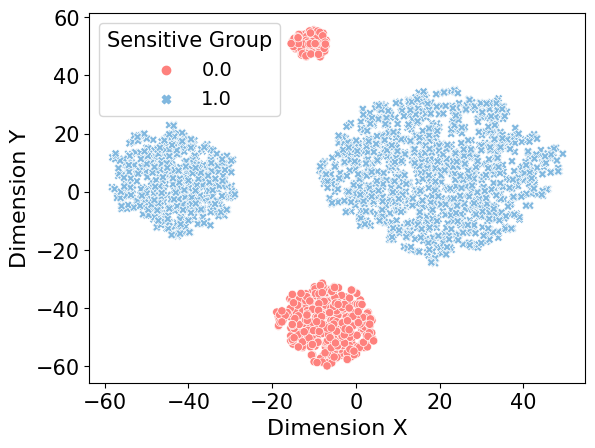

In [48]:
tsne_plot(x_n, y, sens_major, "tsne_biased_x_mul_main")

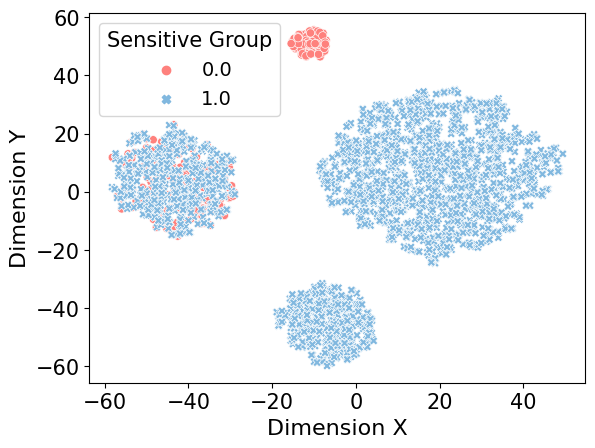

In [49]:
tsne_plot(x_n, y, sens_minor, "tsne_biased_x_mul_minor")

## Conclusion:

1. Normal features are highly associated with the sensitive attirbute.

In [50]:
unbiased_sample = MultivariateNormal(torch.tensor([0,1,0,1,0,1]).float(),torch.eye(6).float())

In [51]:
x_un = torch.tensor(unbiased_sample.sample())
for i in range(2500-1):
    x_un = torch.vstack((x_un, unbiased_sample.sample()))

In [52]:
x_un.shape

torch.Size([2500, 6])

In [53]:
unbiased_x_mul = torch.hstack((sens, x_un, y.unsqueeze(1))) # sens.unsqueeze(1)

In [54]:
unbiased_x_mul.shape

torch.Size([2500, 9])

In [52]:
torch.save(unbiased_x_mul, "./unbiased_x_mul.pt")

In [12]:
unbiased_x_mul = torch.load("./unbiased_x_mul.pt")

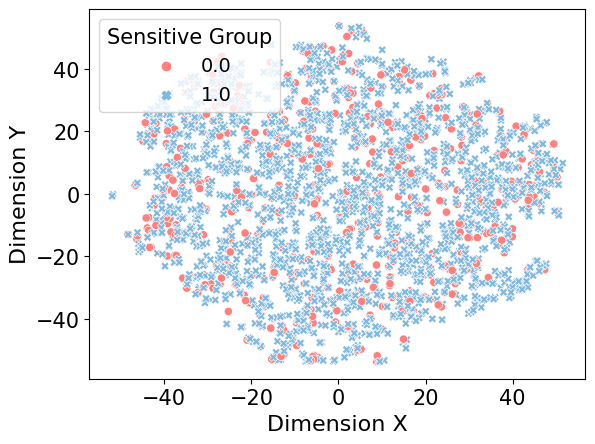

In [55]:
tsne_plot(x_un, y, sens_major, "tsne_unbiased_x_mul_main")

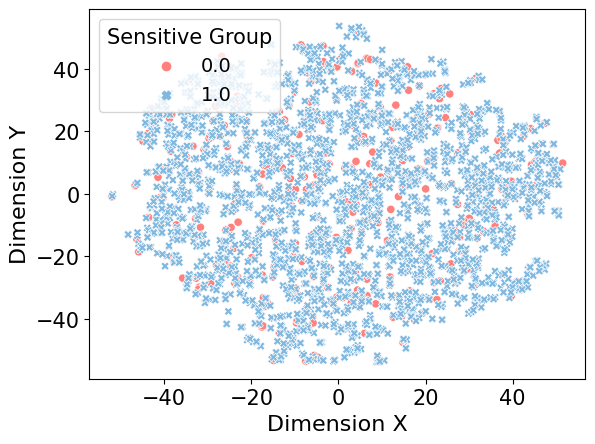

In [56]:
tsne_plot(x_un, y, sens_minor, "tsne_unbiased_x_mul_minor")

## Conclusion:

1. Put three figures, with/without sensitive attributes and topology overview.

In [63]:
import networkx as nx

In [63]:
biased_graph = nx.stochastic_block_model([500,2000],[[0.005,0.0000001],[0.0000001,0.005]], seed=10)

In [61]:
colors = {}
for i in range(2500):
    if sens_major[i] == 0:
        colors[i] = '#FE817D'
    elif sens_major[i] == 1:
        colors[i] = '#81B8DF'
        # ['#FE817D', '#81B8DF']

In [64]:
nx.set_node_attributes(biased_graph, colors, name="color")

In [65]:
pos = nx.kamada_kawai_layout(biased_graph)

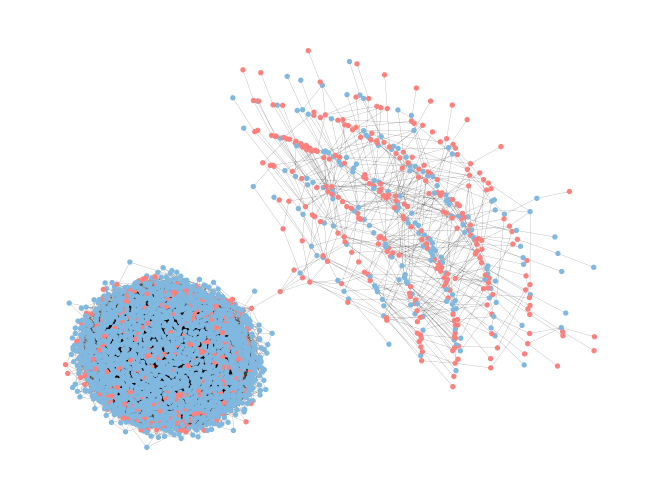

In [72]:
%matplotlib inline
nx.draw(biased_graph, pos=pos, node_size=8, width=0.08, node_color=list(colors.values()))
plt.savefig('biased_topology_major.png')
plt.show()

In [67]:
colors_m = {}
for i in range(2500):
    if sens_minor[i] == 0:
        colors_m[i] = '#FE817D'
    elif sens_minor[i] == 1:
        colors_m[i] = '#81B8DF'

In [68]:
nx.set_node_attributes(biased_graph, colors_m, name="color")

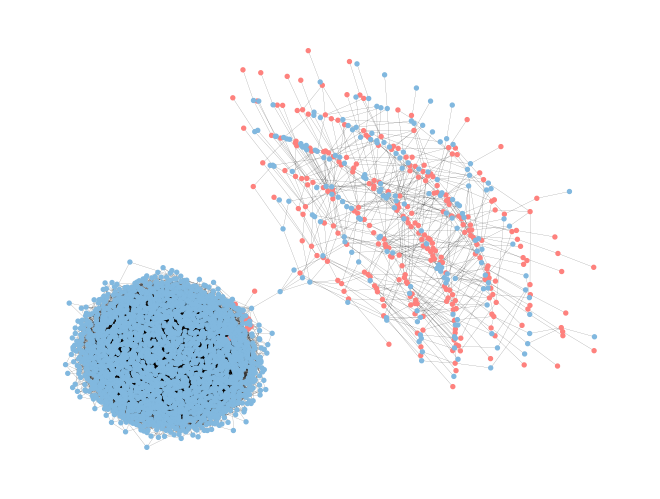

In [71]:
nx.draw(biased_graph, pos=pos, node_size=8, width=0.08, node_color=list(colors_m.values()))
plt.savefig('biased_topology_minor.png')
plt.show()

In [58]:
import pickle

In [70]:
pickle.dump(biased_graph, open('biased_graph.pickle', 'wb'))

In [59]:
biased_graph = pickle.load(open('biased_graph.pickle', 'rb'))

In [71]:
biased_edge = list(nx.edges(biased_graph))

In [72]:
biased_edge_index_syn = torch.tensor(biased_edge).t()

In [431]:
from torch_geometric.utils import to_scipy_sparse_matrix, dense_to_sparse

In [74]:
biased_adj = to_scipy_sparse_matrix(biased_edge_index_syn)
biased_adj = torch.tensor(biased_adj.todense())

In [75]:
biased_edge_index_syn.shape

torch.Size([2, 10696])

In [82]:
torch.save(biased_edge_index_syn, "./biased_edge_index_syn.pt")

In [92]:
torch.save(biased_adj, "./biased_adj.pt")

In [13]:
biased_edge_index_syn = torch.load("./biased_edge_index_syn.pt")

In [14]:
biased_adj = torch.load("./biased_adj.pt")

In [83]:
unbiased_graph = nx.random_geometric_graph(2500, 0.033, seed=10)

In [74]:
nx.set_node_attributes(unbiased_graph, colors, name="color")

In [75]:
pos1 = nx.kamada_kawai_layout(unbiased_graph)

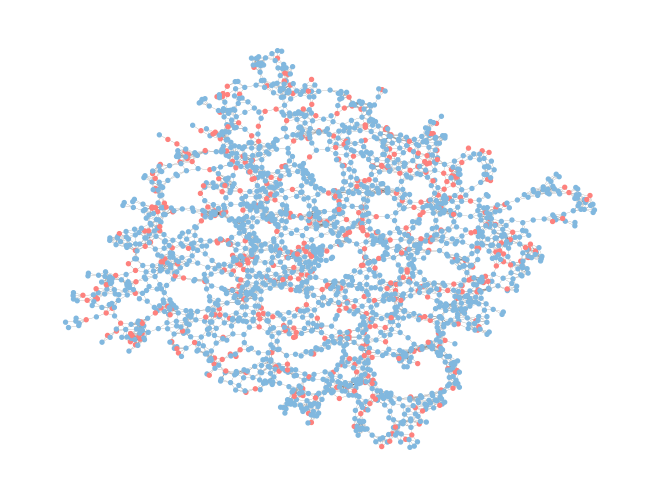

In [76]:
nx.draw(unbiased_graph, pos=pos1, node_size=8, width=0.08, node_color=list(colors.values()))
plt.savefig('unbiased_topology_major.png')
plt.show()

In [77]:
nx.set_node_attributes(unbiased_graph, colors_m, name="color")

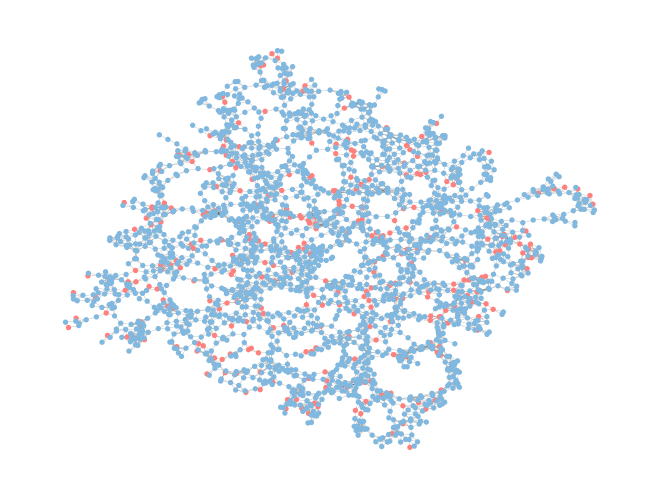

In [78]:
nx.draw(unbiased_graph, pos=pos1, node_size=8, width=0.08, node_color=list(colors_m.values()))
plt.savefig('unbiased_topology_minor.png')
plt.show()

In [87]:
pickle.dump(unbiased_graph, open('unbiased_graph.pickle', 'wb'))

In [73]:
unbiased_graph = pickle.load(open('unbiased_graph.pickle', 'rb'))

In [88]:
unbiased_edge = list(nx.edges(unbiased_graph))

In [89]:
unbiased_edge_index_syn = torch.tensor(unbiased_edge).t()

In [90]:
unbiased_edge_index_syn.shape

torch.Size([2, 10427])

In [91]:
unbiased_adj = to_scipy_sparse_matrix(unbiased_edge_index_syn)
unbiased_adj = torch.tensor(unbiased_adj.todense())

In [93]:
torch.save(unbiased_edge_index_syn, "./unbiased_edge_index_syn.pt")
torch.save(unbiased_adj, "./unbiased_adj.pt")

In [15]:
unbiased_edge_index_syn = torch.load("./unbiased_edge_index_syn.pt")
unbiased_adj = torch.load("./unbiased_adj.pt")

In [49]:
distance_correlation(unbiased_adj, sens.unsqueeze(1))

tensor(0.404489338397980)

In [50]:
distance_correlation(biased_adj, sens.unsqueeze(1))

tensor(0.423209577798843)

In [16]:
random.seed(10)
idx = list(range(2500))
random.shuffle(idx)

In [17]:
idx_train_syn = torch.tensor(idx[:int(0.1*len(idx))])

In [18]:
idx_val_syn = torch.tensor(idx[int(0.1*len(idx)): int(0.2*len(idx))])
idx_test_syn = torch.tensor(idx[int(0.2*len(idx)):])

In [19]:
def run_gnn_prim_syn(device, seed, model_name, data_name, runs, x, edge_index, k, sens, y, idx_train_syn, idx_val_syn, idx_test_syn, in_dim_g, hid_dim_g, out_dim_g, 
             LR, WD, dropout, epochs): # lambda_5, 
    # pbar = tqdm(range(runs), unit='run')
    # acc, f1, auc_roc, sp, eo = np.zeros(runs), np.zeros(runs), np.zeros(runs), np.zeros(runs), np.zeros(runs)
#     dist_cor_x = np.zeros(epochs)
#     dist_cor_y = np.zeros(epochs)
#     x_ori = data.x
#     x = feature_norm(x)
#     # x = data.x/data.x.norm(dim=0)
    x = x.to(device)
    edge_index = edge_index.to(device)
    y = y.to(device)
    sens = sens.to(device)
    train_mask = idx_train_syn.to(device)
    val_mask = idx_val_syn.to(device)
    test_mask = idx_test_syn.to(device)

    # Choose Model: MLP or other types of GNNs
#     if model_name == "MLP":
#         model = MLP_prim(in_dim_g, hid_dim_g, out_dim_g, dropout).to(device)
#     elif model_name == "GCN":
    model = GCN_prim(in_dim_g, hid_dim_g, out_dim_g, dropout).to(device)

    optimizer = torch.optim.Adam(model.parameters(), weight_decay=WD, lr=LR)
    seed_run(seed)
    # for count in pbar:
#         model.reset_parameters()
        
    best_val_loss = float('inf')
#         val_loss_history = []
#         best_val_trade_off = float('inf')
#         best_auc = 0
        
    for epoch in range(1, epochs+1):
            # train the model
        model.train()
        optimizer.zero_grad()
            
        output, emb = model(x, edge_index, k)
        cls_loss = F.binary_cross_entropy_with_logits(output[train_mask], y[train_mask].unsqueeze(1))
            # sens_loss = distance_corr(output[train_mask].unsqueeze(1), sens[train_mask].unsqueeze(1), control_term=control_term)
            # loss = cls_loss # + lambda_1*sens_loss
        cls_loss.backward()
        optimizer.step()
            # print('#'*100)
            # print(f'Epoch: {epoch:04d}, Loss: {cls_loss:.4f}')
            
        model.eval()
        output, emb = model(x, edge_index, k)
        pred = (output.squeeze() > 0).type_as(y)
        loss_val = F.binary_cross_entropy_with_logits(output[val_mask], y[val_mask].unsqueeze(1))
        accs_val, F1s_val, auc_rocs_val, sps_val, eos_val = evaluate_gnn(y, val_mask, sens[:,1], pred, output)
            # cls_loss_val = F.binary_cross_entropy_with_logits(output[val_mask], y[val_mask].unsqueeze(1))
            # sens_loss_val = distance_corr(output[val_mask].unsqueeze(1), sens[val_mask].unsqueeze(1), control_term=control_term)
            # loss_val = cls_loss_val # + lambda_1*sens_loss_val
        if loss_val <= best_val_loss:
            best_val_loss = loss_val.data
#             if auc_rocs_val >= best_auc:
#                 best_auc = auc_rocs_val
            accs_test, F1s_test, auc_rocs_test, sps_test, eos_test = evaluate_gnn(y, test_mask, sens[:,1], pred, output)
            sps_minor, eos_minor = fair_metric(pred[test_mask].cpu().numpy(), y[test_mask].cpu().numpy(), sens[:,0][test_mask].cpu().numpy())
                # print('#'*100)
                # print(f'Epoch: {epoch:03d}, AUC: {auc_rocs_test:.4f}, Accuracy: {accs_test:.4f}, F1: {F1s_test:.4f}, Statistical Parity: {sps_test:.4f}, Equal Opportunity: {eos_test:.4f}')

        # acc[count] = accs_test
        # f1[count] = F1s_test
        # auc_roc[count] = auc_rocs_test
        # sp[count] = sps_test
        # eo[count] = eos_test
    print('======' + data_name + '======')
    print('auc_roc:', auc_rocs_test * 100)
    print('Acc:', accs_test * 100)
    print('f1:', F1s_test * 100)
    print('parity:', sps_test * 100)
    print('equality:', eos_test * 100)
    print('parity minor:', sps_minor * 100)
    print('equality minor:', eos_minor * 100)
    dcor = distance_correlation(pred.detach().cpu().unsqueeze(1), sens.detach().cpu(), 1e-12)
    print('dcor:', dcor * 100)

    return accs_test, F1s_test, auc_rocs_test, sps_test, eos_test, sps_minor, eos_minor, dcor

In [20]:
def run_experiment_bias(device, seed, model_name, data_name, runs, x, edge_index, k, sens, y, idx_train_syn, idx_val_syn, idx_test_syn, in_dim_g, hid_dim_g, out_dim_g, 
             LR, WD, dropout, epochs):
    acc_run, f1_run, auc_roc_run, sp_run, eo_run, sp_minor, eo_minor, pred_dcor = [], [], [], [], [], [], [], []
    for sd in seed:
        acc, f1, auc_roc, sp, eo, spm, eom, dcor = run_gnn_prim_syn(device, sd, model_name, data_name, runs, x, edge_index, k, sens, y, idx_train_syn, idx_val_syn, idx_test_syn, in_dim_g, hid_dim_g, out_dim_g, 
             LR, WD, dropout, epochs)
        acc_run.append(acc)
        f1_run.append(f1)
        auc_roc_run.append(auc_roc)
        sp_run.append(sp)
        eo_run.append(eo)
        sp_minor.append(spm)
        eo_minor.append(eom)
        pred_dcor.append(dcor)
    print('======' + "This is the original result for " + data_name + '======')
    print('Accuracy:', np.mean(acc_run) * 100, np.std(acc_run) * 100)
    print('F1:', np.mean(f1_run) * 100, np.std(f1_run) * 100)
    print('AUROC:', np.mean(auc_roc_run) * 100, np.std(auc_roc_run) * 100)
    print('Statistical Parity:', np.mean(sp_run) * 100, np.std(sp_run) * 100)
    print('Equal of Opportunity:', np.mean(eo_run) * 100, np.std(eo_run) * 100)
    print('Statistical Parity Minor:', np.mean(sp_minor) * 100, np.std(sp_minor) * 100)
    print('Equal of Opportunity Minor:', np.mean(eo_minor) * 100, np.std(eo_minor) * 100)
    print('dCor_YS:', np.mean(pred_dcor) * 100, np.std(pred_dcor) * 100)
    return np.mean(acc_run), np.mean(f1_run), np.mean(auc_roc_run), np.mean(sp_run), np.mean(eo_run), np.mean(sp_minor), np.mean(eo_minor), np.mean(pred_dcor)

In [21]:
class GCN_prim(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, dropout=None):
        super(GCN_prim, self).__init__()
        self.conv1 = GCNConv(in_dim, hid_dim, dropout=None)
        self.conv2 = GCNConv(hid_dim, hid_dim, dropout)
        self.lin = nn.Linear(hid_dim, out_dim)
        
        for m in self.modules():
            self.weights_init(m)
        
    def weights_init(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight.data)
            if m.bias is not None:
                m.bias.data.fill_(0.0)
        
    def forward(self, x, edge_index, k, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight)
        if k >=2:
            for i in range(k-1):
                x = self.conv2(x, edge_index, edge_weight)
#         dist_lay1 = distance_correlation(x, sens.unsqueeze(1))
        emb = x
        x = self.lin(x)
#         dist_lay2 = distance_correlation(x, sens.unsqueeze(1))
        return x, emb   #, dist_lay1, dist_lay2

Topology: biased_adj, unbiased_adj;

Normal features: x, x_n, x_n_minor(biased), g_un(un_biased);

Sensitive features: sens_mul, sens, sens_minor;

Label: y;

Total: biased_x_mul(sens_minor[0],sens[1],x_n_minor[2,4],x_n[4,7],y[7]),unbiased_x_mul(sens_minor[0],sens[1],g_un[2,7],y[7])

device, model_name, data_name, runs, x, edge_index, k, sens, y, idx_train_syn, idx_val_syn, idx_test_syn, in_dim_g, hid_dim_g, out_dim_g, 
             LR, WD, dropout, epochs

#### Biased Feature and Unbiased Topology

In [28]:
x_n = biased_x_mul[:,2:8]

In [35]:
x_un = unbiased_x_mul[:,2:8]

In [30]:
sens = biased_x_mul[:,:2]

In [31]:
sens.shape

torch.Size([2500, 2])

In [32]:
y = biased_x_mul[:,8]

In [33]:
y

tensor([0., 0., 0.,  ..., 1., 1., 1.])

In [51]:
acc_adj_syn, f1_adj_syn, auc_roc_adj_syn, sp_adj_syn, eo_adj_syn, spm_adj_syn, eom_adj_syn, pred_adj_syn = run_experiment_bias(device=torch.device("cuda"), seed = list(range(2,12)), model_name="GCN", data_name="Synthetic", runs=1, x=x_n, edge_index=unbiased_edge_index_syn, k=2, sens=sens, y=y, idx_train_syn=idx_train_syn, idx_val_syn=idx_val_syn, idx_test_syn=idx_test_syn,
                                                       in_dim_g=6, hid_dim_g=16, out_dim_g=1, LR=0.01, WD=1e-5, dropout=None, epochs=1000)

======Synthetic======
auc_roc: 54.21147586110915
Acc: 56.10000000000001
f1: 66.41162968630452
parity: 28.973717146433042
equality: 36.350713243837916
parity minor: 15.865228135736242
equality minor: 7.694026753503824
dcor: tensor(26.587301254272461)
======Synthetic======
auc_roc: 56.2617235588657
Acc: 56.49999999999999
f1: 65.5035685963521
parity: 29.754543926176375
equality: 35.808054587258034
parity minor: 14.992465794707977
equality minor: 8.190999159297219
dcor: tensor(30.062664031982422)
======Synthetic======
auc_roc: 54.298970833985706
Acc: 57.05
f1: 66.69251647925552
parity: 29.58548932434199
equality: 36.38285248090188
parity minor: 16.293170996323305
equality minor: 9.917632410688636
dcor: tensor(26.349157333374023)
======Synthetic======
auc_roc: 53.66583469692458
Acc: 56.35
f1: 67.34006734006735
parity: 26.127809015000093
equality: 33.37659769091943
parity minor: 16.314869507564346
equality minor: 11.660760463557141
dcor: tensor(26.349157333374023)
======Synthetic======
auc_r

In [444]:
# acc_adj_syn1, f1_adj_syn1, auc_roc_adj_syn1, sp_adj_syn1, eo_adj_syn1, output_adj_syn1, pred_adj_syn1, emb_adj_syn1 = run_gnn_prim_syn(device=torch.device("cuda"), model_name="GCN", data_name="Synthetic", runs=1, x=unbiased_x[:,:3], edge_index=unbiased_edge_index_syn, k=1, sens=sens, y=y, idx_train_syn=idx_train_syn, idx_val_syn=idx_val_syn, idx_test_syn=idx_test_syn,
#                                                        in_dim_g=3, hid_dim_g=16, out_dim_g=1, LR=0.0003, WD=1e-5, dropout=None, epochs=200)



  0%|          | 0/1 [00:00<?, ?run/s]

####################################################################################################
Epoch: 0001, Loss: 0.7105
####################################################################################################
Epoch: 001, AUC: 0.4294, Accuracy: 0.5035, F1: 0.6626, Statistical Parity: 0.5099, Equal Opportunity: 0.5047
####################################################################################################
Epoch: 0002, Loss: 0.7101
####################################################################################################
Epoch: 002, AUC: 0.4293, Accuracy: 0.5020, F1: 0.6612, Statistical Parity: 0.5174, Equal Opportunity: 0.5130
####################################################################################################
Epoch: 0003, Loss: 0.7097
####################################################################################################
Epoch: 003, AUC: 0.4291, Accuracy: 0.4990, F1: 0.6585, Statistical Parity: 0.5323, Equal Opportuni



100%|██████████| 1/1 [00:06<00:00,  6.17s/run]

####################################################################################################
Epoch: 196, AUC: 0.4453, Accuracy: 0.5560, F1: 0.7119, Statistical Parity: 0.1610, Equal Opportunity: 0.1507
####################################################################################################
Epoch: 0197, Loss: 0.6833
####################################################################################################
Epoch: 197, AUC: 0.4458, Accuracy: 0.5550, F1: 0.7114, Statistical Parity: 0.1560, Equal Opportunity: 0.1507
####################################################################################################
Epoch: 0198, Loss: 0.6832
####################################################################################################
Epoch: 198, AUC: 0.4462, Accuracy: 0.5560, F1: 0.7122, Statistical Parity: 0.1511, Equal Opportunity: 0.1451
####################################################################################################
Epoch: 0199, Lo

In [52]:
acc_x_syn, f1_x_syn, auc_roc_x_syn, sp_x_syn, eo_x_syn, spm_x_syn, eom_x_syn, pred_x_syn = run_experiment_bias(device=torch.device("cuda"), seed = list(range(2,12)), model_name="GCN", data_name="Synthetic", runs=1, x=x_un, edge_index=biased_edge_index_syn, k=2, sens=sens, y=y, idx_train_syn=idx_train_syn, idx_val_syn=idx_val_syn, idx_test_syn=idx_test_syn,
                                                       in_dim_g=6, hid_dim_g=16, out_dim_g=1, LR=0.01, WD=1e-5, dropout=None, epochs=1000)

======Synthetic======
auc_roc: 62.44285964271351
Acc: 61.050000000000004
f1: 68.06068060680607
parity: 11.173170443153445
equality: 16.347334503531197
parity minor: 36.32812970887831
equality minor: 42.90670327448414
dcor: tensor(17.036516189575195)
======Synthetic======
auc_roc: 62.20339971694608
Acc: 60.8
f1: 67.816091954023
parity: 10.985435774818031
equality: 17.31192365695072
parity minor: 34.71159062142126
equality minor: 41.87498004661112
dcor: tensor(16.950756072998047)
======Synthetic======
auc_roc: 62.49116096107343
Acc: 61.25000000000001
f1: 68.93787575150301
parity: 12.186875385276375
equality: 18.835241085482124
parity minor: 36.125610270628655
equality minor: 43.60161329800253
dcor: tensor(16.976346969604492)
======Synthetic======
auc_roc: 62.479597297991496
Acc: 61.4
f1: 69.21850079744817
parity: 11.755054514660745
equality: 17.85458231353062
parity minor: 34.9333976252185
equality minor: 42.602879673083685
dcor: tensor(16.950756072998047)
======Synthetic======
auc_roc: 

In [442]:
# acc_x_syn1, f1_x_syn1, auc_roc_x_syn1, sp_x_syn1, eo_x_syn1, output_x_syn1, pred_x_syn1, emb_x_syn1 = run_gnn_prim_syn(device=torch.device("cuda"), model_name="GCN", data_name="Synthetic", runs=1, x=unbiased_x[:,1:3], edge_index=biased_edge_index_syn, k=1, sens=sens, y=y, idx_train_syn=idx_train_syn, idx_val_syn=idx_val_syn, idx_test_syn=idx_test_syn,
#                                                        in_dim_g=2, hid_dim_g=16, out_dim_g=1, LR=0.0003, WD=1e-5, dropout=None, epochs=300)



  0%|          | 0/1 [00:00<?, ?run/s]

####################################################################################################
Epoch: 0001, Loss: 0.7258
####################################################################################################
Epoch: 001, AUC: 0.5258, Accuracy: 0.5165, F1: 0.5437, Statistical Parity: 0.0805, Equal Opportunity: 0.0691
####################################################################################################
Epoch: 0002, Loss: 0.7253
####################################################################################################
Epoch: 002, AUC: 0.5258, Accuracy: 0.5165, F1: 0.5437, Statistical Parity: 0.0805, Equal Opportunity: 0.0691
####################################################################################################
Epoch: 0003, Loss: 0.7248
####################################################################################################
Epoch: 003, AUC: 0.5258, Accuracy: 0.5180, F1: 0.5457, Statistical Parity: 0.0786, Equal Opportuni



100%|██████████| 1/1 [00:09<00:00,  9.24s/run]

####################################################################################################
Epoch: 294, AUC: 0.5155, Accuracy: 0.5815, F1: 0.7354, Statistical Parity: 0.0000, Equal Opportunity: 0.0000
####################################################################################################
Epoch: 0295, Loss: 0.6827
####################################################################################################
Epoch: 295, AUC: 0.5154, Accuracy: 0.5815, F1: 0.7354, Statistical Parity: 0.0000, Equal Opportunity: 0.0000
####################################################################################################
Epoch: 0296, Loss: 0.6827
####################################################################################################
Epoch: 296, AUC: 0.5151, Accuracy: 0.5815, F1: 0.7354, Statistical Parity: 0.0000, Equal Opportunity: 0.0000
####################################################################################################
Epoch: 0297, Lo

In [50]:
acc_syn, f1_syn, auc_roc_syn, sp_syn, eo_syn, spm_syn, eom_syn, pred_syn = run_experiment_bias(device=torch.device("cuda"), seed = list(range(2,12)), model_name="GCN", data_name="Synthetic", runs=1, x=x_n, edge_index=biased_edge_index_syn, k=2, sens=sens, y=y, idx_train_syn=idx_train_syn, idx_val_syn=idx_val_syn, idx_test_syn=idx_test_syn,
                                                       in_dim_g=6, hid_dim_g=16, out_dim_g=1, LR=0.01, WD=1e-5, dropout=None, epochs=1000)

======Synthetic======
auc_roc: 78.18970342785859
Acc: 71.25
f1: 77.13717693836979
parity: 11.77964993555377
equality: 0.13432552926730956
parity minor: 36.03399433427762
equality minor: 18.972746331236902
dcor: tensor(27.734130859375000)
======Synthetic======
auc_roc: 78.21242142081604
Acc: 71.15
f1: 77.46973838344397
parity: 9.835055012795845
equality: 1.231592045950869
parity minor: 32.46338376228075
equality minor: 16.054230650533686
dcor: tensor(27.868026733398438)
======Synthetic======
auc_roc: 78.21866375221424
Acc: 71.45
f1: 77.09586843160851
parity: 12.533701953312292
equality: 0.4223425383404589
parity minor: 37.28045325779037
equality minor: 19.916142557651995
dcor: tensor(27.726188659667969)
======Synthetic======
auc_roc: 78.34044038113016
Acc: 71.35000000000001
f1: 76.96019300361881
parity: 12.597836848299181
equality: 0.8805326872522556
parity minor: 37.13820746187692
equality minor: 19.722993753259054
dcor: tensor(27.868026733398438)
======Synthetic======
auc_roc: 78.3422

In [434]:
# acc_syn1, f1_syn1, auc_roc_syn1, sp_syn1, eo_syn1, output_syn1, pred_syn1, emb_syn1 = run_gnn_prim_syn(device=torch.device("cuda"), model_name="GCN", data_name="Synthetic", runs=1, x=unbiased_x[:,:3], edge_index=biased_edge_index_syn, k=1, sens=sens, y=y, idx_train_syn=idx_train_syn, idx_val_syn=idx_val_syn, idx_test_syn=idx_test_syn,
                                                       # in_dim_g=3, hid_dim_g=16, out_dim_g=1, LR=0.001, WD=1e-5, dropout=None, epochs=300)



  0%|          | 0/1 [00:00<?, ?run/s]

####################################################################################################
Epoch: 0001, Loss: 0.7139
####################################################################################################
Epoch: 001, AUC: 0.4340, Accuracy: 0.4955, F1: 0.6567, Statistical Parity: 0.5479, Equal Opportunity: 0.5404
####################################################################################################
Epoch: 0002, Loss: 0.7126
####################################################################################################
Epoch: 002, AUC: 0.4338, Accuracy: 0.4925, F1: 0.6537, Statistical Parity: 0.5678, Equal Opportunity: 0.5598
####################################################################################################
Epoch: 0003, Loss: 0.7114
####################################################################################################
Epoch: 003, AUC: 0.4336, Accuracy: 0.4890, F1: 0.6502, Statistical Parity: 0.5902, Equal Opportuni



100%|██████████| 1/1 [00:09<00:00,  9.35s/run]

####################################################################################################
Epoch: 298, AUC: 0.5283, Accuracy: 0.5295, F1: 0.6831, Statistical Parity: 0.1214, Equal Opportunity: 0.1858
####################################################################################################
Epoch: 0299, Loss: 0.6710
####################################################################################################
Epoch: 299, AUC: 0.5283, Accuracy: 0.5290, F1: 0.6826, Statistical Parity: 0.1220, Equal Opportunity: 0.1870
####################################################################################################
Epoch: 0300, Loss: 0.6710
####################################################################################################
Epoch: 300, AUC: 0.5283, Accuracy: 0.5290, F1: 0.6826, Statistical Parity: 0.1220, Equal Opportunity: 0.1870
======Synthetic======
auc_roc: 52.83425327527066 0.0
Acc: 52.900000000000006 0.0
f1: 68.26145552560648 0.0
parity: 1

In [53]:
acc_syn_b, f1_syn_b, auc_roc_syn_b, sp_syn_b, eo_syn_b, spm_syn_b, eom_syn_b, pred_syn_b = run_experiment_bias(device=torch.device("cuda"), seed = list(range(2,12)), model_name="GCN", data_name="Synthetic", runs=1, x=x_un, edge_index=unbiased_edge_index_syn, k=2, sens=sens, y=y, idx_train_syn=idx_train_syn, idx_val_syn=idx_val_syn, idx_test_syn=idx_test_syn,
                                                       in_dim_g=6, hid_dim_g=16, out_dim_g=1, LR=0.01, WD=1e-5, dropout=None, epochs=1000)

======Synthetic======
auc_roc: 50.95471853737058
Acc: 56.10000000000001
f1: 69.21458625525946
parity: 3.705191190480639
equality: 5.875711801692662
parity minor: 6.686757880778737
equality minor: 7.919100980110461
dcor: tensor(12.678596496582031)
======Synthetic======
auc_roc: 48.930770498127806
Acc: 56.89999999999999
f1: 71.94010416666666
parity: 4.08501920933505
equality: 4.690268403833631
parity minor: 6.1322403712856355
equality minor: 5.589609339250179
dcor: tensor(12.678596496582031)
======Synthetic======
auc_roc: 54.575884748142386
Acc: 56.15
f1: 68.37360259646591
parity: 5.922203749712018
equality: 9.47077389634684
parity minor: 16.194322222891934
equality minor: 20.36682310123552
dcor: tensor(12.623199462890625)
======Synthetic======
auc_roc: 52.08949251892398
Acc: 57.199999999999996
f1: 71.82356813693221
parity: 4.759369610022479
equality: 5.932161487304999
parity minor: 6.13465131697909
equality minor: 7.184284178824929
dcor: tensor(11.735354423522949)
======Synthetic======


In [54]:
print("*" * 80)
print("Without unbiased features")
print(acc_adj_syn, f1_adj_syn, auc_roc_adj_syn, sp_adj_syn, eo_adj_syn, spm_adj_syn, eom_adj_syn, pred_adj_syn)
# print(acc_adj_syn1, f1_adj_syn1, auc_roc_adj_syn1, sp_adj_syn1, eo_adj_syn1)
print("*" * 80)
print("Without unbiased topology")
print(acc_x_syn, f1_x_syn, auc_roc_x_syn, sp_x_syn, eo_x_syn, spm_x_syn, eom_x_syn, pred_x_syn)
# print(acc_x_syn1, f1_x_syn1, auc_roc_x_syn1, sp_x_syn1, eo_x_syn1)
print("*" * 80)
print("Without unbiased features and topology")
print(acc_syn, f1_syn, auc_roc_syn, sp_syn, eo_syn, spm_syn, eom_syn, pred_syn)
print("*" * 80)
print("With unbiased features and topology")
print(acc_syn_b, f1_syn_b, auc_roc_syn_b, sp_syn_b, eo_syn_b, spm_syn_b, eom_syn_b, pred_syn_b)
# print(acc_syn1, f1_syn1, auc_roc_syn1, sp_syn1, eo_syn1)

********************************************************************************
Without unbiased features
0.5618500000000001 0.6602397104789317 0.5466715070318328 0.29174808062316704 0.3620237830354273 0.15428003134229407 0.08874362821781655 0.26762423
********************************************************************************
Without unbiased topology
0.6103500000000001 0.6872211666897265 0.6246286580317826 0.11905896051656614 0.1768696383099706 0.3593574829726961 0.4281651395673041 0.16977811
********************************************************************************
Without unbiased features and topology
0.71265 0.7711216880828261 0.7823481194720829 0.11618970230200684 0.006040940443521469 0.3582098728226147 0.18732720365226832 0.27513212
********************************************************************************
With unbiased features and topology
0.56595 0.6995716886271905 0.5241627345095521 0.060158842832147154 0.08415659225197161 0.10459044060032548 0.12593780927

In [22]:
from torch_geometric.utils import homophily

# Attribute Inference Attack

In [52]:
random.seed(33) #26-101
idx_l = list(range(2500)) #500
random.shuffle(idx_l)
idx_train_syn_l = torch.tensor(idx_l[:int(0.2*len(idx_l))])
idx_test_syn_l = torch.tensor(idx_l[int(0.2*len(idx_l)):])

In [53]:
len(idx_train_syn_l[idx_train_syn_l<500])

109

In [54]:
random.seed(13) #16 - 51
idx_n = list(range(2500))# 250
random.shuffle(idx_n)
idx_train_syn_n = torch.tensor(idx_n[:int(0.1*len(idx_n))])
idx_test_syn_n = torch.tensor(idx_n[int(0.1*len(idx_n)):])

In [55]:
len(idx_train_syn_n[idx_train_syn_n<500])

52

In [56]:
random.seed(21)
idx_s = list(range(2500))# 125
random.shuffle(idx_s)
idx_train_syn_s = torch.tensor(idx_s[:int(0.05*len(idx_s))])
idx_test_syn_s = torch.tensor(idx_s[int(0.05*len(idx_s)):])

In [57]:
len(idx_train_syn_s[idx_train_syn_s<500])

25

In [58]:
random.seed(23)
idx_xs = list(range(2500))# 50
random.shuffle(idx_xs)
idx_train_syn_xs = torch.tensor(idx_xs[:int(0.025*len(idx_xs))])
idx_test_syn_xs = torch.tensor(idx_xs[int(0.025*len(idx_xs)):])

In [59]:
len(idx_train_syn_xs[idx_train_syn_xs<500])

12

In [60]:
idx_train_syn_xs.shape

torch.Size([62])

In [61]:
random.seed(25)
idx_xxs = list(range(2500))# 12
random.shuffle(idx_xxs)
idx_train_syn_xxs = torch.tensor(idx_xxs[:int(0.0125*len(idx_xxs))])
idx_test_syn_xxs = torch.tensor(idx_xxs[int(0.0125*len(idx_xxs)):])

In [62]:
len(idx_train_syn_xxs[idx_train_syn_xxs<500])

6

In [63]:
idx_train_syn_xxs.shape

torch.Size([31])

In [64]:
random.seed(20)
idx_xxxs = list(range(2500))# 5
random.shuffle(idx_xxxs)
idx_train_syn_xxxs = torch.tensor(idx_xxxs[:int(0.00625*len(idx_xxxs))])
idx_test_syn_xxxs = torch.tensor(idx_xxxs[int(0.00625*len(idx_xxxs)):])

In [65]:
len(idx_train_syn_xxxs[idx_train_syn_xxxs<500])

3

In [66]:
idx_train_syn_xxxs.shape

torch.Size([15])

In [67]:
random.seed(35)
idx_xxxxs = list(range(2500))# 5
random.shuffle(idx_xxxxs)
idx_train_syn_xxxxs = torch.tensor(idx_xxxxs[:int(0.0032*len(idx_xxxxs))])
idx_test_syn_xxxxs = torch.tensor(idx_xxxxs[int(0.0032*len(idx_xxxxs)):])

In [68]:
len(idx_train_syn_xxxxs[idx_train_syn_xxxxs<500])

2

In [69]:
idx_train_syn_xxxxs.shape

torch.Size([8])

In [15]:
def evaluate_gnn(y, mask, sens, pred, output):
    pred = pred[mask].cpu().numpy()
    accs = metrics.accuracy_score(y[mask].cpu().numpy(), pred)
    F1s = metrics.f1_score(y[mask].cpu().numpy(), pred)
    auc_rocs = metrics.roc_auc_score(y[mask].cpu().numpy(), output[mask].detach().cpu().numpy()) # if mps, detach.().cpu().numpy()
    sps, eos = fair_metric(pred, y[mask].cpu().numpy(), sens[mask].cpu().numpy())
    return accs, F1s, auc_rocs, sps, eos

def fair_metric(pred, labels, sens):
    idx_s0 = sens==0
    idx_s1 = sens==1
    idx_s0_y1 = np.bitwise_and(idx_s0, labels==1)
    idx_s1_y1 = np.bitwise_and(idx_s1, labels==1)
    parity = abs(sum(pred[idx_s0])/sum(idx_s0)-sum(pred[idx_s1])/sum(idx_s1))
    equality = abs(sum(pred[idx_s0_y1])/sum(idx_s0_y1)-sum(pred[idx_s1_y1])/sum(idx_s1_y1))
    return parity.item(), equality.item()

In [71]:
class GCN(nn.Module):
    def __init__(self, input_dim:int, output_dim:int, dropout=None):
        super(GCN, self).__init__()
        self.lin1 = GCNConv(input_dim, 16, dropout)
        # self.dropout = nn.Dropout(dropout)
        # self.lin2 = nn.Linear(32, 16)
        # self.lin3 = nn.Linear(16, 8)
        self.lin4 = nn.Linear(16, 1)
        self.reset_parameters()
        
    def reset_parameters(self):
        self.lin1.reset_parameters()
        # self.lin2.reset_parameters()
        # self.lin3.reset_parameters()
        self.lin4.reset_parameters()
        
    def forward(self, x, edge_index):
        x = self.lin1(x, edge_index)
        # x = self.dropout(x)
        # x = self.lin2(x)
        # x = self.lin3(x)
        x = self.lin4(x)
        return x

In [72]:
def run_gcn(device, data_name, seed, x, edge_index, sens, in_dim_g, out_dim_g, idx_train, idx_test,
             LR, WD, epochs): # lambda_5, 
    # pbar = tqdm(range(runs), unit='run')
    # acc, f1, auc_roc, sp, eo = np.zeros(runs), np.zeros(runs), np.zeros(runs), np.zeros(runs), np.zeros(runs)

    
    x = x.to(device)
    edge_index = edge_index.to(device)
    # y = data.y.to(device)
    y = sens.to(device)
    sens = sens.to(device)
    train_mask = idx_train #.to(device)
    # val_mask = data.idx_val.to(device)
    test_mask = idx_test #.to(device)

    # Choose Model: MLP or other types of GNNs
#     if model_name == "MLP":
#         model = MLP_prim(in_dim_g, hid_dim_g, out_dim_g, dropout).to(device)
#     elif model_name == "GCN":
    model = GCN(in_dim_g, out_dim_g).to(device)

    optimizer = torch.optim.Adam(model.parameters(), weight_decay=WD, lr=LR)
    seed_run(seed)
    # for count in pbar:
#         model.reset_parameters()
        
    best_val_loss = float('inf')
#         val_loss_history = []
#         best_val_trade_off = float('inf')
#         best_auc = 0
        
    for epoch in range(1, epochs+1):
            # train the model
        model.train()
        optimizer.zero_grad()
            
        output = model(x, edge_index)
        cls_loss = F.binary_cross_entropy_with_logits(output.float()[train_mask], y.float()[train_mask].unsqueeze(1))
            # sens_loss = distance_corr(output[train_mask].unsqueeze(1), sens[train_mask].unsqueeze(1), control_term=control_term)
            # loss = cls_loss # + lambda_1*sens_loss
        cls_loss.backward()
        optimizer.step()
#         print('#'*100)
#         print(f'Epoch: {epoch:04d}, Loss: {cls_loss:.4f}')
            
        model.eval()
        output = model(x, edge_index)
        pred = (output.squeeze() > 0).type_as(y)
#             loss_val = F.binary_cross_entropy_with_logits(output[val_mask], y[val_mask].unsqueeze(1))
#             accs_val, F1s_val, auc_rocs_val, sps_val, eos_val = evaluate_gnn(y, val_mask, sens, pred, output)
#             # cls_loss_val = F.binary_cross_entropy_with_logits(output[val_mask], y[val_mask].unsqueeze(1))
#             # sens_loss_val = distance_corr(output[val_mask].unsqueeze(1), sens[val_mask].unsqueeze(1), control_term=control_term)
#             # loss_val = cls_loss_val # + lambda_1*sens_loss_val
#             if loss_val <= best_val_loss:
#                 best_val_loss = loss_val.data
# #             if auc_rocs_val >= best_auc:
# #                 best_auc = auc_rocs_val
        accs_test, F1s_test, auc_rocs_test, sps_test, eos_test = evaluate_gnn(y, test_mask, sens, pred, output)
            # print('#'*100)
            # print(f'Epoch: {epoch:03d}, AUC: {auc_rocs_test:.4f}, Accuracy: {accs_test:.4f}, F1: {F1s_test:.4f}, Statistical Parity: {sps_test:.4f}, Equal Opportunity: {eos_test:.4f}')
        att_acc = attack_acc(sens, pred)
        # acc[count] = accs_test
        # f1[count] = F1s_test
        # auc_roc[count] = auc_rocs_test
        # sp[count] = sps_test
        # eo[count] = eos_test
    print('======' + data_name + '======')
    print('auc_roc:', auc_rocs_test * 100)
    print('Acc:', accs_test * 100)
    print('f1:', F1s_test * 100)
    print('Attack Acc:', att_acc)
    # print('parity:', np.mean(sp) * 100, np.std(sp) * 100)
    # print('equality:', np.mean(eo) * 100, np.std(eo) * 100)

    return accs_test, F1s_test, auc_rocs_test, att_acc

In [146]:
y0 = y[sens==0]
y1 = y[sens==1]
y00 = y0[y0==0]
y11 = y1[y1==1]
attack_acc = abs(y00.shape[0]/y0.shape[0]-y11.shape[0]/y1.shape[0]).item()

AttributeError: 'float' object has no attribute 'item'

In [73]:
def attack_acc(sens, pred):
    # idx_s0 = sens==0
    # idx_s1 = sens==1
    # idx_s0_y1 = np.bitwise_and(idx_s0, pred==0)
    # idx_s1_y1 = np.bitwise_and(idx_s1, pred==1)
    # # parity = abs(sum(pred[idx_s0])/sum(idx_s0)-sum(pred[idx_s1])/sum(idx_s1))
    # equality = abs(sum(pred[idx_s0_y1])/sum(idx_s0)-sum(pred[idx_s1_y1])/sum(idx_s1))
    y0 = pred[sens==0]
    y1 = pred[sens==1]
    y00 = y0[y0==0]
    y11 = y1[y1==1]
    attack_acc = abs(y00.shape[0]/y0.shape[0]-y11.shape[0]/y1.shape[0])
    return attack_acc

In [126]:
attack_acc

0.4

In [74]:
def run_experiment(device, data_name, seed, x, edge_index, sens, in_dim_g, out_dim_g, idx_train, idx_test,
             LR, WD, epochs):
    acc_run, f1_run, auc_roc_run, att_run = [], [], [], []
    for sd in seed:
        acc, f1, auc_roc, att = run_gcn(device, data_name, sd, x, edge_index, sens, in_dim_g, out_dim_g, idx_train, idx_test,
             LR, WD, epochs)
        acc_run.append(acc)
        f1_run.append(f1)
        auc_roc_run.append(auc_roc)
        att_run.append(att)
        # sp_run.append(sp)
        # eo_run.append(eo)
    print('======' + "This is the original result for " + data_name + '======')
    print('Accuracy:', np.mean(acc_run) * 100, np.std(acc_run) * 100)
    print('F1:', np.mean(f1_run) * 100, np.std(f1_run) * 100)
    print('AUROC:', np.mean(auc_roc_run) * 100, np.std(auc_roc_run) * 100)
    print('Attack Accuracy:', np.mean(att_run) * 100, np.std(att_run) * 100)
    # print('Statistical Parity:', np.mean(sp_run) * 100, np.std(sp_run) * 100)
    # print('Equal of Opportunity:', np.mean(eo_run) * 100, np.std(eo_run) * 100)
    return acc_run, f1_run, auc_roc_run, att_run #, sp_run, eo_run

## Biased features and biased topology

In [218]:
biased_x_mul[:,2:].shape

torch.Size([2500, 7])

In [77]:
acc_xxxs, f1_xxxs, auc_roc_xxxs, att_xxxs = run_experiment(device=torch.device("cuda"), data_name="syn_xxxs", seed=list(range(2,12)), x=biased_x_mul[:,2:], edge_index=biased_edge_index_syn, sens=sens[:,1], in_dim_g=7, out_dim_g=1, idx_train=idx_train_syn_xxxs, idx_test=idx_test_syn_xxxs,
             LR=0.01, WD=1e-5, epochs=500)

======syn_xxxs======
auc_roc: 86.16024237867424
Acc: 87.80684104627767
f1: 92.80797531450273
Attack Acc: 0.526
======syn_xxxs======
auc_roc: 86.3745874287285
Acc: 88.00804828973843
f1: 92.8979980934223
Attack Acc: 0.501
======syn_xxxs======
auc_roc: 86.44745059755883
Acc: 87.88732394366198
f1: 92.84185493460166
Attack Acc: 0.5145
======syn_xxxs======
auc_roc: 86.3340629756065
Acc: 88.32997987927565
f1: 93.08206106870229
Attack Acc: 0.49
======syn_xxxs======
auc_roc: 86.44088179593058
Acc: 88.24949698189135
f1: 93.03102625298331
Attack Acc: 0.489
======syn_xxxs======
auc_roc: 86.41127165936014
Acc: 88.2897384305835
f1: 93.03994259746473
Attack Acc: 0.477
======syn_xxxs======
auc_roc: 86.40945260660155
Acc: 88.00804828973843
f1: 92.9047619047619
Attack Acc: 0.506
======syn_xxxs======
auc_roc: 86.13851480405769
Acc: 88.12877263581488
f1: 92.98120390197478
Attack Acc: 0.5075000000000001
======syn_xxxs======
auc_roc: 86.28787924723554
Acc: 88.04828973843058
f1: 92.93697978596909
Attack Acc:

In [78]:
np.mean(acc_xxxs), np.mean(f1_xxxs), np.mean(auc_roc_xxxs), np.mean(att_xxxs)

(0.8806036217303823, 0.929326473063153, 0.8633391138787662, 0.50265)

In [79]:
acc_xxxs_m, f1_xxxs_m, auc_roc_xxxs_m, att_xxxs_m = run_experiment(device=torch.device("cuda"), data_name="syn_xxxs", seed=list(range(2,12)), x=biased_x_mul[:,2:], edge_index=biased_edge_index_syn, sens=sens[:,0], in_dim_g=7, out_dim_g=1, idx_train=idx_train_syn_xxxs, idx_test=idx_test_syn_xxxs,
             LR=0.01, WD=1e-5, epochs=500)

======syn_xxxs======
auc_roc: 97.54151532861903
Acc: 95.1307847082495
f1: 97.29245916312374
Attack Acc: 0.3578787878787878
======syn_xxxs======
auc_roc: 98.70978895800884
Acc: 96.13682092555332
f1: 97.83197831978319
Attack Acc: 0.24424242424242426
======syn_xxxs======
auc_roc: 94.8957641666182
Acc: 93.56136820925553
f1: 96.43811219946572
Attack Acc: 0.45757575757575764
======syn_xxxs======
auc_roc: 96.87889182300256
Acc: 95.17102615694165
f1: 97.2875226039783
Attack Acc: 0.2712121212121211
======syn_xxxs======
auc_roc: 96.74440877949372
Acc: 94.44668008048289
f1: 96.89608636977057
Attack Acc: 0.33878787878787886
======syn_xxxs======
auc_roc: 97.36725345540336
Acc: 95.2112676056338
f1: 97.31073446327683
Attack Acc: 0.2716666666666666
======syn_xxxs======
auc_roc: 97.63346562344135
Acc: 95.33199195171026
f1: 97.39325842696628
Attack Acc: 0.3146969696969697
======syn_xxxs======
auc_roc: 96.85640148466832
Acc: 93.80281690140845
f1: 96.58233466489125
Attack Acc: 0.47545454545454546
======sy

In [81]:
np.mean(acc_xxxs_m), np.mean(f1_xxxs_m), np.mean(auc_roc_xxxs_m), np.mean(att_xxxs_m)

(0.9461971830985915,
 0.9700198486504913,
 0.9675947883613263,
 0.3528636363636364)

In [82]:
acc_xxxsut, f1_xxxsut, auc_roc_xxxsut, att_xxxsut = run_experiment(device=torch.device("cuda"), data_name="syn_xxxs", seed=list(range(2,12)), x=biased_x_mul[:,2:], edge_index=unbiased_edge_index_syn, sens=sens[:,1], in_dim_g=7, out_dim_g=1, idx_train=idx_train_syn_xxxs, idx_test=idx_test_syn_xxxs,
             LR=0.01, WD=1e-5, epochs=500)

======syn_xxxs======
auc_roc: 81.45708147133071
Acc: 86.76056338028168
f1: 92.11598370476875
Attack Acc: 0.49550000000000005
======syn_xxxs======
auc_roc: 80.63638550174528
Acc: 85.27162977867204
f1: 91.18072289156626
Attack Acc: 0.4945
======syn_xxxs======
auc_roc: 79.66511238714293
Acc: 85.59356136820927
f1: 91.48024750118992
Attack Acc: 0.5535000000000001
======syn_xxxs======
auc_roc: 81.4827503269242
Acc: 86.80080482897384
f1: 92.16435738174869
Attack Acc: 0.5109999999999999
======syn_xxxs======
auc_roc: 80.14938465487515
Acc: 81.93158953722333
f1: 88.85579548275005
Attack Acc: 0.40549999999999997
======syn_xxxs======
auc_roc: 80.80939763078484
Acc: 84.50704225352112
f1: 90.64398541919807
Attack Acc: 0.46499999999999997
======syn_xxxs======
auc_roc: 81.31650911648607
Acc: 86.03621730382294
f1: 91.6646649051165
Attack Acc: 0.4965
======syn_xxxs======
auc_roc: 81.04061944809939
Acc: 86.0764587525151
f1: 91.69467114738359
Attack Acc: 0.4995
======syn_xxxs======
auc_roc: 80.20405729611

In [83]:
np.mean(acc_xxxsut), np.mean(f1_xxxsut), np.mean(auc_roc_xxxsut), np.mean(att_xxxsut)

(0.8552112676056337,
 0.9132625484967823,
 0.8088090661589489,
 0.49335000000000007)

In [84]:
acc_xxxsut_m, f1_xxxsut_m, auc_roc_xxxsut_m, att_xxxsut_m = run_experiment(device=torch.device("cuda"), data_name="syn_xxxs", seed=list(range(2,12)), x=biased_x_mul[:,2:], edge_index=unbiased_edge_index_syn, sens=sens[:,0], in_dim_g=7, out_dim_g=1, idx_train=idx_train_syn_xxxs, idx_test=idx_test_syn_xxxs,
             LR=0.01, WD=1e-5, epochs=500)

======syn_xxxs======
auc_roc: 97.29121469246375
Acc: 93.9235412474849
f1: 96.5022006022701
Attack Acc: 0.11318181818181816
======syn_xxxs======
auc_roc: 98.10132585899322
Acc: 94.36619718309859
f1: 96.72897196261682
Attack Acc: 0.027272727272727226
======syn_xxxs======
auc_roc: 97.329310571683
Acc: 93.8430583501006
f1: 96.44764337125609
Attack Acc: 0.09712121212121205
======syn_xxxs======
auc_roc: 97.57961120783828
Acc: 93.36016096579478
f1: 96.13311460042185
Attack Acc: 0.03863636363636358
======syn_xxxs======
auc_roc: 97.21150403755122
Acc: 93.31991951710262
f1: 96.1323392357875
Attack Acc: 0.0874242424242424
======syn_xxxs======
auc_roc: 97.77024359943329
Acc: 94.32595573440643
f1: 96.72473867595819
Attack Acc: 0.07606060606060605
======syn_xxxs======
auc_roc: 97.24011419584035
Acc: 92.99798792756539
f1: 95.93837535014006
Attack Acc: 0.08378787878787874
======syn_xxxs======
auc_roc: 97.63836147940528
Acc: 94.36619718309859
f1: 96.7577582213988
Attack Acc: 0.09924242424242424
======s

In [85]:
np.mean(acc_xxxsut_m), np.mean(f1_xxxsut_m), np.mean(auc_roc_xxxsut_m), np.mean(att_xxxsut_m)

(0.937867203219316, 0.9640589754706799, 0.9747869537678202, 0.0794393939393939)

In [86]:
acc_xxs, f1_xxs, auc_roc_xxs, att_xxs = run_experiment(device=torch.device("cuda"), data_name="syn_xxs", seed=list(range(2,12)), x=biased_x_mul[:,2:], edge_index=biased_edge_index_syn, sens=sens[:,1], in_dim_g=7, out_dim_g=1, idx_train=idx_train_syn_xxs, idx_test=idx_test_syn_xxs,
             LR=0.01, WD=1e-5, epochs=500)

======syn_xxs======
auc_roc: 81.97708608345566
Acc: 76.14418793033617
f1: 83.99891333876664
Attack Acc: 0.10249999999999992
======syn_xxs======
auc_roc: 83.93291140802151
Acc: 83.63710004050223
f1: 89.63039014373715
Attack Acc: 0.23449999999999993
======syn_xxs======
auc_roc: 81.83161232219301
Acc: 74.80761441879304
f1: 82.79867256637169
Attack Acc: 0.04400000000000004
======syn_xxs======
auc_roc: 82.03260257185273
Acc: 75.61765897124342
f1: 83.45244639912039
Attack Acc: 0.056499999999999995
======syn_xxs======
auc_roc: 81.91889657895062
Acc: 75.05062778452815
f1: 82.99282164549972
Attack Acc: 0.04700000000000004
======syn_xxs======
auc_roc: 81.82729437309547
Acc: 74.76711219117051
f1: 82.76625172890733
Attack Acc: 0.04349999999999998
======syn_xxs======
auc_roc: 81.98788095619955
Acc: 75.86067233697852
f1: 83.67123287671234
Attack Acc: 0.06700000000000006
======syn_xxs======
auc_roc: 83.09779949089324
Acc: 81.57148643175375
f1: 88.14177743028408
Attack Acc: 0.19899999999999995
======s

In [87]:
np.mean(acc_xxs), np.mean(f1_xxs), np.mean(auc_roc_xxs), np.mean(att_xxs)

(0.7749696233292831, 0.8492282714396463, 0.8239564956347589, 0.1051)

In [88]:
acc_xxs_m, f1_xxs_m, auc_roc_xxs_m, att_xxs_m = run_experiment(device=torch.device("cuda"), data_name="syn_xxs", seed=list(range(2,12)), x=biased_x_mul[:,2:], edge_index=biased_edge_index_syn, sens=sens[:,0], in_dim_g=7, out_dim_g=1, idx_train=idx_train_syn_xxs, idx_test=idx_test_syn_xxs,
             LR=0.01, WD=1e-5, epochs=500)

======syn_xxs======
auc_roc: 99.54936101344943
Acc: 97.93438639125152
f1: 98.81643072638663
Attack Acc: 0.007121212121212084
======syn_xxs======
auc_roc: 99.5873405633995
Acc: 98.17739975698665
f1: 98.95324494068389
Attack Acc: 0.020454545454545503
======syn_xxs======
auc_roc: 99.00540084702148
Acc: 96.23329283110571
f1: 97.87234042553192
Attack Acc: 0.18499999999999994
======syn_xxs======
auc_roc: 99.20925026818213
Acc: 96.92183070068853
f1: 98.25528007346189
Attack Acc: 0.13212121212121208
======syn_xxs======
auc_roc: 99.26986252953105
Acc: 97.20534629404617
f1: 98.41050449205254
Attack Acc: 0.09363636363636363
======syn_xxs======
auc_roc: 99.43170191788975
Acc: 97.48886188740381
f1: 98.56415006947663
Attack Acc: 0.040000000000000036
======syn_xxs======
auc_roc: 99.57137365056333
Acc: 98.25840421223168
f1: 99.00255161215495
Attack Acc: 0.0006060606060604989
======syn_xxs======
auc_roc: 99.61601899907609
Acc: 98.0963953017416
f1: 98.90773878689288
Attack Acc: 0.010000000000000009
====

In [89]:
np.mean(acc_xxs_m), np.mean(f1_xxs_m), np.mean(auc_roc_xxs_m), np.mean(att_xxs_m)

(0.974645605508303,
 0.9855635292650448,
 0.9938809519380423,
 0.06859090909090906)

In [90]:
acc_xxsut, f1_xxsut, auc_roc_xxsut, att_xxsut = run_experiment(device=torch.device("cuda"), data_name="syn_xxs", seed=list(range(2,12)), x=biased_x_mul[:,2:], edge_index=unbiased_edge_index_syn, sens=sens[:,1], in_dim_g=7, out_dim_g=1, idx_train=idx_train_syn_xxs, idx_test=idx_test_syn_xxs,
             LR=0.01, WD=1e-5, epochs=500)

======syn_xxs======
auc_roc: 73.21072414062532
Acc: 69.94734710409072
f1: 79.22732362821947
Attack Acc: 0.08050000000000002
======syn_xxs======
auc_roc: 72.54205888037635
Acc: 70.19036046982585
f1: 79.48717948717949
Attack Acc: 0.09599999999999997
======syn_xxs======
auc_roc: 72.70829992063199
Acc: 70.1093560145808
f1: 79.40848214285712
Attack Acc: 0.09250000000000003
======syn_xxs======
auc_roc: 72.18665054632338
Acc: 70.06885378695829
f1: 79.43222933481769
Attack Acc: 0.10450000000000004
======syn_xxs======
auc_roc: 73.32998178236714
Acc: 69.94734710409072
f1: 79.25055928411633
Attack Acc: 0.08350000000000002
======syn_xxs======
auc_roc: 73.09341985680858
Acc: 69.98784933171325
f1: 79.29589270746017
Attack Acc: 0.08650000000000002
======syn_xxs======
auc_roc: 72.93221642383342
Acc: 69.86634264884569
f1: 79.1829882484611
Attack Acc: 0.08250000000000002
======syn_xxs======
auc_roc: 72.388360454166
Acc: 70.06885378695829
f1: 79.40930621342991
Attack Acc: 0.09950000000000003
======syn_xx

In [91]:
np.mean(acc_xxsut), np.mean(f1_xxsut), np.mean(auc_roc_xxsut), np.mean(att_xxsut)

(0.7002430133657351,
 0.7933758059399451,
 0.7278380234485198,
 0.09065000000000001)

In [92]:
acc_xxsut_m, f1_xxsut_m, auc_roc_xxsut_m, att_xxsut_m = run_experiment(device=torch.device("cuda"), data_name="syn_xxs", seed=list(range(2,12)), x=biased_x_mul[:,2:], edge_index=unbiased_edge_index_syn, sens=sens[:,0], in_dim_g=7, out_dim_g=1, idx_train=idx_train_syn_xxs, idx_test=idx_test_syn_xxs,
             LR=0.01, WD=1e-5, epochs=500)

======syn_xxs======
auc_roc: 94.30709799033924
Acc: 92.10206561360876
f1: 95.54692852249373
Attack Acc: 0.34696969696969693
======syn_xxs======
auc_roc: 94.58442621426047
Acc: 92.30457675172134
f1: 95.60592044403332
Attack Acc: 0.2356060606060606
======syn_xxs======
auc_roc: 93.5919973212791
Acc: 91.575536654516
f1: 95.2183908045977
Attack Acc: 0.3107575757575758
======syn_xxs======
auc_roc: 93.81770436098246
Acc: 91.81855002025111
f1: 95.34347625633932
Attack Acc: 0.2793939393939394
======syn_xxs======
auc_roc: 93.48766982284478
Acc: 91.69704333738355
f1: 95.28193325661681
Attack Acc: 0.296969696969697
======syn_xxs======
auc_roc: 94.24881100755871
Acc: 92.1830700688538
f1: 95.54786620530564
Attack Acc: 0.26075757575757574
======syn_xxs======
auc_roc: 93.86250472806641
Acc: 91.73754556500607
f1: 95.30386740331491
Attack Acc: 0.2936363636363636
======syn_xxs======
auc_roc: 94.2205976275958
Acc: 92.06156338598623
f1: 95.52102376599633
Attack Acc: 0.34272727272727277
======syn_xxs======


In [93]:
np.mean(acc_xxsut_m), np.mean(f1_xxsut_m), np.mean(auc_roc_xxsut_m), np.mean(att_xxsut_m)

(0.9191575536654517,
 0.9541212549250104,
 0.9406184310880443,
 0.2998030303030303)

In [94]:
acc_xs, f1_xs, auc_roc_xs, att_xs = run_experiment(device=torch.device("cuda"), data_name="syn_xs", seed=list(range(2,12)), x=biased_x_mul[:,2:], edge_index=biased_edge_index_syn, sens=sens[:,1], in_dim_g=7, out_dim_g=1, idx_train=idx_train_syn_xs, idx_test=idx_test_syn_xs,
             LR=0.01, WD=1e-5, epochs=500)

======syn_xs======
auc_roc: 80.31626517085475
Acc: 82.85479901558655
f1: 89.34760448521916
Attack Acc: 0.352
======syn_xs======
auc_roc: 81.55123334183226
Acc: 84.16735028712058
f1: 90.24759979787773
Attack Acc: 0.37049999999999994
======syn_xs======
auc_roc: 79.90086678607142
Acc: 82.40360951599672
f1: 89.04214559386972
Attack Acc: 0.349
======syn_xs======
auc_roc: 79.9801901452268
Acc: 82.6086956521739
f1: 89.17815211842778
Attack Acc: 0.349
======syn_xs======
auc_roc: 79.86141495665021
Acc: 82.32157506152585
f1: 88.97980056251598
Attack Acc: 0.3454999999999999
======syn_xs======
auc_roc: 79.91576614718261
Acc: 82.40360951599672
f1: 89.04774061781977
Attack Acc: 0.3514999999999999
======syn_xs======
auc_roc: 80.11722229741852
Acc: 82.77276456111566
f1: 89.28571428571428
Attack Acc: 0.3484999999999999
======syn_xs======
auc_roc: 80.69798260552052
Acc: 83.42904019688268
f1: 89.73055414336551
Attack Acc: 0.354
======syn_xs======
auc_roc: 79.93433788603248
Acc: 82.52666119770304
f1: 89.1

In [95]:
np.mean(acc_xs), np.mean(f1_xs), np.mean(auc_roc_xs), np.mean(att_xs)

(0.8286710418375718,
 0.8935429823357814,
 0.8029076837684052,
 0.35189999999999994)

In [96]:
acc_xs_m, f1_xs_m, auc_roc_xs_m, att_xs_m = run_experiment(device=torch.device("cuda"), data_name="syn_xs", seed=list(range(2,12)), x=biased_x_mul[:,2:], edge_index=biased_edge_index_syn, sens=sens[:,0], in_dim_g=7, out_dim_g=1, idx_train=idx_train_syn_xs, idx_test=idx_test_syn_xs,
             LR=0.01, WD=1e-5, epochs=500)

======syn_xs======
auc_roc: 99.50672803176346
Acc: 98.48236259228877
f1: 99.13206661975134
Attack Acc: 0.0016666666666667052
======syn_xs======
auc_roc: 99.45055471153724
Acc: 98.11320754716981
f1: 98.92120075046905
Attack Acc: 0.013181818181818183
======syn_xs======
auc_roc: 99.00611523190645
Acc: 96.8416735028712
f1: 98.19967266775778
Attack Acc: 0.08242424242424251
======syn_xs======
auc_roc: 99.01074314749327
Acc: 96.80065627563576
f1: 98.17671809256663
Attack Acc: 0.08575757575757581
======syn_xs======
auc_roc: 99.30166349627852
Acc: 97.66201804757998
f1: 98.66541793490985
Attack Acc: 0.04227272727272735
======syn_xs======
auc_roc: 99.27277891968491
Acc: 97.45693191140279
f1: 98.54868913857679
Attack Acc: 0.05136363636363628
======syn_xs======
auc_roc: 99.42071263516706
Acc: 97.94913863822805
f1: 98.82849109653233
Attack Acc: 0.02651515151515149
======syn_xs======
auc_roc: 99.52970802640147
Acc: 98.31829368334701
f1: 99.03733270720826
Attack Acc: 0.003484848484848535
======syn_xs=

In [97]:
np.mean(acc_xs_m), np.mean(f1_xs_m), np.mean(auc_roc_xs_m), np.mean(att_xs_m)

(0.9769893355209188,
 0.9868660788571845,
 0.9930981820270908,
 0.03954545454545457)

In [100]:
acc_xsut, f1_xsut, auc_roc_xsut, att_xsut = run_experiment(device=torch.device("cuda"), data_name="syn_xs", seed=list(range(2,12)), x=biased_x_mul[:,2:], edge_index=unbiased_edge_index_syn, sens=sens[:,1], in_dim_g=7, out_dim_g=1, idx_train=idx_train_syn_xs, idx_test=idx_test_syn_xs,
             LR=0.01, WD=1e-5, epochs=500)

======syn_xs======
auc_roc: 69.25118119406837
Acc: 76.94831829368334
f1: 85.62659846547315
Attack Acc: 0.43950000000000006
======syn_xs======
auc_roc: 69.52041894485244
Acc: 77.07136997538966
f1: 85.69966743412637
Attack Acc: 0.436
======syn_xs======
auc_roc: 68.88153014340111
Acc: 76.53814602132896
f1: 85.33333333333333
Attack Acc: 0.43450000000000005
======syn_xs======
auc_roc: 69.08697344661044
Acc: 76.78424938474159
f1: 85.50204918032787
Attack Acc: 0.435
======syn_xs======
auc_roc: 68.84333741491886
Acc: 76.41509433962264
f1: 85.24506030279701
Attack Acc: 0.435
======syn_xs======
auc_roc: 68.84113398827567
Acc: 76.41509433962264
f1: 85.24506030279701
Attack Acc: 0.435
======syn_xs======
auc_roc: 69.27111695893547
Acc: 76.90730106644791
f1: 85.597339473011
Attack Acc: 0.439
======syn_xs======
auc_roc: 69.19945313049219
Acc: 76.90730106644791
f1: 85.58996672638854
Attack Acc: 0.43650000000000005
======syn_xs======
auc_roc: 69.13912121049964
Acc: 76.78424938474159
f1: 85.509472606246

In [101]:
np.mean(acc_xsut), np.mean(f1_xsut), np.mean(auc_roc_xsut), np.mean(att_xsut)

(0.767842493847416, 0.8550482152586275, 0.6916491179473298, 0.4364)

In [102]:
acc_xsut_m, f1_xsut_m, auc_roc_xsut_m, att_xsut_m = run_experiment(device=torch.device("cuda"), data_name="syn_xs", seed=list(range(2,12)), x=biased_x_mul[:,2:], edge_index=unbiased_edge_index_syn, sens=sens[:,0], in_dim_g=7, out_dim_g=1, idx_train=idx_train_syn_xs, idx_test=idx_test_syn_xs,
             LR=0.01, WD=1e-5, epochs=500)

======syn_xs======
auc_roc: 98.7078540515007
Acc: 95.40607054963085
f1: 97.33587059942911
Attack Acc: 0.005454545454545379
======syn_xs======
auc_roc: 98.7204611318924
Acc: 95.24200164068908
f1: 97.2328244274809
Attack Acc: 0.022424242424242458
======syn_xs======
auc_roc: 98.37193121321606
Acc: 94.05250205086136
f1: 96.52694610778441
Attack Acc: 0.012878787878787934
======syn_xs======
auc_roc: 98.41884870226862
Acc: 94.21657095980311
f1: 96.62437155853483
Attack Acc: 0.014848484848484889
======syn_xs======
auc_roc: 98.572048666522
Acc: 94.62674323215751
f1: 96.8682763566818
Attack Acc: 0.01787878787878794
======syn_xs======
auc_roc: 98.84222318681459
Acc: 96.18539786710419
f1: 97.79149845642365
Attack Acc: 0.019545454545454533
======syn_xs======
auc_roc: 98.62694532037942
Acc: 94.95488105004102
f1: 97.06513958482464
Attack Acc: 0.014242424242424279
======syn_xs======
auc_roc: 98.64433989965403
Acc: 95.20098441345365
f1: 97.21362229102168
Attack Acc: 0.007727272727272694
======syn_xs===

In [103]:
np.mean(acc_xsut_m), np.mean(f1_xsut_m), np.mean(auc_roc_xsut_m), np.mean(att_xsut_m)

(0.9505742411812962,
 0.9712512644956812,
 0.9861896615557455,
 0.013863636363636378)

In [104]:
acc_s, f1_s, auc_roc_s, att_s = run_experiment(device=torch.device("cuda"), data_name="syn_s", seed=list(range(2,12)), x=biased_x_mul[:,2:], edge_index=biased_edge_index_syn, sens=sens[:,1], in_dim_g=7, out_dim_g=1, idx_train=idx_train_syn_s, idx_test=idx_test_syn_s,
             LR=0.01, WD=1e-5, epochs=500)

======syn_s======
auc_roc: 85.72303321250125
Acc: 87.83157894736841
f1: 92.59543940558544
Attack Acc: 0.34850000000000003
======syn_s======
auc_roc: 86.13529485112713
Acc: 88.08421052631579
f1: 92.76029675108724
Attack Acc: 0.35150000000000003
======syn_s======
auc_roc: 85.71034138781762
Acc: 87.83157894736841
f1: 92.59543940558544
Attack Acc: 0.34850000000000003
======syn_s======
auc_roc: 85.71134337397686
Acc: 87.83157894736841
f1: 92.59543940558544
Attack Acc: 0.34850000000000003
======syn_s======
auc_roc: 85.70967339704481
Acc: 87.83157894736841
f1: 92.59543940558544
Attack Acc: 0.34850000000000003
======syn_s======
auc_roc: 85.70889407447653
Acc: 87.83157894736841
f1: 92.59543940558544
Attack Acc: 0.34850000000000003
======syn_s======
auc_roc: 85.71334734629532
Acc: 87.83157894736841
f1: 92.59543940558544
Attack Acc: 0.34850000000000003
======syn_s======
auc_roc: 85.98065498721911
Acc: 88.0421052631579
f1: 92.73285568065506
Attack Acc: 0.351
======syn_s======
auc_roc: 85.710341387

In [105]:
np.mean(acc_s), np.mean(f1_s), np.mean(auc_roc_s), np.mean(att_s)

(0.8788210526315788, 0.9262841790905124, 0.857871436269227, 0.3491000000000001)

In [106]:
acc_s_m, f1_s_m, auc_roc_s_m, att_s_m = run_experiment(device=torch.device("cuda"), data_name="syn_s", seed=list(range(2,12)), x=biased_x_mul[:,2:], edge_index=biased_edge_index_syn, sens=sens[:,0], in_dim_g=7, out_dim_g=1, idx_train=idx_train_syn_s, idx_test=idx_test_syn_s,
             LR=0.01, WD=1e-5, epochs=500)

======syn_s======
auc_roc: 99.27291473485825
Acc: 96.71578947368421
f1: 98.14462416745955
Attack Acc: 0.16106060606060602
======syn_s======
auc_roc: 99.51276583636563
Acc: 97.47368421052632
f1: 98.56801909307875
Attack Acc: 0.10863636363636364
======syn_s======
auc_roc: 98.93397650697794
Acc: 96.29473684210527
f1: 97.91666666666667
Attack Acc: 0.21378787878787886
======syn_s======
auc_roc: 98.97247319458903
Acc: 96.33684210526316
f1: 97.93985318493961
Attack Acc: 0.21045454545454545
======syn_s======
auc_roc: 99.03122248742162
Acc: 96.54736842105262
f1: 98.05595068752963
Attack Acc: 0.19378787878787884
======syn_s======
auc_roc: 99.05448787689095
Acc: 96.54736842105262
f1: 98.05595068752963
Attack Acc: 0.19378787878787884
======syn_s======
auc_roc: 99.31643272954905
Acc: 96.92631578947368
f1: 98.26644502493468
Attack Acc: 0.16712121212121211
======syn_s======
auc_roc: 99.55477743893253
Acc: 97.89473684210527
f1: 98.80382775119618
Attack Acc: 0.07863636363636362
======syn_s======
auc_ro

In [107]:
np.mean(acc_s_m), np.mean(f1_s_m), np.mean(auc_roc_s_m), np.mean(att_s_m)

(0.9682105263157894,
 0.9820736833122135,
 0.9920355374639721,
 0.16843939393939394)

In [108]:
acc_sut, f1_sut, auc_roc_sut, att_sut = run_experiment(device=torch.device("cuda"), data_name="syn_s", seed=list(range(2,12)), x=biased_x_mul[:,2:], edge_index=unbiased_edge_index_syn, sens=sens[:,1], in_dim_g=7, out_dim_g=1, idx_train=idx_train_syn_s, idx_test=idx_test_syn_s,
             LR=0.01, WD=1e-5, epochs=500)

======syn_s======
auc_roc: 80.45080470621767
Acc: 81.72631578947367
f1: 88.66840731070495
Attack Acc: 0.374
======syn_s======
auc_roc: 80.45047071083125
Acc: 81.72631578947367
f1: 88.66840731070495
Attack Acc: 0.374
======syn_s======
auc_roc: 80.44902339749014
Acc: 81.6842105263158
f1: 88.63933141812484
Attack Acc: 0.37349999999999994
======syn_s======
auc_roc: 80.44846673851278
Acc: 81.6842105263158
f1: 88.63933141812484
Attack Acc: 0.37349999999999994
======syn_s======
auc_roc: 80.44946872467202
Acc: 81.6842105263158
f1: 88.63933141812484
Attack Acc: 0.37349999999999994
======syn_s======
auc_roc: 80.45002538364938
Acc: 81.6842105263158
f1: 88.63933141812484
Attack Acc: 0.37349999999999994
======syn_s======
auc_roc: 80.45091603801312
Acc: 81.72631578947367
f1: 88.66840731070495
Attack Acc: 0.374
======syn_s======
auc_roc: 80.45024804724031
Acc: 81.72631578947367
f1: 88.66840731070495
Attack Acc: 0.374
======syn_s======
auc_roc: 80.45035937903577
Acc: 81.72631578947367
f1: 88.668407310

In [109]:
np.mean(acc_sut), np.mean(f1_sut), np.mean(auc_roc_sut), np.mean(att_sut)

(0.8170947368421052, 0.8865677695367292, 0.8044996971775162, 0.3738)

In [110]:
acc_sut_m, f1_sut_m, auc_roc_sut_m, att_sut_m = run_experiment(device=torch.device("cuda"), data_name="syn_s", seed=list(range(2,12)), x=biased_x_mul[:,2:], edge_index=unbiased_edge_index_syn, sens=sens[:,0], in_dim_g=7, out_dim_g=1, idx_train=idx_train_syn_s, idx_test=idx_test_syn_s,
             LR=0.01, WD=1e-5, epochs=500)

======syn_s======
auc_roc: 98.41627974706002
Acc: 95.66315789473684
f1: 97.51267809707798
Attack Acc: 0.07772727272727276
======syn_s======
auc_roc: 98.4435621821931
Acc: 95.8736842105263
f1: 97.6328502415459
Attack Acc: 0.0686363636363636
======syn_s======
auc_roc: 98.08688200263117
Acc: 94.56842105263158
f1: 96.88330514617057
Attack Acc: 0.11181818181818182
======syn_s======
auc_roc: 98.18211946024297
Acc: 94.86315789473684
f1: 97.05171580473659
Attack Acc: 0.09984848484848485
======syn_s======
auc_roc: 98.28053707900524
Acc: 95.2421052631579
f1: 97.26590854101137
Attack Acc: 0.0774242424242424
======syn_s======
auc_roc: 98.36757306838686
Acc: 95.41052631578948
f1: 97.36524051244864
Attack Acc: 0.07924242424242423
======syn_s======
auc_roc: 98.35686094661679
Acc: 95.41052631578948
f1: 97.36651365064026
Attack Acc: 0.08303030303030301
======syn_s======
auc_roc: 98.46398216431726
Acc: 95.74736842105264
f1: 97.55507141128057
Attack Acc: 0.05590909090909091
======syn_s======
auc_roc: 98.

In [111]:
np.mean(acc_sut_m), np.mean(f1_sut_m), np.mean(auc_roc_sut_m), np.mean(att_sut_m)

(0.9533473684210527,
 0.9732162754015647,
 0.9832311776304117,
 0.08127272727272726)

In [112]:
acc_n, f1_n, auc_roc_n, att_n = run_experiment(device=torch.device("cuda"), data_name="syn_n", seed=list(range(2,12)), x=biased_x_mul[:,2:], edge_index=biased_edge_index_syn, sens=sens[:,1], in_dim_g=7, out_dim_g=1, idx_train=idx_train_syn_n, idx_test=idx_test_syn_n,
             LR=0.01, WD=1e-5, epochs=500)

======syn_n======
auc_roc: 87.38227430087896
Acc: 89.46666666666667
f1: 93.64440868865648
Attack Acc: 0.36550000000000005
======syn_n======
auc_roc: 87.4458761086668
Acc: 89.5111111111111
f1: 93.6695278969957
Attack Acc: 0.36150000000000004
======syn_n======
auc_roc: 87.39187692676065
Acc: 89.46666666666667
f1: 93.64440868865648
Attack Acc: 0.36550000000000005
======syn_n======
auc_roc: 87.39175221733362
Acc: 89.46666666666667
f1: 93.64440868865648
Attack Acc: 0.36550000000000005
======syn_n======
auc_roc: 87.39299931160396
Acc: 89.46666666666667
f1: 93.64440868865648
Attack Acc: 0.36550000000000005
======syn_n======
auc_roc: 87.39200163618769
Acc: 89.46666666666667
f1: 93.64440868865648
Attack Acc: 0.36550000000000005
======syn_n======
auc_roc: 87.39262518332285
Acc: 89.46666666666667
f1: 93.64440868865648
Attack Acc: 0.36550000000000005
======syn_n======
auc_roc: 87.40497141659932
Acc: 89.5111111111111
f1: 93.67292225201072
Attack Acc: 0.366
======syn_n======
auc_roc: 87.391876926760

In [113]:
np.mean(acc_n), np.mean(f1_n), np.mean(auc_roc_n), np.mean(att_n)

(0.8947555555555556,
 0.9364977196582582,
 0.8739730178683667,
 0.36515000000000003)

In [114]:
acc_n_m, f1_n_m, auc_roc_n_m, att_n_m = run_experiment(device=torch.device("cuda"), data_name="syn_n", seed=list(range(2,12)), x=biased_x_mul[:,2:], edge_index=biased_edge_index_syn, sens=sens[:,0], in_dim_g=7, out_dim_g=1, idx_train=idx_train_syn_n, idx_test=idx_test_syn_n,
             LR=0.01, WD=1e-5, epochs=500)

======syn_n======
auc_roc: 99.64777403666292
Acc: 98.57777777777777
f1: 99.19110212335693
Attack Acc: 0.040909090909091006
======syn_n======
auc_roc: 99.6604938271605
Acc: 98.31111111111112
f1: 99.03991915108641
Attack Acc: 0.053333333333333344
======syn_n======
auc_roc: 99.63823419378976
Acc: 98.35555555555555
f1: 99.06777525825144
Attack Acc: 0.07272727272727264
======syn_n======
auc_roc: 99.63655069210625
Acc: 98.26666666666667
f1: 99.01738473167045
Attack Acc: 0.07560606060606068
======syn_n======
auc_roc: 99.64328469884023
Acc: 98.4888888888889
f1: 99.1409802930773
Attack Acc: 0.047575757575757605
======syn_n======
auc_roc: 99.64384586606809
Acc: 98.53333333333333
f1: 99.16603487490522
Attack Acc: 0.044242424242424305
======syn_n======
auc_roc: 99.6457164234942
Acc: 98.57777777777777
f1: 99.19110212335693
Attack Acc: 0.040909090909091006
======syn_n======
auc_roc: 99.65301159745604
Acc: 98.57777777777777
f1: 99.19028340080972
Attack Acc: 0.03287878787878784
======syn_n======
auc_r

In [115]:
np.mean(acc_n_m), np.mean(f1_n_m), np.mean(auc_roc_n_m), np.mean(att_n_m)

(0.9846222222222222,
 0.9912639813310248,
 0.99645772540217,
 0.052560606060606085)

In [116]:
acc_nut, f1_nut, auc_roc_nut, att_nut = run_experiment(device=torch.device("cuda"), data_name="syn_n", seed=list(range(2,12)), x=biased_x_mul[:,2:], edge_index=unbiased_edge_index_syn, sens=sens[:,1], in_dim_g=7, out_dim_g=1, idx_train=idx_train_syn_n, idx_test=idx_test_syn_n,
             LR=0.01, WD=1e-5, epochs=500)

======syn_n======
auc_roc: 83.05934672213742
Acc: 86.08888888888889
f1: 91.64665065385643
Attack Acc: 0.46299999999999997
======syn_n======
auc_roc: 83.05909730328335
Acc: 86.08888888888889
f1: 91.64665065385643
Attack Acc: 0.46299999999999997
======syn_n======
auc_roc: 83.05947143156448
Acc: 86.08888888888889
f1: 91.64665065385643
Attack Acc: 0.46299999999999997
======syn_n======
auc_roc: 83.05884788442927
Acc: 86.08888888888889
f1: 91.64665065385643
Attack Acc: 0.46299999999999997
======syn_n======
auc_roc: 83.05972085041851
Acc: 86.08888888888889
f1: 91.64665065385643
Attack Acc: 0.46299999999999997
======syn_n======
auc_roc: 83.05909730328335
Acc: 86.08888888888889
f1: 91.64665065385643
Attack Acc: 0.46299999999999997
======syn_n======
auc_roc: 83.05934672213742
Acc: 86.08888888888889
f1: 91.64665065385643
Attack Acc: 0.46299999999999997
======syn_n======
auc_roc: 83.05959614099149
Acc: 86.08888888888889
f1: 91.64665065385643
Attack Acc: 0.46299999999999997
======syn_n======
auc_ro

In [117]:
np.mean(acc_nut), np.mean(f1_nut), np.mean(auc_roc_nut), np.mean(att_nut)

(0.860888888888889,
 0.9164665065385643,
 0.8305924695459579,
 0.46299999999999997)

In [118]:
acc_nut_m, f1_nut_m, auc_roc_nut_m, att_nut_m = run_experiment(device=torch.device("cuda"), data_name="syn_n", seed=list(range(2,12)), x=biased_x_mul[:,2:], edge_index=unbiased_edge_index_syn, sens=sens[:,0], in_dim_g=7, out_dim_g=1, idx_train=idx_train_syn_n, idx_test=idx_test_syn_n,
             LR=0.01, WD=1e-5, epochs=500)

======syn_n======
auc_roc: 98.8988028432473
Acc: 96.04444444444444
f1: 97.75762156714536
Attack Acc: 0.14757575757575758
======syn_n======
auc_roc: 98.87392442947997
Acc: 95.91111111111111
f1: 97.67911200807265
Attack Acc: 0.14242424242424245
======syn_n======
auc_roc: 98.81855592966706
Acc: 95.86666666666666
f1: 97.65447667087011
Attack Acc: 0.14575757575757575
======syn_n======
auc_roc: 98.83146277590723
Acc: 95.86666666666666
f1: 97.65447667087011
Attack Acc: 0.14575757575757575
======syn_n======
auc_roc: 98.85409652076318
Acc: 95.86666666666666
f1: 97.65447667087011
Attack Acc: 0.14575757575757575
======syn_n======
auc_roc: 98.88832772166106
Acc: 95.86666666666666
f1: 97.65447667087011
Attack Acc: 0.14575757575757575
======syn_n======
auc_roc: 98.86681631126076
Acc: 95.91111111111111
f1: 97.67911200807265
Attack Acc: 0.14242424242424245
======syn_n======
auc_roc: 98.92012719790497
Acc: 96.04444444444444
f1: 97.75762156714536
Attack Acc: 0.14757575757575758
======syn_n======
auc_roc

In [119]:
np.mean(acc_nut_m), np.mean(f1_nut_m), np.mean(auc_roc_nut_m), np.mean(att_nut_m)

(0.9591555555555555,
 0.9768249625128591,
 0.9886734006734008,
 0.14512121212121212)

In [120]:
acc_l, f1_l, auc_roc_l, att_l = run_experiment(device=torch.device("cuda"), data_name="syn_l", seed=list(range(2,12)), x=biased_x_mul[:,2:], edge_index=biased_edge_index_syn, sens=sens[:,1], in_dim_g=7, out_dim_g=1, idx_train=idx_train_syn_l, idx_test=idx_test_syn_l,
             LR=0.01, WD=1e-5, epochs=500)

======syn_l======
auc_roc: 90.02064812249236
Acc: 89.0
f1: 93.34543254688445
Attack Acc: 0.36450000000000005
======syn_l======
auc_roc: 90.00264558961426
Acc: 89.0
f1: 93.34543254688445
Attack Acc: 0.36450000000000005
======syn_l======
auc_roc: 90.02628369800203
Acc: 89.0
f1: 93.34543254688445
Attack Acc: 0.36450000000000005
======syn_l======
auc_roc: 90.02440517283215
Acc: 89.0
f1: 93.34543254688445
Attack Acc: 0.36450000000000005
======syn_l======
auc_roc: 90.02518789165292
Acc: 89.0
f1: 93.34543254688445
Attack Acc: 0.36450000000000005
======syn_l======
auc_roc: 90.02534443541708
Acc: 89.0
f1: 93.34543254688445
Attack Acc: 0.36450000000000005
======syn_l======
auc_roc: 90.02581406670956
Acc: 89.0
f1: 93.34543254688445
Attack Acc: 0.36450000000000005
======syn_l======
auc_roc: 90.105807930194
Acc: 88.94999999999999
f1: 93.31316187594554
Attack Acc: 0.364
======syn_l======
auc_roc: 90.02534443541708
Acc: 89.0
f1: 93.34543254688445
Attack Acc: 0.36450000000000005
======syn_l======
auc_

In [121]:
np.mean(acc_l), np.mean(f1_l), np.mean(auc_roc_l), np.mean(att_l)

(0.8899500000000001,
 0.9334220547979056,
 0.9003144964221923,
 0.36450000000000005)

In [122]:
acc_l_m, f1_l_m, auc_roc_l_m, att_l_m = run_experiment(device=torch.device("cuda"), data_name="syn_l", seed=list(range(2,12)), x=biased_x_mul[:,2:], edge_index=biased_edge_index_syn, sens=sens[:,0], in_dim_g=7, out_dim_g=1, idx_train=idx_train_syn_l, idx_test=idx_test_syn_l,
             LR=0.01, WD=1e-5, epochs=500)

======syn_l======
auc_roc: 99.63783659745987
Acc: 98.55000000000001
f1: 99.17730496453902
Attack Acc: 0.0031818181818181746
======syn_l======
auc_roc: 99.6330975446718
Acc: 98.5
f1: 99.14869466515324
Attack Acc: 0.0036363636363636598
======syn_l======
auc_roc: 99.61663557182906
Acc: 98.6
f1: 99.20499716070414
Attack Acc: 0.009848484848484884
======syn_l======
auc_roc: 99.62037692929334
Acc: 98.55000000000001
f1: 99.17637034933257
Attack Acc: 0.01030303030303037
======syn_l======
auc_roc: 99.62312059143377
Acc: 98.6
f1: 99.20499716070414
Attack Acc: 0.009848484848484884
======syn_l======
auc_roc: 99.632099849348
Acc: 98.55000000000001
f1: 99.17683792222537
Attack Acc: 0.006969696969696959
======syn_l======
auc_roc: 99.63234927317896
Acc: 98.55000000000001
f1: 99.17683792222537
Attack Acc: 0.006969696969696959
======syn_l======
auc_roc: 99.6256148297433
Acc: 98.45
f1: 99.12006812375816
Attack Acc: 0.004090909090909034
======syn_l======
auc_roc: 99.61663557182906
Acc: 98.6
f1: 99.20499716

In [123]:
np.mean(acc_l_m), np.mean(f1_l_m), np.mean(auc_roc_l_m), np.mean(att_l_m)

(0.9854, 0.9917116728052326, 0.9962736079655995, 0.006500000000000017)

In [126]:
acc_lut, f1_lut, auc_roc_lut, att_lut = run_experiment(device=torch.device("cuda"), data_name="syn_l", seed=list(range(2,12)), x=biased_x_mul[:,2:], edge_index=unbiased_edge_index_syn, sens=sens[:,1], in_dim_g=7, out_dim_g=1, idx_train=idx_train_syn_l, idx_test=idx_test_syn_l,
             LR=0.01, WD=1e-5, epochs=500)

======syn_l======
auc_roc: 84.17311235615584
Acc: 86.8
f1: 92.08633093525181
Attack Acc: 0.46299999999999997
======syn_l======
auc_roc: 84.18046991307125
Acc: 86.85000000000001
f1: 92.11394302848575
Attack Acc: 0.46299999999999997
======syn_l======
auc_roc: 84.17279926862753
Acc: 86.8
f1: 92.08633093525181
Attack Acc: 0.46299999999999997
======syn_l======
auc_roc: 84.17311235615585
Acc: 86.8
f1: 92.08633093525181
Attack Acc: 0.46299999999999997
======syn_l======
auc_roc: 84.1728775405096
Acc: 86.8
f1: 92.08633093525181
Attack Acc: 0.46299999999999997
======syn_l======
auc_roc: 84.1795306504863
Acc: 86.85000000000001
f1: 92.11394302848575
Attack Acc: 0.46299999999999997
======syn_l======
auc_roc: 84.17279926862754
Acc: 86.8
f1: 92.08633093525181
Attack Acc: 0.46299999999999997
======syn_l======
auc_roc: 84.1721730935709
Acc: 86.8
f1: 92.08633093525181
Attack Acc: 0.46299999999999997
======syn_l======
auc_roc: 84.17827830037304
Acc: 86.8
f1: 92.08633093525181
Attack Acc: 0.46499999999999

In [127]:
np.mean(acc_lut), np.mean(f1_lut), np.mean(auc_roc_lut), np.mean(att_lut)

(0.8681000000000001,
 0.920918533538986,
 0.8417484216474979,
 0.46319999999999995)

In [128]:
acc_lut_m, f1_lut_m, auc_roc_lut_m, att_lut_m = run_experiment(device=torch.device("cuda"), data_name="syn_l", seed=list(range(2,12)), x=biased_x_mul[:,2:], edge_index=unbiased_edge_index_syn, sens=sens[:,0], in_dim_g=7, out_dim_g=1, idx_train=idx_train_syn_l, idx_test=idx_test_syn_l,
             LR=0.01, WD=1e-5, epochs=500)

======syn_l======
auc_roc: 99.27193183745548
Acc: 97.89999999999999
f1: 98.80681818181819
Attack Acc: 0.005757575757575739
======syn_l======
auc_roc: 99.27068471830073
Acc: 97.89999999999999
f1: 98.80681818181819
Attack Acc: 0.005757575757575739
======syn_l======
auc_roc: 99.28165936686256
Acc: 97.89999999999999
f1: 98.80681818181819
Attack Acc: 0.005757575757575739
======syn_l======
auc_roc: 99.2789157047221
Acc: 97.89999999999999
f1: 98.80681818181819
Attack Acc: 0.005757575757575739
======syn_l======
auc_roc: 99.27766858556734
Acc: 97.89999999999999
f1: 98.80681818181819
Attack Acc: 0.005757575757575739
======syn_l======
auc_roc: 99.27542377108878
Acc: 97.89999999999999
f1: 98.80681818181819
Attack Acc: 0.005757575757575739
======syn_l======
auc_roc: 99.27243068511737
Acc: 97.89999999999999
f1: 98.80681818181819
Attack Acc: 0.005757575757575739
======syn_l======
auc_roc: 99.27143298979357
Acc: 97.89999999999999
f1: 98.80681818181819
Attack Acc: 0.005757575757575739
======syn_l======

In [129]:
np.mean(acc_lut_m), np.mean(f1_lut_m), np.mean(auc_roc_lut_m), np.mean(att_lut_m)

(0.9789999999999999,
 0.9880681818181818,
 0.9927499975057618,
 0.005757575757575739)

## Unbiased features and debiased topology

In [130]:
acc_xxxs_un, f1_xxxs_un, auc_roc_xxxs_un, att_xxxs_un = run_experiment(device=torch.device("cuda"), data_name="syn_xxxs", seed=list(range(2,12)), x=unbiased_x_mul[:,2:], edge_index=biased_edge_index_syn, sens=sens[:,1], in_dim_g=7, out_dim_g=1, idx_train=idx_train_syn_xxxs, idx_test=idx_test_syn_xxxs,
             LR=0.01, WD=1e-5, epochs=500)

======syn_xxxs======
auc_roc: 64.28198955863718
Acc: 75.0503018108652
f1: 84.58478368970663
Attack Acc: 0.5249999999999999
======syn_xxxs======
auc_roc: 64.92937022372328
Acc: 75.61368209255534
f1: 84.9925705794948
Attack Acc: 0.5345
======syn_xxxs======
auc_roc: 63.707472062381385
Acc: 74.44668008048289
f1: 84.16063856323271
Attack Acc: 0.52
======syn_xxxs======
auc_roc: 65.32531737417713
Acc: 75.97585513078471
f1: 85.19712372923381
Attack Acc: 0.5215000000000001
======syn_xxxs======
auc_roc: 64.62831699217605
Acc: 75.25150905432596
f1: 84.75080585172327
Attack Acc: 0.5349999999999999
======syn_xxxs======
auc_roc: 64.64125247845938
Acc: 75.65392354124748
f1: 85.0284583024004
Attack Acc: 0.5375000000000001
======syn_xxxs======
auc_roc: 65.06418224483237
Acc: 75.77464788732394
f1: 85.08424182358772
Attack Acc: 0.5289999999999999
======syn_xxxs======
auc_roc: 65.64082196930651
Acc: 76.33802816901408
f1: 85.45994065281897
Attack Acc: 0.5285
======syn_xxxs======
auc_roc: 64.57313905849873


In [131]:
np.mean(acc_xxxs_un), np.mean(f1_xxxs_un), np.mean(auc_roc_xxxs_un), np.mean(att_xxxs_un)

(0.7554124748490946, 0.849218858493583, 0.6478950527828475, 0.52735)

In [132]:
acc_xxxs_un_m, f1_xxxs_un_m, auc_roc_xxxs_un_m, att_xxxs_un_m = run_experiment(device=torch.device("cuda"), data_name="syn_xxxs", seed=list(range(2,12)), x=unbiased_x_mul[:,2:], edge_index=biased_edge_index_syn, sens=sens[:,0], in_dim_g=7, out_dim_g=1, idx_train=idx_train_syn_xxxs, idx_test=idx_test_syn_xxxs,
             LR=0.01, WD=1e-5, epochs=500)

======syn_xxxs======
auc_roc: 49.11843993549709
Acc: 85.79476861167002
f1: 92.2604691953519
Attack Acc: 0.8660606060606061
======syn_xxxs======
auc_roc: 49.34058939985986
Acc: 85.79476861167002
f1: 92.2604691953519
Attack Acc: 0.8660606060606061
======syn_xxxs======
auc_roc: 50.49998929031507
Acc: 85.87525150905432
f1: 92.3177938279711
Attack Acc: 0.8783333333333333
======syn_xxxs======
auc_roc: 52.020611553608084
Acc: 85.83501006036217
f1: 92.28408592722491
Attack Acc: 0.8665151515151515
======syn_xxxs======
auc_roc: 51.972800460210465
Acc: 85.99597585513078
f1: 92.38178633975483
Attack Acc: 0.8721212121212121
======syn_xxxs======
auc_roc: 51.359059016483734
Acc: 86.11670020120724
f1: 92.44911359159553
Attack Acc: 0.8696969696969696
======syn_xxxs======
auc_roc: 52.371889219019174
Acc: 85.95573440643864
f1: 92.34481245887255
Attack Acc: 0.8565151515151515
======syn_xxxs======
auc_roc: 50.29849421830009
Acc: 85.87525150905432
f1: 92.2975641869651
Attack Acc: 0.8556060606060606
======sy

In [133]:
np.mean(acc_xxxs_un_m), np.mean(f1_xxxs_un_m), np.mean(auc_roc_xxxs_un_m), np.mean(att_xxxs_un_m)

(0.8591951710261568, 0.9233325044258761, 0.5087102632440553, 0.867090909090909)

In [134]:
acc_xxxs_unut, f1_xxxs_unut, auc_roc_xxxs_unut, att_xxxs_unut = run_experiment(device=torch.device("cuda"), data_name="syn_xxxs", seed=list(range(2,12)), x=unbiased_x_mul[:,2:], edge_index=unbiased_edge_index_syn, sens=sens[:,1], in_dim_g=7, out_dim_g=1, idx_train=idx_train_syn_xxxs, idx_test=idx_test_syn_xxxs,
             LR=0.01, WD=1e-5, epochs=500)

======syn_xxxs======
auc_roc: 56.73322378593387
Acc: 77.06237424547284
f1: 86.51844843897824
Attack Acc: 0.7450000000000001
======syn_xxxs======
auc_roc: 56.01899293196945
Acc: 76.78068410462777
f1: 86.3947182268333
Attack Acc: 0.7665
======syn_xxxs======
auc_roc: 56.394879972835476
Acc: 76.65995975855131
f1: 86.28192999053927
Attack Acc: 0.7525
======syn_xxxs======
auc_roc: 56.4809818034089
Acc: 77.102615694165
f1: 86.55164263767429
Attack Acc: 0.748
======syn_xxxs======
auc_roc: 56.19791698247444
Acc: 77.02213279678068
f1: 86.55521544619732
Attack Acc: 0.7695
======syn_xxxs======
auc_roc: 56.788805953557564
Acc: 76.78068410462777
f1: 86.35611255615984
Attack Acc: 0.7515
======syn_xxxs======
auc_roc: 56.56576987365668
Acc: 77.02213279678068
f1: 86.51711924439198
Attack Acc: 0.7545
======syn_xxxs======
auc_roc: 56.86793474855638
Acc: 76.98189134808852
f1: 86.47114474929045
Attack Acc: 0.7464999999999999
======syn_xxxs======
auc_roc: 56.75707358876877
Acc: 76.74044265593561
f1: 86.32276

In [135]:
np.mean(acc_xxxs_unut), np.mean(f1_xxxs_unut), np.mean(auc_roc_xxxs_unut), np.mean(att_xxxs_unut)

(0.7690140845070423, 0.8643981723101902, 0.5649446805844415, 0.75425)

In [136]:
acc_xxxs_unut_m, f1_xxxs_unut_m, auc_roc_xxxs_unut_m, att_xxxs_unut_m = run_experiment(device=torch.device("cuda"), data_name="syn_xxxs", seed=list(range(2,12)), x=unbiased_x_mul[:,2:], edge_index=unbiased_edge_index_syn, sens=sens[:,0], in_dim_g=7, out_dim_g=1, idx_train=idx_train_syn_xxxs, idx_test=idx_test_syn_xxxs,
             LR=0.01, WD=1e-5, epochs=500)

======syn_xxxs======
auc_roc: 57.075276845355205
Acc: 87.80684104627767
f1: 93.47685683530679
Attack Acc: 0.9531818181818181
======syn_xxxs======
auc_roc: 56.33936849577885
Acc: 87.88732394366198
f1: 93.51432880844645
Attack Acc: 0.9427272727272726
======syn_xxxs======
auc_roc: 57.367192257203804
Acc: 87.88732394366198
f1: 93.51432880844645
Attack Acc: 0.9427272727272726
======syn_xxxs======
auc_roc: 58.81881355050533
Acc: 87.88732394366198
f1: 93.50873409532025
Attack Acc: 0.9351515151515152
======syn_xxxs======
auc_roc: 58.925910399716045
Acc: 87.92756539235413
f1: 93.5344827586207
Attack Acc: 0.9393939393939393
======syn_xxxs======
auc_roc: 57.93893643649004
Acc: 87.92756539235413
f1: 93.537268418785
Attack Acc: 0.9431818181818181
======syn_xxxs======
auc_roc: 58.369618765815915
Acc: 88.04828973843058
f1: 93.59775813752964
Attack Acc: 0.9331818181818181
======syn_xxxs======
auc_roc: 57.3450079098673
Acc: 87.96780684104628
f1: 93.55742296918768
Attack Acc: 0.9398484848484848
======sy

In [137]:
np.mean(acc_xxxs_unut_m), np.mean(f1_xxxs_unut_m), np.mean(auc_roc_xxxs_unut_m), np.mean(att_xxxs_unut_m)

(0.879195171026157, 0.9353073120969759, 0.5770151802133981, 0.9404393939393939)

In [138]:
acc_xxs_un, f1_xxs_un, auc_roc_xxs_un, att_xxs_un = run_experiment(device=torch.device("cuda"), data_name="syn_xxs", seed=list(range(2,12)), x=unbiased_x_mul[:,2:], edge_index=biased_edge_index_syn, sens=sens[:,1], in_dim_g=7, out_dim_g=1, idx_train=idx_train_syn_xxs, idx_test=idx_test_syn_xxs,
             LR=0.01, WD=1e-5, epochs=500)

======syn_xxs======
auc_roc: 65.50267095994178
Acc: 75.90117456460105
f1: 84.92525969090448
Attack Acc: 0.44299999999999995
======syn_xxs======
auc_roc: 65.50267095994177
Acc: 75.90117456460105
f1: 84.92525969090448
Attack Acc: 0.44299999999999995
======syn_xxs======
auc_roc: 65.5029279807214
Acc: 75.90117456460105
f1: 84.92525969090448
Attack Acc: 0.44299999999999995
======syn_xxs======
auc_roc: 65.50267095994178
Acc: 75.90117456460105
f1: 84.92525969090448
Attack Acc: 0.44299999999999995
======syn_xxs======
auc_roc: 65.50246534331808
Acc: 75.90117456460105
f1: 84.92525969090448
Attack Acc: 0.44299999999999995
======syn_xxs======
auc_roc: 65.50267095994178
Acc: 75.90117456460105
f1: 84.92525969090448
Attack Acc: 0.44299999999999995
======syn_xxs======
auc_roc: 65.50277376825362
Acc: 75.90117456460105
f1: 84.92525969090448
Attack Acc: 0.44299999999999995
======syn_xxs======
auc_roc: 65.50277376825362
Acc: 75.90117456460105
f1: 84.92525969090448
Attack Acc: 0.44299999999999995
======syn

In [139]:
np.mean(acc_xxs_un), np.mean(f1_xxs_un), np.mean(auc_roc_xxs_un), np.mean(att_xxs_un)

(0.7590117456460106,
 0.849252596909045,
 0.6550269666201973,
 0.44299999999999995)

In [140]:
acc_xxs_un_m, f1_xxs_un_m, auc_roc_xxs_un_m, att_xxs_un_m = run_experiment(device=torch.device("cuda"), data_name="syn_xxs", seed=list(range(2,12)), x=unbiased_x_mul[:,2:], edge_index=biased_edge_index_syn, sens=sens[:,0], in_dim_g=7, out_dim_g=1, idx_train=idx_train_syn_xxs, idx_test=idx_test_syn_xxs,
             LR=0.01, WD=1e-5, epochs=500)

======syn_xxs======
auc_roc: 63.84765394894308
Acc: 83.23207776427704
f1: 90.50894085281979
Attack Acc: 0.63
======syn_xxs======
auc_roc: 64.5007471895133
Acc: 83.47509113001215
f1: 90.6764168190128
Attack Acc: 0.6478787878787879
======syn_xxs======
auc_roc: 63.825021237544256
Acc: 83.23207776427704
f1: 90.50022946305646
Attack Acc: 0.6224242424242423
======syn_xxs======
auc_roc: 64.31767025689676
Acc: 83.43458890238963
f1: 90.63430272498283
Attack Acc: 0.6322727272727272
======syn_xxs======
auc_roc: 63.497466996546194
Acc: 83.07006885378696
f1: 90.39522058823529
Attack Acc: 0.6168181818181819
======syn_xxs======
auc_roc: 63.329271846767234
Acc: 82.62454434993924
f1: 90.11292924637013
Attack Acc: 0.608030303030303
======syn_xxs======
auc_roc: 64.23582045129007
Acc: 83.35358444714458
f1: 90.58850469429814
Attack Acc: 0.6351515151515152
======syn_xxs======
auc_roc: 63.992596313038305
Acc: 83.23207776427704
f1: 90.50894085281979
Attack Acc: 0.63
======syn_xxs======
auc_roc: 63.21502315977

In [141]:
np.mean(acc_xxs_un_m), np.mean(f1_xxs_un_m), np.mean(auc_roc_xxs_un_m), np.mean(att_xxs_un_m)

(0.83167274200081, 0.9046567812762893, 0.6390849873814883, 0.627)

In [142]:
acc_xxs_unut, f1_xxs_unut, auc_roc_xxs_unut, att_xxs_unut = run_experiment(device=torch.device("cuda"), data_name="syn_xxs", seed=list(range(2,12)), x=unbiased_x_mul[:,2:], edge_index=unbiased_edge_index_syn, sens=sens[:,1], in_dim_g=7, out_dim_g=1, idx_train=idx_train_syn_xxs, idx_test=idx_test_syn_xxs,
             LR=0.01, WD=1e-5, epochs=500)

======syn_xxs======
auc_roc: 52.72966348783367
Acc: 74.84811664641555
f1: 85.05415162454875
Attack Acc: 0.7284999999999999
======syn_xxs======
auc_roc: 52.73038314601659
Acc: 74.84811664641555
f1: 85.05415162454875
Attack Acc: 0.7284999999999999
======syn_xxs======
auc_roc: 52.72914944627443
Acc: 74.84811664641555
f1: 85.05415162454875
Attack Acc: 0.7284999999999999
======syn_xxs======
auc_roc: 52.72956067952181
Acc: 74.84811664641555
f1: 85.05415162454875
Attack Acc: 0.7284999999999999
======syn_xxs======
auc_roc: 52.72935506289812
Acc: 74.84811664641555
f1: 85.05415162454875
Attack Acc: 0.7284999999999999
======syn_xxs======
auc_roc: 52.72945787120997
Acc: 74.84811664641555
f1: 85.05415162454875
Attack Acc: 0.7284999999999999
======syn_xxs======
auc_roc: 52.72925225458628
Acc: 74.84811664641555
f1: 85.05415162454875
Attack Acc: 0.7284999999999999
======syn_xxs======
auc_roc: 52.72914944627443
Acc: 74.84811664641555
f1: 85.05415162454875
Attack Acc: 0.7284999999999999
======syn_xxs===

In [143]:
np.mean(acc_xxs_unut), np.mean(f1_xxs_unut), np.mean(auc_roc_xxs_unut), np.mean(att_xxs_unut)

(0.7484811664641555, 0.8505415162454874, 0.5272940646705405, 0.7285)

In [144]:
acc_xxs_unut_m, f1_xxs_unut_m, auc_roc_xxs_unut_m, att_xxs_unut_m = run_experiment(device=torch.device("cuda"), data_name="syn_xxs", seed=list(range(2,12)), x=unbiased_x_mul[:,2:], edge_index=unbiased_edge_index_syn, sens=sens[:,0], in_dim_g=7, out_dim_g=1, idx_train=idx_train_syn_xxs, idx_test=idx_test_syn_xxs,
             LR=0.01, WD=1e-5, epochs=500)

======syn_xxs======
auc_roc: 57.74178246553937
Acc: 86.22924260834345
f1: 92.49779346866725
Attack Acc: 0.8454545454545455
======syn_xxs======
auc_roc: 56.534342814269145
Acc: 85.70271364925071
f1: 92.17468410551984
Attack Acc: 0.8243939393939395
======syn_xxs======
auc_roc: 57.37872897173081
Acc: 86.06723369785338
f1: 92.40282685512368
Attack Acc: 0.8436363636363636
======syn_xxs======
auc_roc: 57.765500306936765
Acc: 86.18874038072094
f1: 92.47406753476054
Attack Acc: 0.845
======syn_xxs======
auc_roc: 57.5528148272163
Acc: 86.02673147023087
f1: 92.3790589794566
Attack Acc: 0.8431818181818181
======syn_xxs======
auc_roc: 57.42709476595296
Acc: 86.10773592547591
f1: 92.42992716839551
Attack Acc: 0.8478787878787879
======syn_xxs======
auc_roc: 57.63885013424608
Acc: 86.10773592547591
f1: 92.42323834769162
Attack Acc: 0.8403030303030303
======syn_xxs======
auc_roc: 57.855566096818414
Acc: 86.14823815309842
f1: 92.45366284201235
Attack Acc: 0.8483333333333333
======syn_xxs======
auc_roc:

In [145]:
np.mean(acc_xxs_unut_m), np.mean(f1_xxs_unut_m), np.mean(auc_roc_xxs_unut_m), np.mean(att_xxs_unut_m)

(0.8605913325232889,
 0.9239592233696735,
 0.5745811398205505,
 0.8412727272727272)

In [146]:
acc_xs_un, f1_xs_un, auc_roc_xs_un, att_xs_un = run_experiment(device=torch.device("cuda"), data_name="syn_xs", seed=list(range(2,12)), x=unbiased_x_mul[:,2:], edge_index=biased_edge_index_syn, sens=sens[:,1], in_dim_g=7, out_dim_g=1, idx_train=idx_train_syn_xs, idx_test=idx_test_syn_xs,
             LR=0.01, WD=1e-5, epochs=500)

======syn_xs======
auc_roc: 67.14559718632911
Acc: 80.14766201804758
f1: 88.39328537170265
Attack Acc: 0.7185
======syn_xs======
auc_roc: 67.14575457394648
Acc: 80.14766201804758
f1: 88.39328537170265
Attack Acc: 0.7185
======syn_xs======
auc_roc: 67.14596442410297
Acc: 80.14766201804758
f1: 88.39328537170265
Attack Acc: 0.7185
======syn_xs======
auc_roc: 67.14554472378997
Acc: 80.14766201804758
f1: 88.39328537170265
Attack Acc: 0.7185
======syn_xs======
auc_roc: 67.14512502347698
Acc: 80.14766201804758
f1: 88.39328537170265
Attack Acc: 0.7185
======syn_xs======
auc_roc: 67.14564964886821
Acc: 80.14766201804758
f1: 88.39328537170265
Attack Acc: 0.7185
======syn_xs======
auc_roc: 67.14522994855523
Acc: 80.14766201804758
f1: 88.39328537170265
Attack Acc: 0.7185
======syn_xs======
auc_roc: 67.14564964886821
Acc: 80.14766201804758
f1: 88.39328537170265
Attack Acc: 0.7185
======syn_xs======
auc_roc: 67.14591196156384
Acc: 80.14766201804758
f1: 88.39328537170265
Attack Acc: 0.7185
======syn_

In [147]:
np.mean(acc_xs_un), np.mean(f1_xs_un), np.mean(auc_roc_xs_un), np.mean(att_xs_un)

(0.8014766201804757,
 0.8839328537170263,
 0.6714557620131345,
 0.7184999999999999)

In [148]:
acc_xs_un_m, f1_xs_un_m, auc_roc_xs_un_m, att_xs_un_m = run_experiment(device=torch.device("cuda"), data_name="syn_xs", seed=list(range(2,12)), x=unbiased_x_mul[:,2:], edge_index=biased_edge_index_syn, sens=sens[:,0], in_dim_g=7, out_dim_g=1, idx_train=idx_train_syn_xs, idx_test=idx_test_syn_xs,
             LR=0.01, WD=1e-5, epochs=500)

======syn_xs======
auc_roc: 78.95918178452426
Acc: 87.69483182936834
f1: 93.20344358858179
Attack Acc: 0.6728787878787879
======syn_xs======
auc_roc: 78.9586232429879
Acc: 87.69483182936834
f1: 93.20344358858179
Attack Acc: 0.6728787878787879
======syn_xs======
auc_roc: 78.96117657572546
Acc: 87.69483182936834
f1: 93.20344358858179
Attack Acc: 0.6728787878787879
======syn_xs======
auc_roc: 78.95910199287619
Acc: 87.69483182936834
f1: 93.20344358858179
Attack Acc: 0.6728787878787879
======syn_xs======
auc_roc: 78.96133615902157
Acc: 87.69483182936834
f1: 93.20344358858179
Attack Acc: 0.6728787878787879
======syn_xs======
auc_roc: 78.96053824254108
Acc: 87.69483182936834
f1: 93.20344358858179
Attack Acc: 0.6728787878787879
======syn_xs======
auc_roc: 78.95910199287619
Acc: 87.69483182936834
f1: 93.20344358858179
Attack Acc: 0.6728787878787879
======syn_xs======
auc_roc: 78.96037865924498
Acc: 87.69483182936834
f1: 93.20344358858179
Attack Acc: 0.6728787878787879
======syn_xs======
auc_ro

In [149]:
np.mean(acc_xs_un_m), np.mean(f1_xs_un_m), np.mean(auc_roc_xs_un_m), np.mean(att_xs_un_m)

(0.8769483182936832,
 0.9320344358858179,
 0.7896005151348798,
 0.6728787878787879)

In [150]:
acc_xs_unut, f1_xs_unut, auc_roc_xs_unut, att_xs_unut = run_experiment(device=torch.device("cuda"), data_name="syn_xs", seed=list(range(2,12)), x=unbiased_x_mul[:,2:], edge_index=unbiased_edge_index_syn, sens=sens[:,1], in_dim_g=7, out_dim_g=1, idx_train=idx_train_syn_xs, idx_test=idx_test_syn_xs,
             LR=0.01, WD=1e-5, epochs=500)

======syn_xs======
auc_roc: 52.33075322565921
Acc: 74.65135356849876
f1: 85.05802707930368
Attack Acc: 0.7755
======syn_xs======
auc_roc: 52.331068000893964
Acc: 74.65135356849876
f1: 85.05802707930368
Attack Acc: 0.7755
======syn_xs======
auc_roc: 52.331172925972204
Acc: 74.65135356849876
f1: 85.05802707930368
Attack Acc: 0.7755
======syn_xs======
auc_roc: 52.33106800089396
Acc: 74.65135356849876
f1: 85.05802707930368
Attack Acc: 0.7755
======syn_xs======
auc_roc: 52.33106800089396
Acc: 74.65135356849876
f1: 85.05802707930368
Attack Acc: 0.7755
======syn_xs======
auc_roc: 52.33096307581572
Acc: 74.65135356849876
f1: 85.05802707930368
Attack Acc: 0.7755
======syn_xs======
auc_roc: 52.33033352534622
Acc: 74.65135356849876
f1: 85.05802707930368
Attack Acc: 0.7755
======syn_xs======
auc_roc: 52.33064830058096
Acc: 74.65135356849876
f1: 85.05802707930368
Attack Acc: 0.7755
======syn_xs======
auc_roc: 52.33138277612871
Acc: 74.65135356849876
f1: 85.05802707930368
Attack Acc: 0.7755
======sy

In [151]:
np.mean(acc_xs_unut), np.mean(f1_xs_unut), np.mean(auc_roc_xs_unut), np.mean(att_xs_unut)

(0.7465135356849878, 0.850580270793037, 0.5233096307581572, 0.7755)

In [152]:
acc_xs_unut_m, f1_xs_unut_m, auc_roc_xs_unut_m, att_xs_unut_m = run_experiment(device=torch.device("cuda"), data_name="syn_xs", seed=list(range(2,12)), x=unbiased_x_mul[:,2:], edge_index=unbiased_edge_index_syn, sens=sens[:,0], in_dim_g=7, out_dim_g=1, idx_train=idx_train_syn_xs, idx_test=idx_test_syn_xs,
             LR=0.01, WD=1e-5, epochs=500)

======syn_xs======
auc_roc: 66.81784524250277
Acc: 87.07957342083675
f1: 92.91975724881996
Attack Acc: 0.766969696969697
======syn_xs======
auc_roc: 66.81768565920667
Acc: 87.07957342083675
f1: 92.91975724881996
Attack Acc: 0.766969696969697
======syn_xs======
auc_roc: 66.81944107546376
Acc: 87.07957342083675
f1: 92.91975724881996
Attack Acc: 0.766969696969697
======syn_xs======
auc_roc: 66.81912190887157
Acc: 87.07957342083675
f1: 92.91975724881996
Attack Acc: 0.766969696969697
======syn_xs======
auc_roc: 66.81864315898326
Acc: 87.07957342083675
f1: 92.91975724881996
Attack Acc: 0.766969696969697
======syn_xs======
auc_roc: 66.81976024205595
Acc: 87.07957342083675
f1: 92.91975724881996
Attack Acc: 0.766969696969697
======syn_xs======
auc_roc: 66.8160898262457
Acc: 87.07957342083675
f1: 92.91975724881996
Attack Acc: 0.766969696969697
======syn_xs======
auc_roc: 66.81944107546376
Acc: 87.07957342083675
f1: 92.91975724881996
Attack Acc: 0.766969696969697
======syn_xs======
auc_roc: 66.81

In [153]:
np.mean(acc_xs_unut_m), np.mean(f1_xs_unut_m), np.mean(auc_roc_xs_unut_m), np.mean(att_xs_unut_m)

(0.8707957342083675,
 0.9291975724881997,
 0.6681846761735755,
 0.7669696969696969)

In [154]:
acc_s_un, f1_s_un, auc_roc_s_un, att_s_un = run_experiment(device=torch.device("cuda"), data_name="syn_s", seed=list(range(2,12)), x=unbiased_x_mul[:,2:], edge_index=biased_edge_index_syn, sens=sens[:,1], in_dim_g=7, out_dim_g=1, idx_train=idx_train_syn_s, idx_test=idx_test_syn_s,
             LR=0.01, WD=1e-5, epochs=500)

======syn_s======
auc_roc: 68.23269681234802
Acc: 81.13684210526316
f1: 88.76066231811339
Attack Acc: 0.595
======syn_s======
auc_roc: 68.23291947593898
Acc: 81.13684210526316
f1: 88.76066231811339
Attack Acc: 0.595
======syn_s======
auc_roc: 68.23280814414349
Acc: 81.13684210526316
f1: 88.76066231811339
Attack Acc: 0.595
======syn_s======
auc_roc: 68.23303080773444
Acc: 81.13684210526316
f1: 88.76066231811339
Attack Acc: 0.595
======syn_s======
auc_roc: 68.23291947593897
Acc: 81.13684210526316
f1: 88.76066231811339
Attack Acc: 0.595
======syn_s======
auc_roc: 68.23325347132538
Acc: 81.13684210526316
f1: 88.76066231811339
Attack Acc: 0.595
======syn_s======
auc_roc: 68.23291947593897
Acc: 81.13684210526316
f1: 88.76066231811339
Attack Acc: 0.595
======syn_s======
auc_roc: 68.23358746671178
Acc: 81.13684210526316
f1: 88.76066231811339
Attack Acc: 0.595
======syn_s======
auc_roc: 68.2328081441435
Acc: 81.13684210526316
f1: 88.76066231811339
Attack Acc: 0.595
======syn_s======
auc_roc: 68

In [155]:
np.mean(acc_s_un), np.mean(f1_s_un), np.mean(auc_roc_s_un), np.mean(att_s_un)

(0.8113684210526315, 0.8876066231811339, 0.6823288607640032, 0.595)

In [156]:
acc_s_un_m, f1_s_un_m, auc_roc_s_un_m, att_s_un_m = run_experiment(device=torch.device("cuda"), data_name="syn_s", seed=list(range(2,12)), x=unbiased_x_mul[:,2:], edge_index=biased_edge_index_syn, sens=sens[:,0], in_dim_g=7, out_dim_g=1, idx_train=idx_train_syn_s, idx_test=idx_test_syn_s,
             LR=0.01, WD=1e-5, epochs=500)

======syn_s======
auc_roc: 80.8783605097631
Acc: 88.29473684210527
f1: 93.5258500232883
Attack Acc: 0.6546969696969697
======syn_s======
auc_roc: 80.87903001737374
Acc: 88.29473684210527
f1: 93.5258500232883
Attack Acc: 0.6546969696969697
======syn_s======
auc_roc: 80.87886264047106
Acc: 88.29473684210527
f1: 93.5258500232883
Attack Acc: 0.6546969696969697
======syn_s======
auc_roc: 80.87903001737372
Acc: 88.29473684210527
f1: 93.5258500232883
Attack Acc: 0.6546969696969697
======syn_s======
auc_roc: 80.87886264047106
Acc: 88.29473684210527
f1: 93.5258500232883
Attack Acc: 0.6546969696969697
======syn_s======
auc_roc: 80.87903001737372
Acc: 88.29473684210527
f1: 93.5258500232883
Attack Acc: 0.6546969696969697
======syn_s======
auc_roc: 80.87852788666574
Acc: 88.29473684210527
f1: 93.5258500232883
Attack Acc: 0.6546969696969697
======syn_s======
auc_roc: 80.87919739427637
Acc: 88.29473684210527
f1: 93.5258500232883
Attack Acc: 0.6546969696969697
======syn_s======
auc_roc: 80.87903001737

In [157]:
np.mean(acc_s_un_m), np.mean(f1_s_un_m), np.mean(auc_roc_s_un_m), np.mean(att_s_un_m)

(0.8829473684210527, 0.9352585002328831, 0.808788961158516, 0.6546969696969696)

In [158]:
acc_s_unut, f1_s_unut, auc_roc_s_unut, att_s_unut = run_experiment(device=torch.device("cuda"), data_name="syn_s", seed=list(range(2,12)), x=unbiased_x_mul[:,2:], edge_index=unbiased_edge_index_syn, sens=sens[:,1], in_dim_g=7, out_dim_g=1, idx_train=idx_train_syn_s, idx_test=idx_test_syn_s,
             LR=0.01, WD=1e-5, epochs=500)

======syn_s======
auc_roc: 52.70669861146984
Acc: 77.34736842105264
f1: 86.97967086156824
Attack Acc: 0.8605
======syn_s======
auc_roc: 52.707143938651726
Acc: 77.34736842105264
f1: 86.97967086156824
Attack Acc: 0.8605
======syn_s======
auc_roc: 52.707366602242665
Acc: 77.34736842105264
f1: 86.97967086156824
Attack Acc: 0.8605
======syn_s======
auc_roc: 52.707700597629085
Acc: 77.34736842105264
f1: 86.97967086156824
Attack Acc: 0.8605
======syn_s======
auc_roc: 52.707366602242665
Acc: 77.34736842105264
f1: 86.97967086156824
Attack Acc: 0.8605
======syn_s======
auc_roc: 52.70725527044719
Acc: 77.34736842105264
f1: 86.97967086156824
Attack Acc: 0.8605
======syn_s======
auc_roc: 52.70753359993587
Acc: 77.34736842105264
f1: 86.97967086156824
Attack Acc: 0.8605
======syn_s======
auc_roc: 52.70725527044719
Acc: 77.34736842105264
f1: 86.97967086156824
Attack Acc: 0.8605
======syn_s======
auc_roc: 52.707366602242665
Acc: 77.34736842105264
f1: 86.97967086156824
Attack Acc: 0.8605
======syn_s===

In [159]:
np.mean(acc_s_unut), np.mean(f1_s_unut), np.mean(auc_roc_s_unut), np.mean(att_s_unut)

(0.7734736842105263, 0.8697967086156824, 0.527073165029347, 0.8605)

In [160]:
acc_s_unut_m, f1_s_unut_m, auc_roc_s_unut_m, att_s_unut_m = run_experiment(device=torch.device("cuda"), data_name="syn_s", seed=list(range(2,12)), x=unbiased_x_mul[:,2:], edge_index=unbiased_edge_index_syn, sens=sens[:,0], in_dim_g=7, out_dim_g=1, idx_train=idx_train_syn_s, idx_test=idx_test_syn_s,
             LR=0.01, WD=1e-5, epochs=500)

======syn_s======
auc_roc: 68.36342212120097
Acc: 88.08421052631579
f1: 93.59583616202761
Attack Acc: 0.9071212121212121
======syn_s======
auc_roc: 68.36258523668768
Acc: 88.08421052631579
f1: 93.59583616202761
Attack Acc: 0.9071212121212121
======syn_s======
auc_roc: 68.36258523668769
Acc: 88.08421052631579
f1: 93.59583616202761
Attack Acc: 0.9071212121212121
======syn_s======
auc_roc: 68.362919990493
Acc: 88.08421052631579
f1: 93.59583616202761
Attack Acc: 0.9071212121212121
======syn_s======
auc_roc: 68.36258523668768
Acc: 88.08421052631579
f1: 93.59583616202761
Attack Acc: 0.9071212121212121
======syn_s======
auc_roc: 68.3617483521744
Acc: 88.08421052631579
f1: 93.59583616202761
Attack Acc: 0.9071212121212121
======syn_s======
auc_roc: 68.36358949810362
Acc: 88.08421052631579
f1: 93.59583616202761
Attack Acc: 0.9071212121212121
======syn_s======
auc_roc: 68.36283630204167
Acc: 88.08421052631579
f1: 93.59583616202761
Attack Acc: 0.9071212121212121
======syn_s======
auc_roc: 68.36208

In [161]:
np.mean(acc_s_unut_m), np.mean(f1_s_unut_m), np.mean(auc_roc_s_unut_m), np.mean(att_s_unut_m)

(0.8808421052631579, 0.935958361620276, 0.6836266055629389, 0.907121212121212)

In [162]:
acc_n_un, f1_n_un, auc_roc_n_un, att_n_un = run_experiment(device=torch.device("cuda"), data_name="syn_n", seed=list(range(2,12)), x=unbiased_x_mul[:,2:], edge_index=biased_edge_index_syn, sens=sens[:,1], in_dim_g=7, out_dim_g=1, idx_train=idx_train_syn_n, idx_test=idx_test_syn_n,
             LR=0.01, WD=1e-5, epochs=500)

======syn_n======
auc_roc: 66.4234832839484
Acc: 80.62222222222222
f1: 88.84910485933504
Attack Acc: 0.7869999999999999
======syn_n======
auc_roc: 66.42323386509432
Acc: 80.62222222222222
f1: 88.84910485933504
Attack Acc: 0.7869999999999999
======syn_n======
auc_roc: 66.42360799337543
Acc: 80.62222222222222
f1: 88.84910485933504
Attack Acc: 0.7869999999999999
======syn_n======
auc_roc: 66.42335857452137
Acc: 80.62222222222222
f1: 88.84910485933504
Attack Acc: 0.7869999999999999
======syn_n======
auc_roc: 66.42310915566728
Acc: 80.62222222222222
f1: 88.84910485933504
Attack Acc: 0.7869999999999999
======syn_n======
auc_roc: 66.42323386509433
Acc: 80.62222222222222
f1: 88.84910485933504
Attack Acc: 0.7869999999999999
======syn_n======
auc_roc: 66.42285973681324
Acc: 80.62222222222222
f1: 88.84910485933504
Attack Acc: 0.7869999999999999
======syn_n======
auc_roc: 66.4234832839484
Acc: 80.62222222222222
f1: 88.84910485933504
Attack Acc: 0.7869999999999999
======syn_n======
auc_roc: 66.4237

In [163]:
np.mean(acc_n_un), np.mean(f1_n_un), np.mean(auc_roc_n_un), np.mean(att_n_un)

(0.8062222222222222,
 0.8884910485933503,
 0.6642332116169326,
 0.7869999999999999)

In [178]:
acc_n_un_m, f1_n_un_m, auc_roc_n_un_m, att_n_un_m = run_experiment(device=torch.device("cuda"), data_name="syn_n", seed=list(range(2,12)), x=unbiased_x_mul[:,2:], edge_index=biased_edge_index_syn, sens=sens[:,0], in_dim_g=7, out_dim_g=1, idx_train=idx_train_syn_n, idx_test=idx_test_syn_n,
             LR=0.01, WD=1e-5, epochs=500)

======syn_n======
auc_roc: 79.47886270108492
Acc: 87.46666666666667
f1: 93.17851959361393
Attack Acc: 0.8127272727272727
======syn_n======
auc_roc: 79.47830153385709
Acc: 87.46666666666667
f1: 93.17851959361393
Attack Acc: 0.8127272727272727
======syn_n======
auc_roc: 79.47755331088663
Acc: 87.46666666666667
f1: 93.17851959361393
Attack Acc: 0.8127272727272727
======syn_n======
auc_roc: 79.4786756453423
Acc: 87.46666666666667
f1: 93.17851959361393
Attack Acc: 0.8127272727272727
======syn_n======
auc_roc: 79.47830153385709
Acc: 87.46666666666667
f1: 93.17851959361393
Attack Acc: 0.8127272727272727
======syn_n======
auc_roc: 79.47830153385709
Acc: 87.46666666666667
f1: 93.17851959361393
Attack Acc: 0.8127272727272727
======syn_n======
auc_roc: 79.47904975682754
Acc: 87.46666666666667
f1: 93.17851959361393
Attack Acc: 0.8127272727272727
======syn_n======
auc_roc: 79.47904975682754
Acc: 87.46666666666667
f1: 93.17851959361393
Attack Acc: 0.8127272727272727
======syn_n======
auc_roc: 79.478

In [179]:
np.mean(acc_n_un_m), np.mean(f1_n_un_m), np.mean(auc_roc_n_un_m), np.mean(att_n_un_m)

(0.8746666666666666,
 0.9317851959361393,
 0.7947854470632247,
 0.8127272727272727)

In [180]:
acc_n_unut, f1_n_unut, auc_roc_n_unut, att_n_unut = run_experiment(device=torch.device("cuda"), data_name="syn_n", seed=list(range(2,12)), x=unbiased_x_mul[:,2:], edge_index=unbiased_edge_index_syn, sens=sens[:,1], in_dim_g=7, out_dim_g=1, idx_train=idx_train_syn_n, idx_test=idx_test_syn_n,
             LR=0.01, WD=1e-5, epochs=500)

======syn_n======
auc_roc: 53.78106511827442
Acc: 78.62222222222222
f1: 87.82586686914705
Attack Acc: 0.881
======syn_n======
auc_roc: 53.7816886654096
Acc: 78.62222222222222
f1: 87.82586686914705
Attack Acc: 0.881
======syn_n======
auc_roc: 53.781189827701446
Acc: 78.62222222222222
f1: 87.82586686914705
Attack Acc: 0.881
======syn_n======
auc_roc: 53.7820627936907
Acc: 78.62222222222222
f1: 87.82586686914705
Attack Acc: 0.881
======syn_n======
auc_roc: 53.7824369219718
Acc: 78.62222222222222
f1: 87.82586686914705
Attack Acc: 0.881
======syn_n======
auc_roc: 53.7820627936907
Acc: 78.62222222222222
f1: 87.82586686914705
Attack Acc: 0.881
======syn_n======
auc_roc: 53.781563955982556
Acc: 78.62222222222222
f1: 87.82586686914705
Attack Acc: 0.881
======syn_n======
auc_roc: 53.7816886654096
Acc: 78.62222222222222
f1: 87.82586686914705
Attack Acc: 0.881
======syn_n======
auc_roc: 53.7824369219718
Acc: 78.62222222222222
f1: 87.82586686914705
Attack Acc: 0.881
======syn_n======
auc_roc: 53.78

In [181]:
np.mean(acc_n_unut), np.mean(f1_n_unut), np.mean(auc_roc_n_unut), np.mean(att_n_unut)

(0.7862222222222223, 0.8782586686914705, 0.53781713607295, 0.881)

In [182]:
acc_n_unut_m, f1_n_unut_m, auc_roc_n_unut_m, att_n_unut_m = run_experiment(device=torch.device("cuda"), data_name="syn_n", seed=list(range(2,12)), x=unbiased_x_mul[:,2:], edge_index=unbiased_edge_index_syn, sens=sens[:,0], in_dim_g=7, out_dim_g=1, idx_train=idx_train_syn_n, idx_test=idx_test_syn_n,
             LR=0.01, WD=1e-5, epochs=500)

======syn_n======
auc_roc: 64.4418256640479
Acc: 87.77777777777777
f1: 93.47568208778173
Attack Acc: 0.9721212121212122
======syn_n======
auc_roc: 64.45080433969324
Acc: 87.77777777777777
f1: 93.47568208778173
Attack Acc: 0.9721212121212122
======syn_n======
auc_roc: 64.44163860830528
Acc: 87.77777777777777
f1: 93.47568208778173
Attack Acc: 0.9721212121212122
======syn_n======
auc_roc: 64.44294799850356
Acc: 87.77777777777777
f1: 93.47568208778173
Attack Acc: 0.9721212121212122
======syn_n======
auc_roc: 64.44201271979051
Acc: 87.77777777777777
f1: 93.47568208778173
Attack Acc: 0.9721212121212122
======syn_n======
auc_roc: 64.44238683127573
Acc: 87.77777777777777
f1: 93.47568208778173
Attack Acc: 0.9721212121212122
======syn_n======
auc_roc: 64.44425738870184
Acc: 87.77777777777777
f1: 93.47568208778173
Attack Acc: 0.9721212121212122
======syn_n======
auc_roc: 64.44257388701833
Acc: 87.77777777777777
f1: 93.47568208778173
Attack Acc: 0.9721212121212122
======syn_n======
auc_roc: 64.442

In [183]:
np.mean(acc_n_unut_m), np.mean(f1_n_unut_m), np.mean(auc_roc_n_unut_m), np.mean(att_n_unut_m)

(0.8777777777777779,
 0.9347568208778174,
 0.6444337822671156,
 0.9721212121212123)

In [184]:
acc_l_un, f1_l_un, auc_roc_l_un, att_l_un = run_experiment(device=torch.device("cuda"), data_name="syn_l", seed=list(range(2,12)), x=unbiased_x_mul[:,2:], edge_index=biased_edge_index_syn, sens=sens[:,1], in_dim_g=7, out_dim_g=1, idx_train=idx_train_syn_l, idx_test=idx_test_syn_l,
             LR=0.01, WD=1e-5, epochs=500)

======syn_l======
auc_roc: 69.25276965054734
Acc: 81.15
f1: 89.36530324400563
Attack Acc: 0.8995000000000001
======syn_l======
auc_roc: 69.25073458161332
Acc: 81.15
f1: 89.36530324400563
Attack Acc: 0.8995000000000001
======syn_l======
auc_roc: 69.24995186279253
Acc: 81.15
f1: 89.36530324400563
Attack Acc: 0.8995000000000001
======syn_l======
auc_roc: 69.2515173004341
Acc: 81.15
f1: 89.36530324400563
Attack Acc: 0.8995000000000001
======syn_l======
auc_roc: 69.25104766914161
Acc: 81.15
f1: 89.36530324400563
Attack Acc: 0.8995000000000001
======syn_l======
auc_roc: 69.25057803784915
Acc: 81.15
f1: 89.36530324400563
Attack Acc: 0.8995000000000001
======syn_l======
auc_roc: 69.25198693172656
Acc: 81.15
f1: 89.36530324400563
Attack Acc: 0.8995000000000001
======syn_l======
auc_roc: 69.25057803784915
Acc: 81.15
f1: 89.36530324400563
Attack Acc: 0.8995000000000001
======syn_l======
auc_roc: 69.25167384419825
Acc: 81.15
f1: 89.36530324400563
Attack Acc: 0.8995000000000001
======syn_l======
au

In [185]:
np.mean(acc_l_un), np.mean(f1_l_un), np.mean(auc_roc_l_un), np.mean(att_l_un)

(0.8115, 0.8936530324400562, 0.6925118855852936, 0.8995000000000001)

In [186]:
acc_l_un_m, f1_l_un_m, auc_roc_l_un_m, att_l_un_m = run_experiment(device=torch.device("cuda"), data_name="syn_l", seed=list(range(2,12)), x=unbiased_x_mul[:,2:], edge_index=biased_edge_index_syn, sens=sens[:,0], in_dim_g=7, out_dim_g=1, idx_train=idx_train_syn_l, idx_test=idx_test_syn_l,
             LR=0.01, WD=1e-5, epochs=500)

======syn_l======
auc_roc: 80.72402749648312
Acc: 87.1
f1: 92.825361512792
Attack Acc: 0.6078787878787879
======syn_l======
auc_roc: 80.72352864882122
Acc: 87.1
f1: 92.825361512792
Attack Acc: 0.6078787878787879
======syn_l======
auc_roc: 80.72253095349741
Acc: 87.1
f1: 92.825361512792
Attack Acc: 0.6078787878787879
======syn_l======
auc_roc: 80.72253095349741
Acc: 87.1
f1: 92.825361512792
Attack Acc: 0.6078787878787879
======syn_l======
auc_roc: 80.72228152966647
Acc: 87.1
f1: 92.825361512792
Attack Acc: 0.6078787878787879
======syn_l======
auc_roc: 80.72253095349741
Acc: 87.1
f1: 92.825361512792
Attack Acc: 0.6078787878787879
======syn_l======
auc_roc: 80.72352864882122
Acc: 87.1
f1: 92.825361512792
Attack Acc: 0.6078787878787879
======syn_l======
auc_roc: 80.72278037732836
Acc: 87.1
f1: 92.825361512792
Attack Acc: 0.6078787878787879
======syn_l======
auc_roc: 80.72377807265218
Acc: 87.1
f1: 92.825361512792
Attack Acc: 0.6078787878787879
======syn_l======
auc_roc: 80.72302980115931
A

In [187]:
np.mean(acc_l_un_m), np.mean(f1_l_un_m), np.mean(auc_roc_l_un_m), np.mean(att_l_un_m)

(0.8710000000000001,
 0.9282536151279199,
 0.8072305474354241,
 0.6078787878787878)

In [192]:
acc_l_unut, f1_l_unut, auc_roc_l_unut, att_l_unut = run_experiment(device=torch.device("cuda"), data_name="syn_l", seed=list(range(2,12)), x=unbiased_x_mul[:,2:], edge_index=unbiased_edge_index_syn, sens=sens[:,1], in_dim_g=7, out_dim_g=1, idx_train=idx_train_syn_l, idx_test=idx_test_syn_l,
             LR=0.01, WD=1e-5, epochs=500)

======syn_l======
auc_roc: 57.357322099752814
Acc: 80.05
f1: 88.91974451541238
Attack Acc: 1.0
======syn_l======
auc_roc: 57.35935716868686
Acc: 80.05
f1: 88.91974451541238
Attack Acc: 1.0
======syn_l======
auc_roc: 57.358730993630225
Acc: 80.05
f1: 88.91974451541238
Attack Acc: 1.0
======syn_l======
auc_roc: 57.35967025621518
Acc: 80.05
f1: 88.91974451541238
Attack Acc: 1.0
======syn_l======
auc_roc: 57.35873099363024
Acc: 80.05
f1: 88.91974451541238
Attack Acc: 1.0
======syn_l======
auc_roc: 57.358730993630225
Acc: 80.05
f1: 88.91974451541238
Attack Acc: 1.0
======syn_l======
auc_roc: 57.358574449866076
Acc: 80.05
f1: 88.91974451541238
Attack Acc: 1.0
======syn_l======
auc_roc: 57.35873099363024
Acc: 80.05
f1: 88.91974451541238
Attack Acc: 1.0
======syn_l======
auc_roc: 57.359200624922714
Acc: 80.05
f1: 88.91974451541238
Attack Acc: 1.0
======syn_l======
auc_roc: 57.35841790610191
Acc: 80.05
f1: 88.91974451541238
Attack Acc: 1.0
======This is the original result for syn_l======
Accur

In [193]:
np.mean(acc_l_unut), np.mean(f1_l_unut), np.mean(auc_roc_l_unut), np.mean(att_l_unut)

(0.8004999999999999, 0.8891974451541239, 0.5735874664800664, 1.0)

In [194]:
acc_l_unut_m, f1_l_unut_m, auc_roc_l_unut_m, att_l_unut_m = run_experiment(device=torch.device("cuda"), data_name="syn_l", seed=list(range(2,12)), x=unbiased_x_mul[:,2:], edge_index=unbiased_edge_index_syn, sens=sens[:,0], in_dim_g=7, out_dim_g=1, idx_train=idx_train_syn_l, idx_test=idx_test_syn_l,
             LR=0.01, WD=1e-5, epochs=500)

======syn_l======
auc_roc: 69.62117508555237
Acc: 88.6
f1: 93.91999999999999
Attack Acc: 0.9336363636363636
======syn_l======
auc_roc: 69.62067623789048
Acc: 88.6
f1: 93.91999999999999
Attack Acc: 0.9336363636363636
======syn_l======
auc_roc: 69.62017739022856
Acc: 88.6
f1: 93.91999999999999
Attack Acc: 0.9336363636363636
======syn_l======
auc_roc: 69.62067623789046
Acc: 88.6
f1: 93.91999999999999
Attack Acc: 0.9336363636363636
======syn_l======
auc_roc: 69.62067623789046
Acc: 88.6
f1: 93.91999999999999
Attack Acc: 0.9336363636363636
======syn_l======
auc_roc: 69.62092566172142
Acc: 88.6
f1: 93.91999999999999
Attack Acc: 0.9336363636363636
======syn_l======
auc_roc: 69.62167393321428
Acc: 88.6
f1: 93.91999999999999
Attack Acc: 0.9336363636363636
======syn_l======
auc_roc: 69.62117508555237
Acc: 88.6
f1: 93.91999999999999
Attack Acc: 0.9336363636363636
======syn_l======
auc_roc: 69.62142450938332
Acc: 88.6
f1: 93.91999999999999
Attack Acc: 0.9336363636363636
======syn_l======
auc_roc: 6

In [195]:
np.mean(acc_l_unut_m), np.mean(f1_l_unut_m), np.mean(auc_roc_l_unut_m), np.mean(att_l_unut_m)

(0.8859999999999999,
 0.9391999999999999,
 0.6962097554648761,
 0.9336363636363636)

In [196]:
acc_table = pd.DataFrame(columns=["BiasedF&T", "BiasedF&UnbiasedT", "DebiasedF&BiasedT", "DebiasedF&T", "BiasedF&TM", "BiasedF&UnbiasedTM", "DebiasedF&BiasedTM", "DebiasedF&TM"])

In [197]:
acc_table["Node Size"] = [5,12,50,125,250,500]

In [198]:
acc_table["BiasedF&T"] = [np.mean(acc_xxxs), np.mean(acc_xxs), np.mean(acc_xs), np.mean(acc_s), np.mean(acc_n), np.mean(acc_l)]

In [199]:
acc_table["BiasedF&UnbiasedT"] = [np.mean(acc_xxxsut), np.mean(acc_xxsut), np.mean(acc_xsut), np.mean(acc_sut), np.mean(acc_nut), np.mean(acc_lut)]

In [200]:
acc_table["DebiasedF&BiasedT"] = [np.mean(acc_xxxs_un), np.mean(acc_xxs_un), np.mean(acc_xs_un), np.mean(acc_s_un), np.mean(acc_n_un), np.mean(acc_l_un)]

In [201]:
acc_table["DebiasedF&T"] = [np.mean(acc_xxxs_unut), np.mean(acc_xxs_unut), np.mean(acc_xs_unut), np.mean(acc_s_unut), np.mean(acc_n_unut), np.mean(acc_l_unut)]

In [202]:
acc_table["BiasedF&TM"] = [np.mean(acc_xxxs_m), np.mean(acc_xxs_m), np.mean(acc_xs_m), np.mean(acc_s_m), np.mean(acc_n_m), np.mean(acc_l_m)]
acc_table["BiasedF&UnbiasedTM"] = [np.mean(acc_xxxsut_m), np.mean(acc_xxsut_m), np.mean(acc_xsut_m), np.mean(acc_sut_m), np.mean(acc_nut_m), np.mean(acc_lut_m)]
acc_table["DebiasedF&BiasedTM"] = [np.mean(acc_xxxs_un_m), np.mean(acc_xxs_un_m), np.mean(acc_xs_un_m), np.mean(acc_s_un_m), np.mean(acc_n_un_m), np.mean(acc_l_un_m)]
acc_table["DebiasedF&TM"] = [np.mean(acc_xxxs_unut_m), np.mean(acc_xxs_unut_m), np.mean(acc_xs_unut_m), np.mean(acc_s_unut_m), np.mean(acc_n_unut_m), np.mean(acc_l_unut_m)]

In [203]:
acc_table

,BiasedF&T,BiasedF&UnbiasedT,DebiasedF&BiasedT,DebiasedF&T,BiasedF&TM,BiasedF&UnbiasedTM,DebiasedF&BiasedTM,DebiasedF&TM,Node Size
0,0.880604,0.855211,0.755412,0.769014,0.946197,0.937867,0.859195,0.879195,5
1,0.774970,0.700243,0.759012,0.748481,0.974646,0.919158,0.831673,0.860591,12
2,0.828671,0.767842,0.801477,0.746514,0.976989,0.950574,0.876948,0.870796,50
3,0.878821,0.817095,0.811368,0.773474,0.968211,0.953347,0.882947,0.880842,125
4,0.894756,0.860889,0.806222,0.786222,0.984622,0.959156,0.874667,0.877778,250
5,0.889950,0.868100,0.811500,0.800500,0.985400,0.979000,0.871000,0.886000,500


In [206]:
att_table = pd.DataFrame(columns=["BiasedF&T", "BiasedF&UnbiasedT", "DebiasedF&BiasedT", "DebiasedF&T"])
att_table["Node Size"] = [5,12,50,125,250,500]
att_table["BiasedF&T"] = np.zeros(6)
att_table["BiasedF&UnbiasedT"] = [np.mean(att_xxxsut), np.mean(att_xxsut), 0, 0, 0, 0]
att_table["DebiasedF&BiasedT"] = [np.mean(att_xxxs_un), np.mean(att_xxs_un), np.mean(att_xs_un), np.mean(att_s_un), np.mean(att_n_un), np.mean(att_l_un)]
att_table["DebiasedF&T"] = [np.mean(att_xxxs_unut), np.mean(att_xxs_unut), np.mean(att_xs_unut), np.mean(att_s_unut), np.mean(att_n_unut), np.mean(att_l_unut)]
att_table

,BiasedF&T,BiasedF&UnbiasedT,DebiasedF&BiasedT,DebiasedF&T,Node Size
0,0.0,0.2505,0.31725,0.20625,5
1,0.0,0.0894,0.39210,0.32385,12
2,0.0,0.0000,0.10350,0.56650,50
3,0.0,0.0000,0.20750,0.91300,125
4,0.0,0.0000,0.29750,0.87050,250
5,0.0,0.0000,0.17050,0.87250,500


In [4]:
import seaborn as sns; #sns.set()
%matplotlib inline

In [208]:
from matplotlib import font_manager

for font in font_manager.fontManager.ttflist:
    print(font.name, '-', font.fname)

STIXNonUnicode - /ihome/bpalanisamy/yis121/.conda/envs/GNN/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUni.ttf
DejaVu Sans - /ihome/bpalanisamy/yis121/.conda/envs/GNN/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-BoldOblique.ttf
cmss10 - /ihome/bpalanisamy/yis121/.conda/envs/GNN/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/cmss10.ttf
DejaVu Sans Mono - /ihome/bpalanisamy/yis121/.conda/envs/GNN/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono.ttf
STIXSizeOneSym - /ihome/bpalanisamy/yis121/.conda/envs/GNN/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymBol.ttf
DejaVu Serif - /ihome/bpalanisamy/yis121/.conda/envs/GNN/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif.ttf
STIXNonUnicode - /ihome/bpalanisamy/yis121/.conda/envs/GNN/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniIta.ttf
STIXSizeFourSym - /ihome/bpalanisamy/yis121/.conda/envs/GN

# For Three Datasets

## Privacy Protection

In [7]:
def process_dataset(dataname, data):
    adj = data[0]
    features = data[1]
    labels = data[2]
    idx_train = data[3]
    idx_val = data[4]
    idx_test = data[5]
    sens = data[6]

    adj_ori = adj
    adj_sparse = sparse_mx_to_torch_sparse_tensor(adj)
    
    norm_features = features / features.norm(dim=0)
    
    if(dataname == 'credit'):
        norm_features[:, 1] = features[:, 1]
    elif(dataname == 'bail'):
        norm_features[:, 0] = features[:, 0]
    else:
        norm_features = features
        
    edge_index = convert.from_scipy_sparse_matrix(adj_ori)[0]

    return Data(adj_ori=adj_ori, adj=adj_sparse, edge_index=edge_index, x_ori=features, x=norm_features, y=labels.float(), idx_train=idx_train, idx_val=idx_val, idx_test=idx_test, sens=sens)

In [8]:
%%capture
%run "./Input Preparation.ipynb" 
dataset = ['german']
for i in dataset:
    exec(i+"_ori=load_multi_"+i+"("+"'"+i+"'"+")")
    exec(i+"_data=process_dataset("+"'"+i+"'"+","+i+"_ori)")

In [28]:
german_x_emb = torch.load("german_x_emb_500_multi.pt")
# bail_x_emb = torch.load("bail_x_emb_500.pt")
# credit_x_emb = torch.load("credit_x_emb_500_final.pt")

In [10]:
from torch_geometric.utils import homophily

In [11]:
import dcor

## Attack Accuracy and  Difference

In [15]:
random.seed(15) #5
idx_s_g = list(range(1000))# 125
random.shuffle(idx_s_g)
idx_train_g_s = torch.tensor(idx_s_g[:int(0.05*len(idx_s_g))])
idx_test_g_s = torch.tensor(idx_s_g[int(0.05*len(idx_s_g)):])

In [16]:
random.seed(15) #15
idx_xs_g = list(range(1000))# 50
random.shuffle(idx_xs_g)
idx_train_g_xs = torch.tensor(idx_xs_g[:int(0.025*len(idx_xs_g))])
idx_test_g_xs = torch.tensor(idx_xs_g[int(0.025*len(idx_xs_g)):])

In [17]:
random.seed(5)
idx_xxs_g = list(range(1000))# 12 Verified 0:2 1:3
random.shuffle(idx_xxs_g)
idx_train_g_xxs = torch.tensor(idx_xxs_g[:int(0.0125*len(idx_xxs_g))])
idx_test_g_xxs = torch.tensor(idx_xxs_g[int(0.0125*len(idx_xxs_g)):])

In [18]:
random.seed(5)
idx_xxxs_g = list(range(1000))# 5
random.shuffle(idx_xxxs_g)
idx_train_g_xxxs = torch.tensor(idx_xxxs_g[:int(0.00625*len(idx_xxxs_g))])
idx_test_g_xxxs = torch.tensor(idx_xxxs_g[int(0.00625*len(idx_xxxs_g)):])

In [19]:
random.seed(5)
idx_xxxxs_g = list(range(1000))# 5
random.shuffle(idx_xxxxs_g)
idx_train_g_xxxxs = torch.tensor(idx_xxxxs_g[:int(0.003125*len(idx_xxxxs_g))])
idx_test_g_xxxxs = torch.tensor(idx_xxxxs_g[int(0.003125*len(idx_xxxxs_g)):])

In [180]:
sum(german_data.sens[idx_train_g_xxxxs]==1)/len(german_data.sens[idx_train_g_xxxxs])

tensor(0.333333343267441)

In [27]:
random.seed(10) #26-101 Keep to the orginal
idx_l_g = list(range(1000)) #500
random.shuffle(idx_l_g)
idx_train_g_l = torch.tensor(idx_l_g[:int(0.2*len(idx_l_g))])
idx_test_g_l = torch.tensor(idx_l_g[int(0.2*len(idx_l_g)):])

idx_n_g = list(range(1000))# 250 Verified
random.shuffle(idx_n_g)
idx_train_g_n = torch.tensor(idx_n_g[:int(0.1*len(idx_n_g))])
idx_test_g_n = torch.tensor(idx_n_g[int(0.1*len(idx_n_g)):])

# idx_s_g = list(range(1000))# 125
# random.shuffle(idx_s_g)
# idx_train_g_s = torch.tensor(idx_s_g[:int(0.05*len(idx_s_g))])
# idx_test_g_s = torch.tensor(idx_s_g[int(0.05*len(idx_s_g)):])

# idx_xs_g = list(range(1000))# 50
# random.shuffle(idx_xs_g)
# idx_train_g_xs = torch.tensor(idx_xs_g[:int(0.02*len(idx_xs_g))])
# idx_test_g_xs = torch.tensor(idx_xs_g[int(0.02*len(idx_xs_g)):])

# idx_xxs_g = list(range(1000))# 12 Verified 0:2 1:3
# random.shuffle(idx_xxs_g)
# idx_train_g_xxs = torch.tensor(idx_xxs_g[:int(0.0125*len(idx_xxs_g))])
# idx_test_g_xxs = torch.tensor(idx_xxs_g[int(0.0125*len(idx_xxs_g)):])

# idx_xxxs_g = list(range(1000))# 5
# random.shuffle(idx_xxxs_g)
# idx_train_g_xxxs = torch.tensor(idx_xxxs_g[:int(0.003*len(idx_xxxs_g))])
# idx_test_g_xxxs = torch.tensor(idx_xxxs_g[int(0.003*len(idx_xxxs_g)):])

In [11]:
class GCN(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, dropout=0.5):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_dim, hid_dim, dropout)
        # self.conv2 = GCNConv(hid_dim, hid_dim, dropout) # delete
        self.lin = nn.Linear(hid_dim, out_dim)
        # self.dropout = nn.Dropout(dropout) #delete
        
        for m in self.modules():
            self.weights_init(m)
        
    def weights_init(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight.data)
            if m.bias is not None:
                m.bias.data.fill_(0.0)
        
    def forward(self, x, edge_index, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight)
        # x = self.dropout(x)                                 # delete
        # x = self.conv2(x, edge_index, edge_weight)            # delete
        x = self.lin(x)
        return x

In [12]:
def evaluate_gnn_att(y, mask, pred, output):
    pred = pred[mask].cpu().numpy()
    accs = metrics.accuracy_score(y[mask].cpu().numpy(), pred)
    F1s = metrics.f1_score(y[mask].cpu().numpy(), pred)
    auc_rocs = metrics.roc_auc_score(y[mask].cpu().numpy(), output[mask].detach().cpu().numpy()) # if mps, detach.().cpu().numpy()
    # sps, eos = fair_metric(pred, y[mask].cpu().numpy(), sens[mask].cpu().numpy())
    return accs, F1s, auc_rocs #, sps, eos

In [35]:
from sklearn.metrics import confusion_matrix

In [229]:
accs = confusion_matrix(german_data.sens, german_data.y, normalize='true').diagonal()

In [231]:
abs(accs[0]-accs[1])

0.37157550257129507

In [1]:
import dcor

In [16]:
def run_gnn(device, seed, data_name, x, sens, y, edge_index, idx_train, idx_test, hid_dim_g,  
             LR, WD, dropout, epochs): # lambda_5, 

    x = x.to(device)
    edge_index = edge_index.to(device)
    # edge_weights = edge_weights.to(device)
    y = y.to(device)
    sens = sens.to(device)
    train_mask = idx_train.to(device)
    # val_mask = data.idx_val.to(device)
    test_mask = idx_test.to(device)

    # Choose Model: MLP or other types of GNNs
    model = GCN(x.shape[1], hid_dim_g, 1, dropout).to(device)

    optimizer = torch.optim.Adam(model.parameters(), weight_decay=WD, lr=LR)
    

    seed_run(seed)
    best_val_loss = 1e10
    val_loss_history = []
    best_val_trade_off = float('inf')
    best_auc = 0
        
    for epoch in tqdm(range(1, epochs+1)):
        t = time.time()
        # train the model
        model.train()
        optimizer.zero_grad()
            
        output = model(x, edge_index)
        loss = F.binary_cross_entropy_with_logits(output[train_mask], y[train_mask].float().unsqueeze(1))
        # sens_loss = distance_correlation(output[train_mask].detach().cpu().numpy(), sens[train_mask].float().detach().cpu().numpy())
        # loss = cls_loss + lambda_1*sens_loss
        loss.backward()
        optimizer.step()
        # print('#'*100)
        # print(f'Epoch: {epoch:04d}, Loss: {loss:.4f}')
            
        model.eval()
        with torch.no_grad():
            output = model(x, edge_index)
            pred = (output.squeeze() > 0).type_as(sens)
            loss_val = F.binary_cross_entropy_with_logits(output[test_mask], y[test_mask].float().unsqueeze(1))
            # cls_loss_val = F.binary_cross_entropy_with_logits(output[val_mask], y[val_mask].unsqueeze(1))
            # sens_loss_val = distance_correlation(output[val_mask].float().detach().cpu().numpy(), sens[val_mask].float().detach().cpu().numpy())
            # loss_val = cls_loss_val + lambda_1*sens_loss_val
            # accs_val, F1s_val, auc_rocs_val, sps_val, eos_val = evaluate_gnn(y, val_mask, sens, pred, output)
            # cls_loss_val = F.binary_cross_entropy_with_logits(output[val_mask], y[val_mask].unsqueeze(1))
            # sens_loss_val = distance_corr(output[val_mask].unsqueeze(1), sens[val_mask].unsqueeze(1), control_term=control_term)
            # loss_val = cls_loss_val # + lambda_1*sens_loss_val
            if loss_val < best_val_loss:
                best_val_loss = loss_val.data
            # if auc_rocs_val >= best_auc:
            #     best_auc = auc_rocs_val
                accs_test, F1s_test, auc_rocs_test = evaluate_gnn_att(y, test_mask, pred, output)
                accs_all = confusion_matrix(y[test_mask].detach().cpu(), pred[test_mask].detach().cpu(), normalize='true').diagonal()
                att_acc = abs((accs_all[0])-(accs_all[1]))
                
                diff = dcor.distance_correlation(output[test_mask].detach().cpu(), sens[test_mask].detach().cpu())
                # 
                # print('#'*100)
                # print(f'Epoch: {epoch:03d}, AUC: {auc_rocs_test:.4f}, Accuracy: {accs_test:.4f}, F1: {F1s_test:.4f}, Statistical Parity: {sps_test:.4f}, Equal Opportunity: {eos_test:.4f}')


    # print('======' + data_name + '======')
    # print('auc_roc:', auc_rocs_test * 100)
    # print('Acc:', accs_test * 100)
    # print('f1:', F1s_test * 100)
    # print('parity:', sps_test * 100)
    # print('equality:', eos_test * 100)

    return accs_test, F1s_test, auc_rocs_test, att_acc, diff

In [17]:
def run_experiment_gnn(device, seed, data_name, x, sens, y, edge_index, idx_train, idx_test, hid_dim_g,  
             LR, WD, dropout, epochs):
    acc_run, f1_run, auc_roc_run, att_run, diff_run = [], [], [], [], []
    for sd in seed:
        acc, f1, auc_roc, att, diff = run_gnn(device, sd, data_name, x, sens, y, edge_index, idx_train, idx_test, hid_dim_g,  
             LR, WD, dropout, epochs)
        acc_run.append(acc)
        f1_run.append(f1)
        auc_roc_run.append(auc_roc)
        att_run.append(att)
        diff_run.append(diff)
        
        # sp_run.append(sp)
        # eo_run.append(eo)
    print('======' + "This is the original result for " + data_name + '======')
    print('Accuracy:', np.mean(acc_run) * 100, np.std(acc_run) * 100)
    print('F1:', np.mean(f1_run) * 100, np.std(f1_run) * 100)
    print('AUROC:', np.mean(auc_roc_run) * 100, np.std(auc_roc_run) * 100)
    print('Attack Accuracy:', np.mean(att_run) * 100, np.std(att_run) * 100)
    print('dCor:', np.mean(diff_run) * 100, np.std(diff_run) * 100)
    
    # print('Statistical Parity:', np.mean(sp_run) * 100, np.std(sp_run) * 100)
    # print('Equal of Opportunity:', np.mean(eo_run) * 100, np.std(eo_run) * 100)
    return np.mean(acc_run), np.mean(f1_run), np.mean(auc_roc_run), np.mean(att_run), np.mean(diff_run) #, sp_run, eo_run

In [273]:
sum(german_data.sens==0)

tensor(690)

In [45]:
german_x = torch.cat([german_data.x[:,1:], german_data.y.unsqueeze(1)],1)

In [51]:
german_x.shape

torch.Size([1000, 27])

In [29]:
german_data.x[:,3]==german_data.sens[:,1]

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, Tr

In [46]:
german_x_mul = torch.cat([german_data.x[:,1:3], german_data.x[:,4:], german_data.y.unsqueeze(1)],1)

In [47]:
german_x_mul.shape

torch.Size([1000, 26])

In [48]:
german_x_emb_x = torch.cat([german_x_emb, german_data.y.unsqueeze(1)],1)

In [49]:
german_x_emb_x_mul = torch.cat([german_x_emb_mul, german_data.y.unsqueeze(1)],1)

In [217]:
import time

### Extreme small:3 

In [347]:
acc_xxxxsg, f1_xxxxsg, auc_roc_xxxxsg, att_xxxxsg, diff_xxxxsg = run_experiment_gnn(device=torch.device("cuda:2"), seed=list(range(2,12)), data_name="german", x=german_x, sens=german_data.sens, y=german_data.y, edge_index=german_data.edge_index, idx_train=idx_train_g_xxxxs, idx_test=idx_test_g_xxxxs,
             hid_dim_g=16, LR=0.001, WD=1e-5, dropout=0.2, epochs=1000)

100%|██████████| 1000/1000 [00:04<00:00, 208.81it/s]

======This is the original result for german======
Accuracy: 60.481444332999004 5.146912260623742
F1: 37.98299545989073 6.210922932075163
AUROC: 57.7917560397381 4.667413393018575
Attack Accuracy: 28.695388349514563 24.405242554530737
dCor: 12.837392282445172 6.821276998163632


In [323]:
acc_xxxxsg_dfut, f1_xxxxsg_dfut, auc_roc_xxxxsg_dfut, att_xxxxsg_dfut = run_experiment_gnn(device=torch.device("cuda:2"), seed=list(range(2,12)), data_name="german", x=german_x_emb_x, sens=german_data.sens, y=german_data.y, edge_index=german_data.edge_index, idx_train=idx_train_g_xxxxs, idx_test=idx_test_g_xxxxs,
             hid_dim_g=16, LR=0.01, WD=1e-5, dropout=0.2, epochs=1000)

100%|██████████| 1000/1000 [00:04<00:00, 226.61it/s]


======This is the original result for german======
Accuracy: 57.03109327983953 8.407250144563598
F1: 37.2749792660892 8.260254404401724
AUROC: 55.68974843832317 1.8878037190112347
Attack Accuracy: 36.367125762023036 25.393588497376157
dCor: 9.450916270683082 2.1607614237719477


ValueError: too many values to unpack (expected 4)

In [306]:
test0 = german_data.sens[idx_test_g_xxxxs] == 0
test1 = german_data.sens[idx_test_g_xxxxs] == 1

In [316]:
dcor.distance_correlation(german_data.y[idx_test_g_xxxxs],german_data.sens[idx_test_g_xxxxs])

0.0757593035013929

In [52]:
bfea_btop = []
for train_pair in [[idx_train_g_xxxxs,idx_test_g_xxxxs],[idx_train_g_xxxs,idx_test_g_xxxs],[idx_train_g_xxs,idx_test_g_xxs],[idx_train_g_xs,idx_test_g_xs],
          [idx_train_g_s,idx_test_g_s],[idx_train_g_n,idx_test_g_n],[idx_train_g_l,idx_test_g_l]]:
    acc, f1, auc_roc, att, diff = run_experiment_gnn(device=torch.device("cuda"), seed=list(range(2,12)), data_name="german", x=german_x, sens=german_data.sens[:,0], y=german_data.sens[:,0], edge_index=german_data.edge_index, idx_train=train_pair[0], idx_test=train_pair[1],
             hid_dim_g=16, LR=0.001, WD=1e-5, dropout=0.2, epochs=1000)
    bfea_btop.append([acc, f1, auc_roc, att, diff])

100%|██████████| 1000/1000 [00:04<00:00, 210.01it/s]


======This is the original result for german======
Accuracy: 60.33099297893681 5.540614965820042
F1: 34.25788923482443 11.624741420147503
AUROC: 58.46974486340031 4.298573881341302
Attack Accuracy: 33.44848348009332 30.698656911219775
dCor: 13.635038539191074 6.524948714773669


100%|██████████| 1000/1000 [00:04<00:00, 208.08it/s]


======This is the original result for german======
Accuracy: 60.482897384305836 5.807156164803122
F1: 34.759285199490805 10.127347824543012
AUROC: 59.39620328650942 5.420603960730953
Attack Accuracy: 33.63106281473628 29.882628839556723
dCor: 15.018021632467926 8.199491141124456


100%|██████████| 1000/1000 [00:35<00:00, 28.40it/s]


======This is the original result for german======
Accuracy: 78.65384615384616 1.6360796765520578
F1: 65.59792638963937 2.4254007427281508
AUROC: 84.34317079715561 1.830450187375653
Attack Accuracy: 18.69118126233876 5.334174292436634
dCor: 54.44449474974614 3.044281475924056


100%|██████████| 1000/1000 [00:35<00:00, 28.51it/s]


======This is the original result for german======
Accuracy: 82.48205128205129 1.6782947420785848
F1: 70.19847163276488 4.0527300599443
AUROC: 88.28348405380673 1.632119982310493
Attack Accuracy: 22.304694803341768 6.795700834817805
dCor: 61.254625061818224 3.1227536697881404


100%|██████████| 1000/1000 [00:34<00:00, 28.86it/s]


======This is the original result for german======
Accuracy: 82.52631578947367 0.7806524723258597
F1: 69.35773603681625 1.6479290438256744
AUROC: 88.08709764393562 1.3520021211432092
Attack Accuracy: 26.858822797411648 3.8337036749462934
dCor: 60.93298956415051 2.459065010896887


100%|██████████| 1000/1000 [00:25<00:00, 39.92it/s]


======This is the original result for german======
Accuracy: 85.57777777777777 2.0738227360940815
F1: 75.3731003422086 5.387112490093561
AUROC: 92.67157838842425 1.9372718963321007
Attack Accuracy: 18.57669731442522 12.462830232562256
dCor: 69.7454546879667 4.2716378921137315


100%|██████████| 1000/1000 [00:22<00:00, 44.88it/s]

======This is the original result for german======
Accuracy: 81.875 1.3252358280698573
F1: 64.28633586008165 4.817122525322844
AUROC: 91.10585248451763 1.5023423770643072
Attack Accuracy: 40.56969270053711 9.407064972023283
dCor: 66.29592106663455 2.9759441402094198


In [19]:
german_data.sens.shape

torch.Size([1000, 2])

In [33]:
import time

In [54]:
bfea_btop_main = []
for train_pair in [[idx_train_g_xxxxs,idx_test_g_xxxxs],[idx_train_g_xxxs,idx_test_g_xxxs],[idx_train_g_xxs,idx_test_g_xxs],[idx_train_g_xs,idx_test_g_xs],
          [idx_train_g_s,idx_test_g_s],[idx_train_g_n,idx_test_g_n],[idx_train_g_l,idx_test_g_l]]:
    acc, f1, auc_roc, att, diff = run_experiment_gnn(device=torch.device("cuda"), seed=list(range(2,12)), data_name="german", x=german_x_mul, sens=german_data.sens, y=german_data.sens[:,0], edge_index=german_data.edge_index, idx_train=train_pair[0], idx_test=train_pair[1],
             hid_dim_g=16, LR=0.001, WD=1e-5, dropout=0.2, epochs=1000)
    bfea_btop_main.append([acc, f1, auc_roc, att, diff])

100%|██████████| 1000/1000 [00:04<00:00, 207.82it/s]


======This is the original result for german======
Accuracy: 63.059177532597786 7.938238256633199
F1: 23.38292566105794 14.699918700290043
AUROC: 58.73153740498231 8.806124498862129
Attack Accuracy: 58.08370023331075 36.85653747284236
dCor: 16.968275646486823 10.420142203220786


100%|██████████| 1000/1000 [00:05<00:00, 199.22it/s]


======This is the original result for german======
Accuracy: 65.20120724346077 6.3142619145694665
F1: 29.371560116733765 12.06351937019279
AUROC: 61.91234239521412 9.406930920001578
Attack Accuracy: 57.02756427246223 27.611073199495138
dCor: 20.545838773594763 12.932007284797331


100%|██████████| 1000/1000 [00:18<00:00, 53.20it/s]


======This is the original result for german======
Accuracy: 77.05465587044534 1.568042118429146
F1: 63.889151812120915 2.137458020545546
AUROC: 82.63776282751616 1.3343288439044714
Attack Accuracy: 16.61117819561842 6.1611948310519224
dCor: 51.6929066848145 2.0790416204531965


100%|██████████| 1000/1000 [00:19<00:00, 50.65it/s]


======This is the original result for german======
Accuracy: 81.24102564102562 1.7372130756521953
F1: 67.77562952126573 3.966035604373169
AUROC: 86.38927703374236 1.7611065717950878
Attack Accuracy: 24.872174606142305 6.977350173771664
dCor: 57.16105844021565 2.8549799999052192


100%|██████████| 1000/1000 [00:19<00:00, 52.17it/s]


======This is the original result for german======
Accuracy: 81.43157894736841 1.0010520781447383
F1: 66.66129129092664 2.53561291123177
AUROC: 86.77140368342457 1.1642879138921194
Attack Accuracy: 30.79029782644765 4.966618646581205
dCor: 59.24303034794407 1.7587947666410586


100%|██████████| 1000/1000 [00:15<00:00, 64.31it/s]


======This is the original result for german======
Accuracy: 83.68888888888888 2.025028577759026
F1: 69.88998384621074 6.7434688870245685
AUROC: 91.16253701106436 1.7248226009369123
Attack Accuracy: 29.708586566931583 15.91622733419091
dCor: 63.86007977524917 3.1667726170028097


100%|██████████| 1000/1000 [00:12<00:00, 78.57it/s]

======This is the original result for german======
Accuracy: 81.7375 1.3174905122998049
F1: 64.54175344105622 4.179224959650163
AUROC: 90.49866455343253 1.1035926076913571
Attack Accuracy: 39.255818731472516 7.518866324001573
dCor: 64.58772998241602 1.9969794529278515


In [55]:
bfea_btop_minor = []
for train_pair in [[idx_train_g_xxxxs,idx_test_g_xxxxs],[idx_train_g_xxxs,idx_test_g_xxxs],[idx_train_g_xxs,idx_test_g_xxs],[idx_train_g_xs,idx_test_g_xs],
          [idx_train_g_s,idx_test_g_s],[idx_train_g_n,idx_test_g_n],[idx_train_g_l,idx_test_g_l]]:
    acc, f1, auc_roc, att, diff = run_experiment_gnn(device=torch.device("cuda"), seed=list(range(2,12)), data_name="german", x=german_x_mul, sens=german_data.sens, y=german_data.sens[:,1], edge_index=german_data.edge_index, idx_train=train_pair[0], idx_test=train_pair[1],
             hid_dim_g=16, LR=0.001, WD=1e-5, dropout=0.2, epochs=1000)
    bfea_btop_minor.append([acc, f1, auc_roc, att, diff])

100%|██████████| 1000/1000 [00:04<00:00, 211.54it/s]


======This is the original result for german======
Accuracy: 80.94282848545637 1.1102230246251565e-14
F1: 89.4678492239468 1.1102230246251565e-14
AUROC: 56.630437618209086 2.057088697757913
Attack Accuracy: 100.0 0.0
dCor: 16.22972723118912 4.755751331112718


100%|██████████| 1000/1000 [00:09<00:00, 109.60it/s]


======This is the original result for german======
Accuracy: 77.18309859154931 4.442262251824731
F1: 86.81728108599887 3.2483568908234193
AUROC: 52.430477505011666 4.492892509897506
Attack Accuracy: 87.66045548654245 14.151124758157868
dCor: 11.222170952847321 7.3214188679655985


100%|██████████| 1000/1000 [00:06<00:00, 159.30it/s]


======This is the original result for german======
Accuracy: 78.7246963562753 1.6066040419849776
F1: 87.81521075167188 1.0938686905029873
AUROC: 66.64623765747362 4.343976912840835
Attack Accuracy: 84.43923704994425 6.548216155161625
dCor: 22.547320119870246 6.727986495068222


100%|██████████| 1000/1000 [00:08<00:00, 124.22it/s]


======This is the original result for german======
Accuracy: 79.74358974358975 1.79896968101605
F1: 88.68645071504939 1.1758453749113442
AUROC: 58.938734208266894 4.183207688267484
Attack Accuracy: 97.08082914264686 4.128423940925019
dCor: 16.84010900899196 7.230472362546974


100%|██████████| 1000/1000 [00:09<00:00, 105.38it/s]


======This is the original result for german======
Accuracy: 80.27368421052631 0.32682473044757876
F1: 88.98159726279063 0.2349697605971745
AUROC: 68.60004682710866 3.8882823959523165
Attack Accuracy: 95.64678170053355 4.322949911017834
dCor: 30.74983342532126 4.2583353839656235


100%|██████████| 1000/1000 [00:08<00:00, 111.30it/s]


======This is the original result for german======
Accuracy: 79.57777777777777 1.188213723137321
F1: 88.41722949220522 0.7984374540363776
AUROC: 68.06346750435644 4.29897361531249
Attack Accuracy: 89.21349368216237 10.580176574244717
dCor: 29.92019748631921 5.294358735353897


100%|██████████| 1000/1000 [00:13<00:00, 73.88it/s]

======This is the original result for german======
Accuracy: 83.575 0.733570037556062
F1: 90.66408111118996 0.48537391629612714
AUROC: 76.95985141190621 1.9217365743830594
Attack Accuracy: 75.96491788272608 6.25509128898918
dCor: 51.77997106465489 3.8492891099415276


In [226]:
bfea_btop_syn = []
for train_pair in [[idx_train_syn_xxxxs,idx_test_syn_xxxxs],[idx_train_syn_xxxs,idx_test_syn_xxxs],[idx_train_syn_xxs,idx_test_syn_xxs],[idx_train_syn_xs,idx_test_syn_xs],
          [idx_train_syn_s,idx_test_syn_s],[idx_train_syn_n,idx_test_syn_n],[idx_train_syn_l,idx_test_syn_l]]:
    acc, f1, auc_roc, att, diff = run_experiment_gnn(device=torch.device("cuda"), seed=list(range(2,12)), data_name="Synthetic", x=biased_x_mul[:,2:], sens=sens, y=sens[:,0], edge_index=biased_edge_index_syn, idx_train=train_pair[0], idx_test=train_pair[1],
             hid_dim_g=16, LR=0.001, WD=1e-5, dropout=0.2, epochs=1000)
    bfea_btop_syn.append([acc, f1, auc_roc, att, diff])

100%|██████████| 1000/1000 [01:24<00:00, 11.80it/s]


======This is the original result for Synthetic======
Accuracy: 93.90449438202249 0.9527350160353739
F1: 96.41432136879772 0.5817338884701311
AUROC: 98.67108587789764 0.4708739540223821
Attack Accuracy: 6.123013955081889 1.7070902845698572
dCor: 67.6786390386129 2.387129172524903


100%|██████████| 1000/1000 [01:45<00:00,  9.51it/s]


======This is the original result for Synthetic======
Accuracy: 94.99798792756539 0.8679568354777625
F1: 97.20278536900162 0.4728590927637874
AUROC: 98.46395579042063 0.8317113464148823
Attack Accuracy: 30.888460161502053 10.201502922110725
dCor: 57.33091049780551 4.309403526873611


100%|██████████| 1000/1000 [01:59<00:00,  8.40it/s]


======This is the original result for Synthetic======
Accuracy: 97.42810854597003 0.533416029222888
F1: 98.52540093885317 0.30266012473796183
AUROC: 99.35651791084574 0.20421879695661033
Attack Accuracy: 3.220278289339064 2.4414542785575755
dCor: 63.52400794558658 0.6726514027063717


100%|██████████| 1000/1000 [01:56<00:00,  8.61it/s]


======This is the original result for Synthetic======
Accuracy: 97.9819524200164 0.22300700933663942
F1: 98.84227440822654 0.1286976271661569
AUROC: 99.41967534374241 0.12493350634390099
Attack Accuracy: 1.281964534208272 0.4563717377189719
dCor: 64.20919240018279 0.4568633392334613


100%|██████████| 1000/1000 [01:48<00:00,  9.26it/s]


======This is the original result for Synthetic======
Accuracy: 97.88210526315788 0.4748943606104541
F1: 98.79289116476733 0.26753939551300937
AUROC: 99.47239452744479 0.10819020299598738
Attack Accuracy: 5.218928988675279 3.720769612811734
dCor: 64.1585832526719 0.7001130107536976


100%|██████████| 1000/1000 [01:42<00:00,  9.74it/s]


======This is the original result for Synthetic======
Accuracy: 98.34666666666666 0.11383331977658345
F1: 99.05694567292952 0.06485390956383513
AUROC: 99.60894126449682 0.03847170506085611
Attack Accuracy: 2.708754208754207 1.4346644888152718
dCor: 64.10943302422118 0.40245840057013565


100%|██████████| 1000/1000 [01:30<00:00, 10.99it/s]

======This is the original result for Synthetic======
Accuracy: 98.08999999999999 0.24474476501040807
F1: 98.912862499812 0.1407138688734246
AUROC: 99.55530225179835 0.06122574725156922
Attack Accuracy: 1.2968043818778607 0.8027667370710225
dCor: 62.992579126377755 0.7109761441556542


In [230]:
bfea_btop_syn_m = []
for train_pair in [[idx_train_syn_xxxxs,idx_test_syn_xxxxs],[idx_train_syn_xxxs,idx_test_syn_xxxs],[idx_train_syn_xxs,idx_test_syn_xxs],[idx_train_syn_xs,idx_test_syn_xs],
          [idx_train_syn_s,idx_test_syn_s],[idx_train_syn_n,idx_test_syn_n],[idx_train_syn_l,idx_test_syn_l]]:
    acc, f1, auc_roc, att, diff = run_experiment_gnn(device=torch.device("cuda"), seed=list(range(2,12)), data_name="Synthetic", x=biased_x_mul[:,2:], sens=sens, y=sens[:,1], edge_index=biased_edge_index_syn, idx_train=train_pair[0], idx_test=train_pair[1],
             hid_dim_g=16, LR=0.001, WD=1e-5, dropout=0.2, epochs=1000)
    bfea_btop_syn_m.append([acc, f1, auc_roc, att, diff])

100%|██████████| 1000/1000 [00:13<00:00, 74.62it/s]


======This is the original result for Synthetic======
Accuracy: 80.50160513643661 6.925295305541781
F1: 87.76026958318974 4.915795193653237
AUROC: 72.79457851466044 8.84282032655076
Attack Accuracy: 42.6365240299211 17.38547582798352
dCor: 42.99089302899778 8.575569514196953


100%|██████████| 1000/1000 [00:12<00:00, 81.02it/s]


======This is the original result for Synthetic======
Accuracy: 87.42052313883299 0.9032748714107497
F1: 92.53907332147018 0.5073352877800291
AUROC: 84.56214894808221 1.3773495541405492
Attack Accuracy: 50.49081075181451 4.565734365903781
dCor: 62.26345869790958 4.048487507137499


100%|██████████| 1000/1000 [00:15<00:00, 64.76it/s]


======This is the original result for Synthetic======
Accuracy: 88.42851356824625 0.5532817770844441
F1: 93.04723090278463 0.35641568537855695
AUROC: 85.37522977657697 0.7911046312435933
Attack Accuracy: 41.5952971365829 3.032985163587134
dCor: 56.41517066958238 2.0354608675702006


100%|██████████| 1000/1000 [00:45<00:00, 22.21it/s] 


======This is the original result for Synthetic======
Accuracy: 88.50697292863 0.555719099407382
F1: 93.13551930127592 0.34255650996161746
AUROC: 85.72943389772533 0.8263407026084854
Attack Accuracy: 45.02186114005295 1.8731089526102636
dCor: 58.00261844336572 1.770874641357754


100%|██████████| 1000/1000 [00:24<00:00, 40.12it/s]


======This is the original result for Synthetic======
Accuracy: 88.70315789473683 0.19573287240706458
F1: 93.19108733100852 0.10007769736580228
AUROC: 86.19701719853576 0.7190358700262349
Attack Accuracy: 39.12754838479831 2.674068169042956
dCor: 62.74075945334169 1.3927972364700067


100%|██████████| 1000/1000 [00:56<00:00, 17.67it/s]


======This is the original result for Synthetic======
Accuracy: 89.43111111111112 0.19147252647589508
F1: 93.62664771859662 0.11902051977291768
AUROC: 87.3507352867818 0.27097065333941023
Attack Accuracy: 36.91920325641256 0.6199208799889941
dCor: 59.905890265709104 0.5897463487839951


100%|██████████| 1000/1000 [00:47<00:00, 21.09it/s]

======This is the original result for Synthetic======
Accuracy: 89.33 0.22605309110914634
F1: 93.5536241634766 0.13737945523108527
AUROC: 89.58772634271502 0.5459876496282097
Attack Accuracy: 37.04661403665316 0.8102289733935217
dCor: 61.542321891629584 0.7582508867507041


In [56]:
bfea_dtop = []
for train_pair in [[idx_train_g_xxxxs,idx_test_g_xxxxs],[idx_train_g_xxxs,idx_test_g_xxxs],[idx_train_g_xxs,idx_test_g_xxs],[idx_train_g_xs,idx_test_g_xs],
          [idx_train_g_s,idx_test_g_s],[idx_train_g_n,idx_test_g_n],[idx_train_g_l,idx_test_g_l]]:
    acc, f1, auc_roc, att, diff = run_experiment_gnn(device=torch.device("cuda"), seed=list(range(2,12)), data_name="german", x=german_x, sens=german_data.sens[:,0], y=german_data.sens[:,0], edge_index=german_edge_index_debias, idx_train=train_pair[0], idx_test=train_pair[1],
             hid_dim_g=16, LR=0.001, WD=1e-5, dropout=0.2, epochs=1000)
    bfea_dtop.append([acc, f1, auc_roc, att, diff])

100%|██████████| 1000/1000 [00:04<00:00, 207.59it/s]


======This is the original result for german======
Accuracy: 60.28084252758275 4.935579034212104
F1: 36.977553499772156 10.391164082111134
AUROC: 58.66869402423421 4.81421235467905
Attack Accuracy: 28.732972077970953 25.69845693087447
dCor: 13.532696357754753 7.500242675152707


100%|██████████| 1000/1000 [00:04<00:00, 207.98it/s]


======This is the original result for german======
Accuracy: 60.603621730382294 6.231287952939221
F1: 32.77372960607501 10.964825905904952
AUROC: 59.19197966756277 5.7651708134992115
Attack Accuracy: 36.722767028889486 33.867189801831
dCor: 14.412769018582939 8.991839737765028


100%|██████████| 1000/1000 [00:35<00:00, 28.47it/s]


======This is the original result for german======
Accuracy: 78.53238866396761 1.7439773502393354
F1: 65.49136945616557 2.4527947028515844
AUROC: 84.05111360282137 1.8791153239418337
Attack Accuracy: 18.467885687999537 5.154492380102477
dCor: 54.24919574831776 3.1579947924177683


100%|██████████| 1000/1000 [00:35<00:00, 28.42it/s]


======This is the original result for german======
Accuracy: 82.43076923076922 1.5716421894304162
F1: 70.14482965287418 3.8275667275109124
AUROC: 88.27949873552248 1.5869526116724306
Attack Accuracy: 22.278372022081612 6.405352204978726
dCor: 61.284518440125936 3.0292046115371023


100%|██████████| 1000/1000 [00:34<00:00, 28.68it/s]


======This is the original result for german======
Accuracy: 82.4 0.7350353789514152
F1: 69.16759819816944 1.618406018192968
AUROC: 87.85856873237098 1.3015006669606888
Attack Accuracy: 26.82366849178696 3.9759323181842063
dCor: 60.665971504931925 2.3240494293803673


100%|██████████| 1000/1000 [00:24<00:00, 40.49it/s]


======This is the original result for german======
Accuracy: 85.62222222222223 1.9117569968002772
F1: 75.61867790035504 5.080666367177126
AUROC: 92.57146814884075 1.961876564864239
Attack Accuracy: 17.706093189964157 12.356434223449517
dCor: 69.49330112770186 4.279764431759747


100%|██████████| 1000/1000 [00:22<00:00, 44.71it/s]

======This is the original result for german======
Accuracy: 81.82500000000002 1.319564322039666
F1: 64.15759550829631 4.78910977855438
AUROC: 90.93103372369463 1.5197759018702353
Attack Accuracy: 40.73229432655337 9.313307282568442
dCor: 66.16839682783532 2.992956596236804


In [57]:
bfea_dtop_major = []
for train_pair in [[idx_train_g_xxxxs,idx_test_g_xxxxs],[idx_train_g_xxxs,idx_test_g_xxxs],[idx_train_g_xxs,idx_test_g_xxs],[idx_train_g_xs,idx_test_g_xs],
          [idx_train_g_s,idx_test_g_s],[idx_train_g_n,idx_test_g_n],[idx_train_g_l,idx_test_g_l]]:
    acc, f1, auc_roc, att, diff = run_experiment_gnn(device=torch.device("cuda"), seed=list(range(2,12)), data_name="german", x=german_x_mul, sens=german_data.sens, y=german_data.sens[:,0], edge_index=german_edge_index_debias_mul, idx_train=train_pair[0], idx_test=train_pair[1],
             hid_dim_g=16, LR=0.001, WD=1e-5, dropout=0.2, epochs=1000)
    bfea_dtop_major.append([acc, f1, auc_roc, att, diff])

100%|██████████| 1000/1000 [00:04<00:00, 207.09it/s]


======This is the original result for german======
Accuracy: 63.40020060180542 6.193115767147063
F1: 24.405352537888174 13.4164003657918
AUROC: 58.75550349966133 8.350246193018048
Attack Accuracy: 58.67168096635809 31.892014259345707
dCor: 16.367691678698282 10.596949341292406


100%|██████████| 1000/1000 [00:05<00:00, 198.12it/s]


======This is the original result for german======
Accuracy: 64.28571428571429 7.224152670026668
F1: 29.591287051224523 12.432172988499834
AUROC: 61.50891200636098 9.502957758326943
Attack Accuracy: 54.10151073416378 29.506439840196713
dCor: 20.03169479838546 13.102071295444983


100%|██████████| 1000/1000 [00:16<00:00, 60.00it/s]


======This is the original result for german======
Accuracy: 76.28542510121457 1.1179973367046196
F1: 61.52590670963883 1.9307082133364153
AUROC: 80.4667404596247 1.4139720530361841
Attack Accuracy: 21.69867556015564 5.134319914132382
dCor: 47.9532563469874 2.2575169209580057


100%|██████████| 1000/1000 [00:19<00:00, 50.95it/s]


======This is the original result for german======
Accuracy: 81.14871794871794 1.5634214574187695
F1: 67.65686646950783 3.8685778804562623
AUROC: 86.47011503301417 1.7107223484349006
Attack Accuracy: 24.69047361325684 7.602155818170568
dCor: 57.34235253154043 2.792362041054485


100%|██████████| 1000/1000 [00:19<00:00, 52.23it/s]


======This is the original result for german======
Accuracy: 81.1578947368421 0.8692978030342146
F1: 66.23864063401804 2.3000199941650963
AUROC: 86.76121515679442 1.201368043610684
Attack Accuracy: 30.788016426082628 4.989832636636257
dCor: 59.345232363628064 1.7893695162112047


100%|██████████| 1000/1000 [00:15<00:00, 66.26it/s]


======This is the original result for german======
Accuracy: 83.73333333333332 2.1609325833143505
F1: 69.8643646004752 7.035997189869489
AUROC: 91.20311210384455 1.6548480931770047
Attack Accuracy: 29.98078021920939 16.13984568010724
dCor: 63.833325891185325 3.1132693746725186


100%|██████████| 1000/1000 [00:12<00:00, 78.45it/s]

======This is the original result for german======
Accuracy: 81.6625 1.234972165678238
F1: 64.68217733461964 3.886481605362734
AUROC: 90.33650318452644 1.119366222860004
Attack Accuracy: 38.443104106131315 6.944682771742943
dCor: 64.37117022226802 1.9537649746598476


In [58]:
bfea_dtop_minor = []
for train_pair in [[idx_train_g_xxxxs,idx_test_g_xxxxs],[idx_train_g_xxxs,idx_test_g_xxxs],[idx_train_g_xxs,idx_test_g_xxs],[idx_train_g_xs,idx_test_g_xs],
          [idx_train_g_s,idx_test_g_s],[idx_train_g_n,idx_test_g_n],[idx_train_g_l,idx_test_g_l]]:
    acc, f1, auc_roc, att, diff = run_experiment_gnn(device=torch.device("cuda"), seed=list(range(2,12)), data_name="german", x=german_x_mul, sens=german_data.sens, y=german_data.sens[:,1], edge_index=german_edge_index_debias_mul, idx_train=train_pair[0], idx_test=train_pair[1],
             hid_dim_g=16, LR=0.001, WD=1e-5, dropout=0.2, epochs=1000)
    bfea_dtop_minor.append([acc, f1, auc_roc, att, diff])

100%|██████████| 1000/1000 [00:04<00:00, 216.64it/s]


======This is the original result for german======
Accuracy: 80.94282848545637 1.1102230246251565e-14
F1: 89.4678492239468 1.1102230246251565e-14
AUROC: 56.614915541642205 2.0551668817468336
Attack Accuracy: 100.0 0.0
dCor: 15.691755460974974 4.836452064683427


100%|██████████| 1000/1000 [00:09<00:00, 108.95it/s]


======This is the original result for german======
Accuracy: 77.16297786720322 4.486064286382729
F1: 86.79861239954049 3.2730819440013743
AUROC: 52.411876828025896 4.617385003372325
Attack Accuracy: 87.43961352657006 14.108577442040385
dCor: 11.065302428200123 7.422086931189489


100%|██████████| 1000/1000 [00:07<00:00, 136.72it/s]


======This is the original result for german======
Accuracy: 78.52226720647774 1.29523022453817
F1: 87.67134673761537 0.9237848082099247
AUROC: 67.11053028633994 3.338017274224931
Attack Accuracy: 83.46398552611376 6.887065446392554
dCor: 22.7892164502899 6.031166288011032


100%|██████████| 1000/1000 [00:07<00:00, 128.97it/s]


======This is the original result for german======
Accuracy: 79.85641025641026 1.5324326314354677
F1: 88.76190047696682 0.9965761654266332
AUROC: 59.271638251768266 4.259581169975144
Attack Accuracy: 97.28668383825993 3.623440914293736
dCor: 17.07144743542453 7.15445780084197


100%|██████████| 1000/1000 [00:08<00:00, 121.90it/s]


======This is the original result for german======
Accuracy: 80.26315789473684 0.4965253227398221
F1: 88.97124712777314 0.3137608696966434
AUROC: 68.76592831195369 3.742985897545767
Attack Accuracy: 95.43151890112385 4.250607781507914
dCor: 30.706480310021277 3.927685688069686


100%|██████████| 1000/1000 [00:10<00:00, 94.12it/s]


======This is the original result for german======
Accuracy: 79.66666666666667 1.3489822409578847
F1: 88.43747103970209 0.8427520790387607
AUROC: 69.35188441131194 4.156347014908283
Attack Accuracy: 87.42527603910261 9.888148722930422
dCor: 30.642866007593973 5.474414015888635


100%|██████████| 1000/1000 [00:14<00:00, 71.17it/s]

======This is the original result for german======
Accuracy: 83.4875 0.5927952850689701
F1: 90.61689149555961 0.4037466821442743
AUROC: 76.94393886174709 1.8638643813828477
Attack Accuracy: 76.28412683207203 6.446958789943053
dCor: 51.399578800329174 3.671393073852575


In [231]:
bfea_dtop_syn = []
for train_pair in [[idx_train_syn_xxxxs,idx_test_syn_xxxxs],[idx_train_syn_xxxs,idx_test_syn_xxxs],[idx_train_syn_xxs,idx_test_syn_xxs],[idx_train_syn_xs,idx_test_syn_xs],
          [idx_train_syn_s,idx_test_syn_s],[idx_train_syn_n,idx_test_syn_n],[idx_train_syn_l,idx_test_syn_l]]:
    acc, f1, auc_roc, att, diff = run_experiment_gnn(device=torch.device("cuda"), seed=list(range(2,12)), data_name="Synthetic", x=biased_x_mul[:,2:], sens=sens, y=sens[:,0], edge_index=unbiased_edge_index_syn, idx_train=train_pair[0], idx_test=train_pair[1],
             hid_dim_g=16, LR=0.001, WD=1e-5, dropout=0.2, epochs=1000)
    bfea_dtop_syn.append([acc, f1, auc_roc, att, diff])

100%|██████████| 1000/1000 [00:12<00:00, 78.22it/s]


======This is the original result for Synthetic======
Accuracy: 84.83948635634029 2.4679331582038873
F1: 90.56296221933214 1.6889767477767677
AUROC: 98.11976531479998 0.9939716343430556
Attack Accuracy: 16.381161557144868 3.421915185899959
dCor: 51.33970175424356 1.3953746637477737


100%|██████████| 1000/1000 [00:33<00:00, 30.10it/s]


======This is the original result for Synthetic======
Accuracy: 94.27766599597585 0.9630746402500985
F1: 96.72624585352658 0.5418523348612116
AUROC: 97.42115376965612 0.9686476249551453
Attack Accuracy: 14.785821601128497 8.535010211387819
dCor: 47.287264352774805 1.6007098738169772


100%|██████████| 1000/1000 [00:47<00:00, 21.02it/s]


======This is the original result for Synthetic======
Accuracy: 92.58809234507896 0.6623074061899903
F1: 95.79011502045248 0.3933074315943829
AUROC: 96.09360951441982 0.8352643851943129
Attack Accuracy: 27.513951671410236 8.36356000505138
dCor: 50.456809979284614 0.9633968598739875


100%|██████████| 1000/1000 [00:57<00:00, 17.50it/s]


======This is the original result for Synthetic======
Accuracy: 94.44216570959804 0.8839664503686447
F1: 96.74924648983645 0.5339972692822303
AUROC: 98.61620536455209 0.2037946303620538
Attack Accuracy: 3.553505087515481 1.4307512695145188
dCor: 49.72053617124597 0.5543388335509052


100%|██████████| 1000/1000 [01:00<00:00, 16.44it/s]


======This is the original result for Synthetic======
Accuracy: 96.50105263157893 0.358488671262876
F1: 97.98197316450563 0.20872023673427034
AUROC: 98.91713839057067 0.09976082393478523
Attack Accuracy: 0.909877580533396 0.5701461935006815
dCor: 47.833549513552676 0.24280361783987486


100%|██████████| 1000/1000 [00:56<00:00, 17.72it/s]


======This is the original result for Synthetic======
Accuracy: 96.88000000000001 0.4062718180276069
F1: 98.21668478772185 0.22696328356920623
AUROC: 99.0055368499813 0.03537848710826871
Attack Accuracy: 6.026936026936027 3.8590544488388066
dCor: 48.54329201667241 0.36168350672645644


100%|██████████| 1000/1000 [00:47<00:00, 21.22it/s]

======This is the original result for Synthetic======
Accuracy: 97.775 0.21708293346092358
F1: 98.73290473726183 0.12334097544481923
AUROC: 99.24394648362285 0.02217370842970444
Attack Accuracy: 1.0592032405144103 0.5671757539135013
dCor: 47.207333932652595 0.16963373431314907


In [234]:
bfea_dtop_syn_m = []
for train_pair in [[idx_train_syn_xxxxs,idx_test_syn_xxxxs],[idx_train_syn_xxxs,idx_test_syn_xxxs],[idx_train_syn_xxs,idx_test_syn_xxs],[idx_train_syn_xs,idx_test_syn_xs],
          [idx_train_syn_s,idx_test_syn_s],[idx_train_syn_n,idx_test_syn_n],[idx_train_syn_l,idx_test_syn_l]]:
    acc, f1, auc_roc, att, diff = run_experiment_gnn(device=torch.device("cuda"), seed=list(range(2,12)), data_name="Synthetic", x=biased_x_mul[:,2:], sens=sens, y=sens[:,1], edge_index=unbiased_edge_index_syn, idx_train=train_pair[0], idx_test=train_pair[1],
             hid_dim_g=16, LR=0.001, WD=1e-5, dropout=0.2, epochs=1000)
    bfea_dtop_syn_m.append([acc, f1, auc_roc, att, diff])

100%|██████████| 1000/1000 [00:11<00:00, 90.36it/s]


======This is the original result for Synthetic======
Accuracy: 78.5553772070626 5.636012098760937
F1: 86.35492121316067 4.3979267886563225
AUROC: 75.79505585028178 8.173372969674144
Attack Accuracy: 37.21787853520401 18.631748382190803
dCor: 40.71557300009114 10.3290917940159


100%|██████████| 1000/1000 [00:15<00:00, 63.03it/s]


======This is the original result for Synthetic======
Accuracy: 83.32394366197184 1.3334682743543336
F1: 89.66630333378616 0.9798736170989163
AUROC: 82.05148727774711 1.1326195767678346
Attack Accuracy: 36.42726921778711 5.759646072886191
dCor: 43.50074326443163 2.5184258429024995


100%|██████████| 1000/1000 [00:11<00:00, 84.16it/s]


======This is the original result for Synthetic======
Accuracy: 80.66828675577158 1.6053450187711649
F1: 87.64947615366593 1.289384552188998
AUROC: 82.10166405533555 1.5086300065145135
Attack Accuracy: 26.217970070444252 8.541240568709854
dCor: 43.4037531215593 3.245038839145257


100%|██████████| 1000/1000 [00:16<00:00, 61.07it/s]


======This is the original result for Synthetic======
Accuracy: 84.2247744052502 0.8313859081049902
F1: 90.33074216060596 0.5743154463846597
AUROC: 82.89334051020869 0.5994182245291394
Attack Accuracy: 39.84433315391144 2.7177027130893094
dCor: 46.09148272888546 1.2832316554866763


100%|██████████| 1000/1000 [00:12<00:00, 82.26it/s]


======This is the original result for Synthetic======
Accuracy: 83.3936842105263 0.5506621549228408
F1: 89.79116987481868 0.3331514826888816
AUROC: 82.19810157022364 0.7572286527410401
Attack Accuracy: 39.00572913419489 4.927489553012142
dCor: 49.21605071823108 1.9748486258481184


100%|██████████| 1000/1000 [00:51<00:00, 19.59it/s]


======This is the original result for Synthetic======
Accuracy: 86.05333333333334 0.3318783058239017
F1: 91.62226273040642 0.2125995062820828
AUROC: 83.48648274520366 0.3388855682628576
Attack Accuracy: 45.42201670108647 0.8160497731090597
dCor: 47.54598493528954 0.7751987264266825


100%|██████████| 1000/1000 [00:48<00:00, 20.82it/s]

======This is the original result for Synthetic======
Accuracy: 87.14 0.2557342370508868
F1: 92.28912338065838 0.15908411695917649
AUROC: 84.30975940788888 0.23458256682462425
Attack Accuracy: 45.11234363234758 0.5125649759644346
dCor: 49.9045965990162 0.38476058378613553


In [59]:
dfea_btop = []
for train_pair in [[idx_train_g_xxxxs,idx_test_g_xxxxs],[idx_train_g_xxxs,idx_test_g_xxxs],[idx_train_g_xxs,idx_test_g_xxs],[idx_train_g_xs,idx_test_g_xs],
          [idx_train_g_s,idx_test_g_s],[idx_train_g_n,idx_test_g_n],[idx_train_g_l,idx_test_g_l]]:
    acc, f1, auc_roc, att, diff = run_experiment_gnn(device=torch.device("cuda"), seed=list(range(2,12)), data_name="german", x=german_x_emb_x, sens=german_data.sens[:,0], y=german_data.sens[:,0], edge_index=german_data.edge_index, idx_train=train_pair[0], idx_test=train_pair[1],
             hid_dim_g=16, LR=0.001, WD=1e-5, dropout=0.2, epochs=1000)
    dfea_btop.append([acc, f1, auc_roc, att, diff])

100%|██████████| 1000/1000 [00:05<00:00, 175.31it/s]


======This is the original result for german======
Accuracy: 60.6519558676028 6.638836360537742
F1: 28.626575567499263 14.320926803966127
AUROC: 54.45957514864153 4.602699053755865
Attack Accuracy: 44.96603823285919 34.43688830392676
dCor: 10.219288018510328 5.681032423695473


100%|██████████| 1000/1000 [00:06<00:00, 150.71it/s]


======This is the original result for german======
Accuracy: 62.95774647887325 5.141386450839459
F1: 27.017296858452582 14.584422278279014
AUROC: 55.26930067017531 4.363862408257321
Attack Accuracy: 53.447521865889215 29.961883190965565
dCor: 10.498695648878996 5.999585635312025


100%|██████████| 1000/1000 [00:18<00:00, 55.13it/s]


======This is the original result for german======
Accuracy: 67.34817813765181 2.9686081252855265
F1: 45.84108445760237 2.8838486864943333
AUROC: 64.49866310160427 2.414554309753878
Attack Accuracy: 32.75410653019761 9.929724983537271
dCor: 23.047333613747135 3.648832547835766


100%|██████████| 1000/1000 [00:25<00:00, 38.84it/s]


======This is the original result for german======
Accuracy: 68.8923076923077 2.12238313945999
F1: 37.65333661126097 7.362309309764932
AUROC: 65.20192279306852 2.85380843041389
Attack Accuracy: 54.66572527872627 12.446038382873265
dCor: 23.706330711166345 4.335328004432644


100%|██████████| 1000/1000 [00:34<00:00, 29.02it/s]


======This is the original result for german======
Accuracy: 72.98947368421052 0.6937792443488017
F1: 46.19132474965325 2.1696558147842735
AUROC: 70.59331964493116 0.6238491081393573
Attack Accuracy: 51.27167330346772 5.039824669515528
dCor: 32.21879241476721 1.1250968443218716


100%|██████████| 1000/1000 [00:32<00:00, 30.47it/s]


======This is the original result for german======
Accuracy: 72.04444444444445 1.5533317437601155
F1: 36.31536318562132 6.502766898205062
AUROC: 68.95959228669219 1.0140915198644933
Attack Accuracy: 66.44018492545842 8.807649613263493
dCor: 29.713843964854924 1.6623434870226699


100%|██████████| 1000/1000 [00:29<00:00, 33.49it/s]

======This is the original result for german======
Accuracy: 73.65 0.6656763477847195
F1: 43.235126968423764 1.7358880987095353
AUROC: 71.61688092512695 1.0648049382098266
Attack Accuracy: 59.09952745736844 4.519500897216835
dCor: 34.98630203696143 1.6099739358815264


In [60]:
dfea_btop_major = []
for train_pair in [[idx_train_g_xxxxs,idx_test_g_xxxxs],[idx_train_g_xxxs,idx_test_g_xxxs],[idx_train_g_xxs,idx_test_g_xxs],[idx_train_g_xs,idx_test_g_xs],
          [idx_train_g_s,idx_test_g_s],[idx_train_g_n,idx_test_g_n],[idx_train_g_l,idx_test_g_l]]:
    acc, f1, auc_roc, att, diff = run_experiment_gnn(device=torch.device("cuda"), seed=list(range(2,12)), data_name="german", x=german_x_emb_x_mul, sens=german_data.sens, y=german_data.sens[:,0], edge_index=german_data.edge_index, idx_train=train_pair[0], idx_test=train_pair[1],
             hid_dim_g=16, LR=0.001, WD=1e-5, dropout=0.2, epochs=1000)
    dfea_btop_major.append([acc, f1, auc_roc, att, diff])

100%|██████████| 1000/1000 [00:05<00:00, 195.41it/s]


======This is the original result for german======
Accuracy: 64.70411233701103 4.9240388642854285
F1: 17.420235864342093 17.715833335171187
AUROC: 58.59491420185143 3.3553923113954207
Attack Accuracy: 68.15858545947167 34.82655441122965
dCor: 14.054156893425768 4.675924573545654


100%|██████████| 1000/1000 [00:05<00:00, 181.19it/s]


======This is the original result for german======
Accuracy: 63.62173038229376 4.681517951043178
F1: 21.29823719034187 17.017264207810786
AUROC: 59.06561186626785 3.940353149306979
Attack Accuracy: 60.995891863238796 34.53509371777829
dCor: 14.634059699779389 5.661825223911805


100%|██████████| 1000/1000 [00:15<00:00, 62.99it/s]


======This is the original result for german======
Accuracy: 73.76518218623482 1.3202974784712818
F1: 57.1627839710837 2.1025254439062584
AUROC: 77.01208000306673 1.284038161682175
Attack Accuracy: 24.959653460602226 3.2593162491341614
dCor: 41.85281073637066 1.9367784552674818


100%|██████████| 1000/1000 [00:19<00:00, 51.04it/s]


======This is the original result for german======
Accuracy: 77.54871794871795 1.3344768272123964
F1: 59.50929529554856 3.2963095383510823
AUROC: 81.64175432726843 1.1076850093120458
Attack Accuracy: 34.92181887958434 4.926322745807869
dCor: 48.93341762644726 1.6733051477801475


100%|██████████| 1000/1000 [00:19<00:00, 52.42it/s]


======This is the original result for german======
Accuracy: 79.06315789473683 1.1312239345185797
F1: 60.95601081941574 3.237066762258894
AUROC: 82.75878339140533 0.974027494186445
Attack Accuracy: 37.70449643271944 5.07819290000431
dCor: 52.31238284801021 1.4348327192804966


100%|██████████| 1000/1000 [00:18<00:00, 55.04it/s]


======This is the original result for german======
Accuracy: 79.4888888888889 1.8626941857507455
F1: 56.73804287873065 7.461455601172383
AUROC: 84.88355583259745 1.3516330580742433
Attack Accuracy: 50.84099527297283 10.63072978414854
dCor: 53.44672735820474 2.013614167152418


100%|██████████| 1000/1000 [00:16<00:00, 62.14it/s]

======This is the original result for german======
Accuracy: 79.67500000000001 0.6919176251549033
F1: 59.35977989285153 2.775723701440389
AUROC: 88.36352763347128 0.7300365880135914
Attack Accuracy: 45.08262158433858 4.611795571435299
dCor: 61.37723185449667 1.0289089416264527


In [61]:
dfea_btop_minor = []
for train_pair in [[idx_train_g_xxxxs,idx_test_g_xxxxs],[idx_train_g_xxxs,idx_test_g_xxxs],[idx_train_g_xxs,idx_test_g_xxs],[idx_train_g_xs,idx_test_g_xs],
          [idx_train_g_s,idx_test_g_s],[idx_train_g_n,idx_test_g_n],[idx_train_g_l,idx_test_g_l]]:
    acc, f1, auc_roc, att, diff = run_experiment_gnn(device=torch.device("cuda"), seed=list(range(2,12)), data_name="german", x=german_x_emb_x_mul, sens=german_data.sens, y=german_data.sens[:,1], edge_index=german_data.edge_index, idx_train=train_pair[0], idx_test=train_pair[1],
             hid_dim_g=16, LR=0.001, WD=1e-5, dropout=0.2, epochs=1000)
    dfea_btop_minor.append([acc, f1, auc_roc, att, diff])

100%|██████████| 1000/1000 [00:10<00:00, 94.96it/s]


======This is the original result for german======
Accuracy: 78.25476429287863 7.327569612021873
F1: 87.27509274339495 6.040874689157368
AUROC: 54.98428226700581 2.864318104986796
Attack Accuracy: 90.76195134676841 23.270875485090215
dCor: 13.787276756851425 2.3453812463208235


100%|██████████| 1000/1000 [00:09<00:00, 101.10it/s]


======This is the original result for german======
Accuracy: 78.7625754527163 2.808427178534231
F1: 87.99609695444808 1.951852739799615
AUROC: 55.118702553485164 3.543445240325975
Attack Accuracy: 93.53071083505866 8.325530773347602
dCor: 11.295497774178783 6.094206959540213


100%|██████████| 1000/1000 [00:09<00:00, 103.74it/s]


======This is the original result for german======
Accuracy: 79.52429149797571 1.0976532822900307
F1: 88.41871934630342 0.7688340092086824
AUROC: 65.92921949167818 2.415752909755307
Attack Accuracy: 89.71292568781001 5.777318834065703
dCor: 19.99609442475735 4.310782447925628


100%|██████████| 1000/1000 [00:07<00:00, 136.35it/s]


======This is the original result for german======
Accuracy: 80.42051282051283 0.7598747258252896
F1: 89.13033758756252 0.485677182818559
AUROC: 57.150605775651776 3.709985385189627
Attack Accuracy: 98.58170816468375 1.8325628597271757
dCor: 12.308965243169276 3.888322931239


100%|██████████| 1000/1000 [00:07<00:00, 139.95it/s]


======This is the original result for german======
Accuracy: 80.46315789473685 0.3129698683646011
F1: 89.16058965080546 0.21525193101846765
AUROC: 65.69236718129187 3.342402800464149
Attack Accuracy: 99.11709615166308 1.88136600254836
dCor: 23.70734514243899 5.571779226315445


100%|██████████| 1000/1000 [00:05<00:00, 170.23it/s]


======This is the original result for german======
Accuracy: 79.96666666666667 0.33719979789985344
F1: 88.82614616597729 0.2220590272052366
AUROC: 66.91148775894538 3.9108068767546307
Attack Accuracy: 97.43371545115691 2.70066884600263
dCor: 25.528947011832336 5.235455758936105


100%|██████████| 1000/1000 [00:16<00:00, 62.46it/s]

======This is the original result for german======
Accuracy: 84.08749999999999 0.8367533985589772
F1: 91.00877046073394 0.3925929602748961
AUROC: 78.15733733541951 1.4080479426533827
Attack Accuracy: 77.95137891028303 7.233941288051514
dCor: 50.700997031303615 4.088926505444325


In [236]:
dfea_btop_syn = []
for train_pair in [[idx_train_syn_xxxxs,idx_test_syn_xxxxs],[idx_train_syn_xxxs,idx_test_syn_xxxs],[idx_train_syn_xxs,idx_test_syn_xxs],[idx_train_syn_xs,idx_test_syn_xs],
          [idx_train_syn_s,idx_test_syn_s],[idx_train_syn_n,idx_test_syn_n],[idx_train_syn_l,idx_test_syn_l]]:
    acc, f1, auc_roc, att, diff = run_experiment_gnn(device=torch.device("cuda"), seed=list(range(2,12)), data_name="Synthetic", x=unbiased_x_mul[:,2:], sens=sens, y=sens[:,0], edge_index=biased_edge_index_syn, idx_train=train_pair[0], idx_test=train_pair[1],
             hid_dim_g=16, LR=0.001, WD=1e-5, dropout=0.2, epochs=1000)
    dfea_btop_syn.append([acc, f1, auc_roc, att, diff])

100%|██████████| 1000/1000 [00:10<00:00, 92.17it/s]


======This is the original result for Synthetic======
Accuracy: 86.28410914927768 1.591717585337659
F1: 92.47991608711243 0.9888682738644723
AUROC: 65.96104078848354 4.842799359704624
Attack Accuracy: 81.0806164463179 7.1320202949759866
dCor: 20.596109791312664 5.866320244539212


100%|██████████| 1000/1000 [00:11<00:00, 87.96it/s]


======This is the original result for Synthetic======
Accuracy: 87.17505030181087 0.7594980455752788
F1: 93.09638171311805 0.44417208166936456
AUROC: 54.3182214579247 5.631621114058568
Attack Accuracy: 92.74957390753563 3.3409900953585163
dCor: 8.813581849349065 3.8744821964052054


100%|██████████| 1000/1000 [00:13<00:00, 76.21it/s]


======This is the original result for Synthetic======
Accuracy: 87.40380720939652 0.6216795092539448
F1: 93.23556091223493 0.36816693258930155
AUROC: 59.68233594384608 6.478884306369199
Attack Accuracy: 93.95878676265417 2.5096364798007373
dCor: 11.245562294128126 6.219733535912378


100%|██████████| 1000/1000 [00:40<00:00, 24.47it/s]


======This is the original result for Synthetic======
Accuracy: 88.18293683347005 0.26035440644066
F1: 93.5420401458049 0.1621289595558683
AUROC: 78.16635601118361 0.42324288276237654
Attack Accuracy: 75.59288386166043 2.3487276136541126
dCor: 35.94393895770605 0.9013741176171914


100%|██████████| 1000/1000 [00:37<00:00, 26.81it/s]


======This is the original result for Synthetic======
Accuracy: 88.41263157894737 0.18041503398423853
F1: 93.66903454369586 0.10775187429042721
AUROC: 79.51046440395412 0.3241580234320962
Attack Accuracy: 75.11545658745275 1.3466642138141824
dCor: 39.624907458199786 0.7472600412363058


100%|██████████| 1000/1000 [00:46<00:00, 21.45it/s]


======This is the original result for Synthetic======
Accuracy: 87.67111111111112 0.14360439485692023
F1: 93.33166215040765 0.08311294805303487
AUROC: 81.31966891133558 0.3390309800879495
Attack Accuracy: 86.45286195286197 0.3334055970371889
dCor: 45.81707443093753 0.3829047889768732


100%|██████████| 1000/1000 [00:29<00:00, 34.10it/s]

======This is the original result for Synthetic======
Accuracy: 87.625 0.13647344063955918
F1: 93.16572365590822 0.08067809004405235
AUROC: 81.42982211092378 0.16747765718640767
Attack Accuracy: 66.11352775089543 2.7289761718146224
dCor: 46.8773974347226 0.5221219983913886


In [237]:
dfea_btop_syn_m = []
for train_pair in [[idx_train_syn_xxxxs,idx_test_syn_xxxxs],[idx_train_syn_xxxs,idx_test_syn_xxxs],[idx_train_syn_xxs,idx_test_syn_xxs],[idx_train_syn_xs,idx_test_syn_xs],
          [idx_train_syn_s,idx_test_syn_s],[idx_train_syn_n,idx_test_syn_n],[idx_train_syn_l,idx_test_syn_l]]:
    acc, f1, auc_roc, att, diff = run_experiment_gnn(device=torch.device("cuda"), seed=list(range(2,12)), data_name="Synthetic", x=unbiased_x_mul[:,2:], sens=sens, y=sens[:,1], edge_index=biased_edge_index_syn, idx_train=train_pair[0], idx_test=train_pair[1],
             hid_dim_g=16, LR=0.001, WD=1e-5, dropout=0.2, epochs=1000)
    dfea_btop_syn_m.append([acc, f1, auc_roc, att, diff])

100%|██████████| 1000/1000 [00:06<00:00, 149.64it/s]


======This is the original result for Synthetic======
Accuracy: 76.53290529695023 2.9360069148534373
F1: 86.46346945683095 2.0869220276941465
AUROC: 48.71419479321498 5.834824199126469
Attack Accuracy: 87.8673772320979 8.494350083429172
dCor: 11.758620457556713 6.184385072695996


100%|██████████| 1000/1000 [00:11<00:00, 88.78it/s]


======This is the original result for Synthetic======
Accuracy: 77.88329979879275 1.5162217447088293
F1: 87.38339179535197 1.066691688962868
AUROC: 54.77479621556179 5.548941975054947
Attack Accuracy: 90.04500134407787 6.205755656217128
dCor: 13.802597912462891 9.645324127028232


100%|██████████| 1000/1000 [00:13<00:00, 71.57it/s]


======This is the original result for Synthetic======
Accuracy: 78.81328473066017 0.6903105382426183
F1: 87.87700233284235 0.4655216717003277
AUROC: 60.255817922367385 4.670089361624086
Attack Accuracy: 85.88752359450757 5.87966381444951
dCor: 22.989773909022144 9.002659567731923


100%|██████████| 1000/1000 [00:19<00:00, 50.06it/s]


======This is the original result for Synthetic======
Accuracy: 79.55291222313372 0.3558111479265268
F1: 88.32344392382335 0.0798525781270466
AUROC: 64.6331294639063 1.4780739023691032
Attack Accuracy: 85.6478126793563 8.197617479599483
dCor: 29.10235237485852 3.4991908986271913


100%|██████████| 1000/1000 [00:24<00:00, 40.81it/s]


======This is the original result for Synthetic======
Accuracy: 80.62315789473683 0.3110094368441171
F1: 88.69973245072855 0.13007934907529256
AUROC: 68.08978018650303 0.5175260399692455
Attack Accuracy: 71.87837891999251 5.531425329078169
dCor: 40.126036414483515 1.7574698669032618


100%|██████████| 1000/1000 [00:57<00:00, 17.45it/s]


======This is the original result for Synthetic======
Accuracy: 80.5111111111111 0.18777449043802286
F1: 88.79911516910755 0.10516517438424394
AUROC: 66.38734249199365 0.10127951631233631
Attack Accuracy: 79.73683816707073 2.6404767438759595
dCor: 38.542233786403614 0.745866213698942


100%|██████████| 1000/1000 [00:47<00:00, 21.19it/s]

======This is the original result for Synthetic======
Accuracy: 81.255 0.0849999999999986
F1: 89.41527279409284 0.05045022434214736
AUROC: 69.5307444125617 0.20643618014995996
Attack Accuracy: 88.4808680038635 0.2834890824256059
dCor: 48.76114384689004 0.249417176877408


In [62]:
dfea_dtop = []
for train_pair in [[idx_train_g_xxxxs,idx_test_g_xxxxs],[idx_train_g_xxxs,idx_test_g_xxxs],[idx_train_g_xxs,idx_test_g_xxs],[idx_train_g_xs,idx_test_g_xs],
          [idx_train_g_s,idx_test_g_s],[idx_train_g_n,idx_test_g_n],[idx_train_g_l,idx_test_g_l]]:
    acc, f1, auc_roc, att, diff = run_experiment_gnn(device=torch.device("cuda"), seed=list(range(2,12)), data_name="german", x=german_x_emb_x, sens=german_data.sens[:,0], y=german_data.sens[:,0], edge_index=german_edge_index_debias, idx_train=train_pair[0], idx_test=train_pair[1],
             hid_dim_g=16, LR=0.001, WD=1e-5, dropout=0.2, epochs=1000)
    dfea_dtop.append([acc, f1, auc_roc, att, diff])

100%|██████████| 1000/1000 [00:05<00:00, 174.99it/s]


======This is the original result for german======
Accuracy: 61.323971915747244 6.318351852075716
F1: 28.212429970981972 14.059570675582592
AUROC: 54.24282193121096 4.588939997486094
Attack Accuracy: 47.24834424625573 34.0632326975057
dCor: 9.724473239987727 5.812332132733972


100%|██████████| 1000/1000 [00:06<00:00, 157.36it/s]


======This is the original result for german======
Accuracy: 62.11267605633803 6.077025037906032
F1: 27.49998976189027 14.840212634053461
AUROC: 54.633675362538334 4.58585701851065
Attack Accuracy: 50.107341637953894 33.164147237790104
dCor: 9.79004680020656 6.089283027180179


100%|██████████| 1000/1000 [00:17<00:00, 58.78it/s]


======This is the original result for german======
Accuracy: 67.22672064777328 3.0865633128609304
F1: 45.716058840832865 2.6976471220074965
AUROC: 63.91617790811338 2.471609842905988
Attack Accuracy: 32.672838441339394 10.403215677551213
dCor: 22.311693001569253 3.820551914424328


100%|██████████| 1000/1000 [00:25<00:00, 39.44it/s]


======This is the original result for german======
Accuracy: 68.72820512820512 2.465146927753176
F1: 38.020181783150086 7.245331270206927
AUROC: 64.58759335977092 2.6830579767726093
Attack Accuracy: 53.4685553467227 13.35395272857147
dCor: 22.924410652403164 4.16232952192523


100%|██████████| 1000/1000 [00:33<00:00, 29.77it/s]


======This is the original result for german======
Accuracy: 73.07368421052631 0.7573097157307335
F1: 46.06512872994569 2.372757391257312
AUROC: 70.06828646092583 0.6106541036426539
Attack Accuracy: 51.83694209391073 4.896940520162442
dCor: 31.703206690906782 1.1133202571674283


100%|██████████| 1000/1000 [00:32<00:00, 30.48it/s]


======This is the original result for german======
Accuracy: 71.94444444444444 1.37997137204158
F1: 35.755273256231455 6.2076485962498635
AUROC: 68.04249707085923 1.0345061153015673
Attack Accuracy: 67.07443769154848 8.756566535474489
dCor: 28.338643810477944 1.8439720411264886


100%|██████████| 1000/1000 [00:30<00:00, 33.02it/s]

======This is the original result for german======
Accuracy: 73.7 0.6571719714047474
F1: 43.375391549265544 1.7802052391473393
AUROC: 71.05680050482815 1.0182970977444272
Attack Accuracy: 58.995626779372486 4.392825143551837
dCor: 34.39984294326148 1.555005834730603


In [63]:
dfea_dtop_major = []
for train_pair in [[idx_train_g_xxxxs,idx_test_g_xxxxs],[idx_train_g_xxxs,idx_test_g_xxxs],[idx_train_g_xxs,idx_test_g_xxs],[idx_train_g_xs,idx_test_g_xs],
          [idx_train_g_s,idx_test_g_s],[idx_train_g_n,idx_test_g_n],[idx_train_g_l,idx_test_g_l]]:
    acc, f1, auc_roc, att, diff = run_experiment_gnn(device=torch.device("cuda"), seed=list(range(2,12)), data_name="german", x=german_x_emb_x_mul, sens=german_data.sens, y=german_data.sens[:,0], edge_index=german_edge_index_debias_mul, idx_train=train_pair[0], idx_test=train_pair[1],
             hid_dim_g=16, LR=0.001, WD=1e-5, dropout=0.2, epochs=1000)
    dfea_dtop_major.append([acc, f1, auc_roc, att, diff])

100%|██████████| 1000/1000 [00:05<00:00, 199.17it/s]


======This is the original result for german======
Accuracy: 64.22266800401204 5.759237307740666
F1: 20.818708720181707 17.36274528459536
AUROC: 58.02012775645367 3.3259514972988007
Attack Accuracy: 62.349100624670726 37.29068956045057
dCor: 13.045518604957252 4.696597641633891


100%|██████████| 1000/1000 [00:05<00:00, 183.36it/s]


======This is the original result for german======
Accuracy: 64.16498993963782 4.802239881584391
F1: 20.05105699437643 16.182277566066936
AUROC: 58.88720608837227 3.8754275999466694
Attack Accuracy: 64.74688576729393 33.22354935360858
dCor: 14.276855453501353 5.826591923865858


100%|██████████| 1000/1000 [00:11<00:00, 85.86it/s]


======This is the original result for german======
Accuracy: 72.95546558704454 1.1458276678611279
F1: 55.230775571759175 1.8595694752200822
AUROC: 74.58671151745155 1.2740743644665014
Attack Accuracy: 27.621375040729884 3.369144359955176
dCor: 37.688689723015514 1.9289162370802144


100%|██████████| 1000/1000 [00:19<00:00, 50.45it/s]


======This is the original result for german======
Accuracy: 77.58974358974359 1.4331475499981665
F1: 59.4171554259803 3.466789357234429
AUROC: 81.68323115830079 1.1277762325800715
Attack Accuracy: 35.412997057752676 4.928108433913829
dCor: 49.10195213698129 1.7196811172848718


100%|██████████| 1000/1000 [00:19<00:00, 52.56it/s]


======This is the original result for german======
Accuracy: 78.88421052631578 1.2501080285729298
F1: 60.5248922235978 3.5003109102586074
AUROC: 82.69938920690227 1.037099188550877
Attack Accuracy: 38.13495520159284 5.370698806517193
dCor: 52.426639824331744 1.5206185280026263


100%|██████████| 1000/1000 [00:18<00:00, 54.85it/s]


======This is the original result for german======
Accuracy: 79.19999999999999 1.8010970593735205
F1: 55.809338178445714 7.400559951808643
AUROC: 84.56963274635083 1.3421189909885374
Attack Accuracy: 51.98067632850242 10.309387892151568
dCor: 52.813461995078846 1.996630698921896


100%|██████████| 1000/1000 [00:16<00:00, 62.07it/s]

======This is the original result for german======
Accuracy: 79.425 0.6304760106459251
F1: 58.80145149296996 2.3239762199541927
AUROC: 88.10146458865312 0.7460738478719402
Attack Accuracy: 45.54342402629803 4.314352398514395
dCor: 60.97727317544754 1.0270721859972618


In [64]:
dfea_dtop_minor = []
for train_pair in [[idx_train_g_xxxxs,idx_test_g_xxxxs],[idx_train_g_xxxs,idx_test_g_xxxs],[idx_train_g_xxs,idx_test_g_xxs],[idx_train_g_xs,idx_test_g_xs],
          [idx_train_g_s,idx_test_g_s],[idx_train_g_n,idx_test_g_n],[idx_train_g_l,idx_test_g_l]]:
    acc, f1, auc_roc, att, diff = run_experiment_gnn(device=torch.device("cuda"), seed=list(range(2,12)), data_name="german", x=german_x_emb_x_mul, sens=german_data.sens, y=german_data.sens[:,1], edge_index=german_edge_index_debias_mul, idx_train=train_pair[0], idx_test=train_pair[1],
             hid_dim_g=16, LR=0.001, WD=1e-5, dropout=0.2, epochs=1000)
    dfea_dtop_minor.append([acc, f1, auc_roc, att, diff])

100%|██████████| 1000/1000 [00:10<00:00, 94.29it/s]


======This is the original result for german======
Accuracy: 78.27482447342025 7.298184818043123
F1: 87.282061300144 6.039836038572081
AUROC: 54.98594534663799 2.7731656583744626
Attack Accuracy: 90.65668818887367 23.61504245604098
dCor: 13.215463386304258 2.3904113570163554


100%|██████████| 1000/1000 [00:10<00:00, 99.17it/s]


======This is the original result for german======
Accuracy: 78.72233400402413 2.830968754908457
F1: 87.9745895430634 1.9629813196134722
AUROC: 55.16559860659239 3.6530364972640386
Attack Accuracy: 93.67701863354038 8.236878099344832
dCor: 10.832101947231472 6.244537965512367


100%|██████████| 1000/1000 [00:09<00:00, 105.60it/s]


======This is the original result for german======
Accuracy: 79.15991902834008 1.4108091885533585
F1: 88.17872369542926 0.9900503889589352
AUROC: 65.66804862905326 2.0221594939251513
Attack Accuracy: 89.06560649455561 6.590952090189364
dCor: 20.058725397310578 4.174432969795094


100%|██████████| 1000/1000 [00:07<00:00, 140.75it/s]


======This is the original result for german======
Accuracy: 80.38974358974359 0.7435720599135102
F1: 89.11280523354502 0.4732015809058603
AUROC: 57.496933644057414 3.789254055774001
Attack Accuracy: 98.61012306308517 1.7696482898944579
dCor: 12.441306750833741 4.027863313080101


100%|██████████| 1000/1000 [00:07<00:00, 140.84it/s]


======This is the original result for german======
Accuracy: 80.4421052631579 0.2654635834298621
F1: 89.14776789280886 0.18749806789028364
AUROC: 66.5236902599614 3.17505116740003
Attack Accuracy: 99.09098649108866 1.8755638317081218
dCor: 24.494821390378604 5.315603573407437


100%|██████████| 1000/1000 [00:08<00:00, 122.76it/s]


======This is the original result for german======
Accuracy: 80.30000000000001 0.2899552966822199
F1: 89.03173237235066 0.15900981754305218
AUROC: 67.87526080127529 4.06568230343687
Attack Accuracy: 97.77832477670722 3.2822812492185585
dCor: 26.908981963821187 5.511747082269511


100%|██████████| 1000/1000 [00:15<00:00, 62.69it/s]

======This is the original result for german======
Accuracy: 84.07500000000002 0.8500000000000011
F1: 90.98733633005851 0.39432703771063937
AUROC: 78.01965918404275 1.366114017190582
Attack Accuracy: 76.99949973922577 7.855396924014975
dCor: 50.042959618697026 4.068624184094099


In [238]:
dfea_dtop_syn = []
for train_pair in [[idx_train_syn_xxxxs,idx_test_syn_xxxxs],[idx_train_syn_xxxs,idx_test_syn_xxxs],[idx_train_syn_xxs,idx_test_syn_xxs],[idx_train_syn_xs,idx_test_syn_xs],
          [idx_train_syn_s,idx_test_syn_s],[idx_train_syn_n,idx_test_syn_n],[idx_train_syn_l,idx_test_syn_l]]:
    acc, f1, auc_roc, att, diff = run_experiment_gnn(device=torch.device("cuda"), seed=list(range(2,12)), data_name="Synthetic", x=unbiased_x_mul[:,2:], sens=sens, y=sens[:,0], edge_index=unbiased_edge_index_syn, idx_train=train_pair[0], idx_test=train_pair[1],
             hid_dim_g=16, LR=0.001, WD=1e-5, dropout=0.2, epochs=1000)
    dfea_dtop_syn.append([acc, f1, auc_roc, att, diff])

100%|██████████| 1000/1000 [00:08<00:00, 119.49it/s]


======This is the original result for Synthetic======
Accuracy: 84.97993579454256 4.43018565204828
F1: 91.66430754096359 2.8618430726127877
AUROC: 57.32946932757428 5.227808617213131
Attack Accuracy: 83.48702685175556 12.747967162865734
dCor: 10.56151713539905 3.603342140077739


100%|██████████| 1000/1000 [00:08<00:00, 123.54it/s]


======This is the original result for Synthetic======
Accuracy: 87.43661971830987 0.544614154389283
F1: 93.2485609686999 0.3305422951457867
AUROC: 59.19693427619359 4.095049042334614
Attack Accuracy: 93.2370175669432 3.4625488033070235
dCor: 11.7519993543422 3.682087253723971


100%|██████████| 1000/1000 [00:10<00:00, 92.18it/s]


======This is the original result for Synthetic======
Accuracy: 87.78857837181044 0.3605608305946711
F1: 93.45422876518677 0.22168224553287674
AUROC: 61.739835432284785 4.109708231093221
Attack Accuracy: 94.08997897948174 3.617776691636666
dCor: 12.325320752746405 3.7151438475285197


100%|██████████| 1000/1000 [00:21<00:00, 47.53it/s] 


======This is the original result for Synthetic======
Accuracy: 87.93273174733388 0.2725717428357041
F1: 93.52946438887024 0.1582630391202147
AUROC: 64.8795305697762 2.0628530007138255
Attack Accuracy: 93.12776877018729 3.325020297558646
dCor: 15.263007575808768 2.759431754549636


100%|██████████| 1000/1000 [00:59<00:00, 16.72it/s]


======This is the original result for Synthetic======
Accuracy: 88.12210526315788 0.06905776617623594
F1: 93.64020103187023 0.04184536121933937
AUROC: 67.59996585511186 0.6050435978309645
Attack Accuracy: 93.78661788187877 1.136062357784731
dCor: 19.744576444013244 0.8757271514233339


100%|██████████| 1000/1000 [00:57<00:00, 17.47it/s]


======This is the original result for Synthetic======
Accuracy: 87.96888888888888 0.07962876829853072
F1: 93.57175585772298 0.041090820985309
AUROC: 66.25009352787131 0.9047944006997556
Attack Accuracy: 96.13468013468014 1.1790090069830208
dCor: 16.73854085430414 0.747832717517388


100%|██████████| 1000/1000 [00:41<00:00, 23.87it/s]

======This is the original result for Synthetic======
Accuracy: 88.63000000000001 0.05099019513592659
F1: 93.93405984705959 0.02620729024392967
AUROC: 69.72887629575679 0.229870951219406
Attack Accuracy: 93.98479512326526 1.0539412473925374
dCor: 25.34381398083684 0.46300946781288504


In [239]:
dfea_dtop_syn_m = []
for train_pair in [[idx_train_syn_xxxxs,idx_test_syn_xxxxs],[idx_train_syn_xxxs,idx_test_syn_xxxs],[idx_train_syn_xxs,idx_test_syn_xxs],[idx_train_syn_xs,idx_test_syn_xs],
          [idx_train_syn_s,idx_test_syn_s],[idx_train_syn_n,idx_test_syn_n],[idx_train_syn_l,idx_test_syn_l]]:
    acc, f1, auc_roc, att, diff = run_experiment_gnn(device=torch.device("cuda"), seed=list(range(2,12)), data_name="Synthetic", x=unbiased_x_mul[:,2:], sens=sens, y=sens[:,1], edge_index=unbiased_edge_index_syn, idx_train=train_pair[0], idx_test=train_pair[1],
             hid_dim_g=16, LR=0.001, WD=1e-5, dropout=0.2, epochs=1000)
    dfea_dtop_syn_m.append([acc, f1, auc_roc, att, diff])

100%|██████████| 1000/1000 [00:08<00:00, 115.78it/s]


======This is the original result for Synthetic======
Accuracy: 76.34430176565007 5.390285298463747
F1: 86.07602018220686 4.2624941970445995
AUROC: 52.86337425932416 3.1126253003021924
Attack Accuracy: 83.49093465134358 17.03068388538701
dCor: 11.091578467303107 3.7613956668723705


100%|██████████| 1000/1000 [00:08<00:00, 123.64it/s]


======This is the original result for Synthetic======
Accuracy: 78.4466800804829 1.3394056539373655
F1: 87.76171887402789 0.9130842515734502
AUROC: 53.99169905591161 2.508053025085115
Attack Accuracy: 91.32718089266983 4.517491642906549
dCor: 11.86127734468219 4.217215872289555


100%|██████████| 1000/1000 [00:14<00:00, 70.82it/s]


======This is the original result for Synthetic======
Accuracy: 78.96314297286351 0.6618614245707746
F1: 88.10250656255248 0.4669879755672031
AUROC: 53.69061277866193 2.3961925585067116
Attack Accuracy: 92.06515168338329 3.6494697894420933
dCor: 12.252862939854003 3.259397623515482


100%|██████████| 1000/1000 [00:06<00:00, 143.66it/s]


======This is the original result for Synthetic======
Accuracy: 78.97867104183757 0.9858224125382876
F1: 88.14999408515449 0.681908409387886
AUROC: 53.49266206465273 2.172134768891393
Attack Accuracy: 94.16414059540786 3.8955362956704045
dCor: 10.587803102702246 3.697897546154604


100%|██████████| 1000/1000 [00:12<00:00, 81.36it/s]


======This is the original result for Synthetic======
Accuracy: 79.28 0.7783098386800403
F1: 88.3417603757664 0.5286987212416135
AUROC: 53.33070219190039 2.8753034940909776
Attack Accuracy: 94.26366263794009 3.1872749335931894
dCor: 11.971775029679181 3.686001967059601


100%|██████████| 1000/1000 [00:57<00:00, 17.48it/s]


======This is the original result for Synthetic======
Accuracy: 79.50666666666667 0.48745243515978937
F1: 88.48389679375799 0.34525778082181025
AUROC: 54.03968752805962 2.025351172854978
Attack Accuracy: 94.25496094100744 2.8609082829369332
dCor: 13.596318242937269 3.0640096191521753


100%|██████████| 1000/1000 [00:32<00:00, 30.61it/s]

======This is the original result for Synthetic======
Accuracy: 80.00500000000001 0.014999999999998348
F1: 88.88453496059462 0.020017564310174776
AUROC: 59.025029782451135 0.6692638237860026
Attack Accuracy: 99.56808010031324 0.9356898285283833
dCor: 19.425360815310828 0.8665359550264904


In [217]:
for train_pair in [[idx_train_g_xxxxs,idx_test_g_xxxxs],[idx_train_g_xxxs,idx_test_g_xxxs],[idx_train_g_xxs,idx_test_g_xxs],[idx_train_g_xs,idx_test_g_xs],
          [idx_train_g_s,idx_test_g_s],[idx_train_g_n,idx_test_g_n],[idx_train_g_l,idx_test_g_l]]:
    print(train_pair[0].shape)

torch.Size([3])
torch.Size([6])
torch.Size([12])
torch.Size([25])
torch.Size([50])
torch.Size([100])
torch.Size([200])


In [218]:
for train_pair in [[idx_train_syn_xxxxs,idx_test_syn_xxxxs],[idx_train_syn_xxxs,idx_test_syn_xxxs],[idx_train_syn_xxs,idx_test_syn_xxs],[idx_train_syn_xs,idx_test_syn_xs],
          [idx_train_syn_s,idx_test_syn_s],[idx_train_syn_n,idx_test_syn_n],[idx_train_syn_l,idx_test_syn_l]]:
    print(train_pair[0].shape)

torch.Size([8])
torch.Size([15])
torch.Size([31])
torch.Size([62])
torch.Size([125])
torch.Size([250])
torch.Size([500])


In [241]:
bfea_btop_syn_pd = pd.DataFrame(bfea_btop_syn)
bfea_btop_syn_pd.columns = ["Acc", "F1", "AUCROC", "Att", "Diff"]
bfea_btop_syn_pd["Size"] = [8,15,31,62,125,250,500]
bfea_dtop_syn_pd = pd.DataFrame(bfea_dtop_syn)
bfea_dtop_syn_pd.columns = ["Acc", "F1", "AUCROC", "Att", "Diff"]
bfea_dtop_syn_pd["Size"] = [8,15,31,62,125,250,500]
dfea_btop_syn_pd = pd.DataFrame(dfea_btop_syn)
dfea_btop_syn_pd.columns = ["Acc", "F1", "AUCROC", "Att", "Diff"]
dfea_btop_syn_pd["Size"] = [8,15,31,62,125,250,500]
dfea_dtop_syn_pd = pd.DataFrame(dfea_dtop_syn)
dfea_dtop_syn_pd.columns = ["Acc", "F1", "AUCROC", "Att", "Diff"]
dfea_dtop_syn_pd["Size"] = [8,15,31,62,125,250,500]
bfea_btop_syn_pd_m = pd.DataFrame(bfea_btop_syn_m)
bfea_btop_syn_pd_m.columns = ["Acc", "F1", "AUCROC", "Att", "Diff"]
bfea_btop_syn_pd_m["Size"] = [8,15,31,62,125,250,500]
bfea_dtop_syn_pd_m = pd.DataFrame(bfea_dtop_syn_m)
bfea_dtop_syn_pd_m.columns = ["Acc", "F1", "AUCROC", "Att", "Diff"]
bfea_dtop_syn_pd_m["Size"] = [8,15,31,62,125,250,500]
dfea_btop_syn_pd_m = pd.DataFrame(dfea_btop_syn_m)
dfea_btop_syn_pd_m.columns = ["Acc", "F1", "AUCROC", "Att", "Diff"]
dfea_btop_syn_pd_m["Size"] = [8,15,31,62,125,250,500]
dfea_dtop_syn_pd_m = pd.DataFrame(dfea_dtop_syn_m)
dfea_dtop_syn_pd_m.columns = ["Acc", "F1", "AUCROC", "Att", "Diff"]
dfea_dtop_syn_pd_m["Size"] = [8,15,31,62,125,250,500]
att_acc_syn_table_m1 = pd.concat([bfea_btop_syn_pd,bfea_dtop_syn_pd,dfea_btop_syn_pd,dfea_dtop_syn_pd])
att_acc_syn_table_m2 = pd.concat([bfea_btop_syn_pd_m,bfea_dtop_syn_pd_m,dfea_btop_syn_pd_m,dfea_dtop_syn_pd_m])
att_acc_syn_table = pd.concat([att_acc_syn_table_m1, att_acc_syn_table_m2])
att_acc_syn_table.to_csv("att_acc_syn_table.csv")

In [65]:
bfea_btop_g_pd = pd.DataFrame(bfea_btop)
bfea_btop_g_pd.columns = ["Acc", "F1", "AUCROC", "Att", "Diff"]
bfea_btop_g_pd["Size"] = [8,15,31,62,125,250,500]
bfea_dtop_g_pd = pd.DataFrame(bfea_dtop)
bfea_dtop_g_pd.columns = ["Acc", "F1", "AUCROC", "Att", "Diff"]
bfea_dtop_g_pd["Size"] = [8,15,31,62,125,250,500]
dfea_btop_g_pd = pd.DataFrame(dfea_btop)
dfea_btop_g_pd.columns = ["Acc", "F1", "AUCROC", "Att", "Diff"]
dfea_btop_g_pd["Size"] = [8,15,31,62,125,250,500]
dfea_dtop_g_pd = pd.DataFrame(dfea_dtop)
dfea_dtop_g_pd.columns = ["Acc", "F1", "AUCROC", "Att", "Diff"]
dfea_dtop_g_pd["Size"] = [8,15,31,62,125,250,500]
bfea_btop_g_pd_m = pd.DataFrame(bfea_btop_major)
bfea_btop_g_pd_m.columns = ["Acc", "F1", "AUCROC", "Att", "Diff"]
bfea_btop_g_pd_m["Size"] = [8,15,31,62,125,250,500]
bfea_dtop_g_pd_m = pd.DataFrame(bfea_dtop_major)
bfea_dtop_g_pd_m.columns = ["Acc", "F1", "AUCROC", "Att", "Diff"]
bfea_dtop_g_pd_m["Size"] = [8,15,31,62,125,250,500]
dfea_btop_g_pd_m = pd.DataFrame(dfea_btop_major)
dfea_btop_g_pd_m.columns = ["Acc", "F1", "AUCROC", "Att", "Diff"]
dfea_btop_g_pd_m["Size"] = [8,15,31,62,125,250,500]
dfea_dtop_g_pd_m = pd.DataFrame(dfea_dtop_major)
dfea_dtop_g_pd_m.columns = ["Acc", "F1", "AUCROC", "Att", "Diff"]
dfea_dtop_g_pd_m["Size"] = [8,15,31,62,125,250,500]
att_acc_g_table_sin = pd.concat([bfea_btop_g_pd,bfea_dtop_g_pd,dfea_btop_g_pd,dfea_dtop_g_pd])
att_acc_g_table_major = pd.concat([bfea_btop_g_pd_m,bfea_dtop_g_pd_m,dfea_btop_g_pd_m,dfea_dtop_g_pd_m])
bfea_btop_g_pd_min = pd.DataFrame(bfea_btop_minor)
bfea_btop_g_pd_min.columns = ["Acc", "F1", "AUCROC", "Att", "Diff"]
bfea_btop_g_pd_min["Size"] = [8,15,31,62,125,250,500]
bfea_dtop_g_pd_min = pd.DataFrame(bfea_dtop_minor)
bfea_dtop_g_pd_min.columns = ["Acc", "F1", "AUCROC", "Att", "Diff"]
bfea_dtop_g_pd_min["Size"] = [8,15,31,62,125,250,500]
dfea_btop_g_pd_min = pd.DataFrame(dfea_btop_minor)
dfea_btop_g_pd_min.columns = ["Acc", "F1", "AUCROC", "Att", "Diff"]
dfea_btop_g_pd_min["Size"] = [8,15,31,62,125,250,500]
dfea_dtop_g_pd_min = pd.DataFrame(dfea_dtop_minor)
dfea_dtop_g_pd_min.columns = ["Acc", "F1", "AUCROC", "Att", "Diff"]
dfea_dtop_g_pd_min["Size"] = [8,15,31,62,125,250,500]
att_acc_g_table_minor = pd.concat([bfea_btop_g_pd_min,bfea_dtop_g_pd_min,dfea_btop_g_pd_min,dfea_dtop_g_pd_min])
att_acc_g_table = pd.concat([att_acc_g_table_sin, att_acc_g_table_major, att_acc_g_table_minor])
att_acc_g_table.to_csv("att_acc_g_table.csv")

NameError: name 'bfea_btop_major' is not defined

In [242]:
att_acc_syn_table_m1.to_csv("att_acc_syn_table_m1.csv")
att_acc_syn_table_m2.to_csv("att_acc_syn_table_m2.csv")

In [243]:
att_acc_syn_table

,Acc,F1,AUCROC,Att,Diff,Size
0,0.939045,0.964143,0.986711,0.061230,0.676786,8
1,0.949980,0.972028,0.984640,0.308885,0.573309,15
2,0.974281,0.985254,0.993565,0.032203,0.635240,31
3,0.979820,0.988423,0.994197,0.012820,0.642092,62
4,0.978821,0.987929,0.994724,0.052189,0.641586,125
5,0.983467,0.990569,0.996089,0.027088,0.641094,250
6,0.980900,0.989129,0.995553,0.012968,0.629926,500
0,0.848395,0.905630,0.981198,0.163812,0.513397,8
1,0.942777,0.967262,0.974212,0.147858,0.472873,15
2,0.925881,0.957901,0.960936,0.275140,0.504568,31


In [16]:
import pandas as pd

In [17]:
import numpy as np

In [79]:
att_acc_syn_table = pd.read_csv("att_acc_syn_table.csv")

In [80]:
att_acc_syn_table = att_acc_syn_table.iloc[:,1:]
att_acc_syn_table

,Acc,F1,AUCROC,Att,Diff,Size
0,0.939045,0.964143,0.986711,0.061230,0.676786,8
1,0.949980,0.972028,0.984640,0.308885,0.573309,15
2,0.974281,0.985254,0.993565,0.032203,0.635240,31
3,0.979820,0.988423,0.994197,0.012820,0.642092,62
4,0.978821,0.987929,0.994724,0.052189,0.641586,125
5,0.983467,0.990569,0.996089,0.027088,0.641094,250
6,0.980900,0.989129,0.995553,0.012968,0.629926,500
7,0.848395,0.905630,0.981198,0.163812,0.513397,8
8,0.942777,0.967262,0.974212,0.147858,0.472873,15
9,0.925881,0.957901,0.960936,0.275140,0.504568,31


In [81]:
att_acc_syn_table_m1 = pd.read_csv("att_acc_syn_table_m1.csv")
att_acc_syn_table_m1 = att_acc_syn_table_m1.iloc[:,1:]
att_acc_syn_table_m1

,Acc,F1,AUCROC,Att,Diff,Size
0,0.939045,0.964143,0.986711,0.061230,0.676786,8
1,0.949980,0.972028,0.984640,0.308885,0.573309,15
2,0.974281,0.985254,0.993565,0.032203,0.635240,31
3,0.979820,0.988423,0.994197,0.012820,0.642092,62
4,0.978821,0.987929,0.994724,0.052189,0.641586,125
5,0.983467,0.990569,0.996089,0.027088,0.641094,250
6,0.980900,0.989129,0.995553,0.012968,0.629926,500
7,0.848395,0.905630,0.981198,0.163812,0.513397,8
8,0.942777,0.967262,0.974212,0.147858,0.472873,15
9,0.925881,0.957901,0.960936,0.275140,0.504568,31


In [82]:
att_acc_syn_table_m2 = pd.read_csv("att_acc_syn_table_m2.csv")
att_acc_syn_table_m2 = att_acc_syn_table_m2.iloc[:,1:]
att_acc_syn_table_m2

,Acc,F1,AUCROC,Att,Diff,Size
0,0.805016,0.877603,0.727946,0.426365,0.429909,8
1,0.874205,0.925391,0.845621,0.504908,0.622635,15
2,0.884285,0.930472,0.853752,0.415953,0.564152,31
3,0.885070,0.931355,0.857294,0.450219,0.580026,62
4,0.887032,0.931911,0.861970,0.391275,0.627408,125
5,0.894311,0.936266,0.873507,0.369192,0.599059,250
6,0.893300,0.935536,0.895877,0.370466,0.615423,500
7,0.785554,0.863549,0.757951,0.372179,0.407156,8
8,0.833239,0.896663,0.820515,0.364273,0.435007,15
9,0.806683,0.876495,0.821017,0.262180,0.434038,31


In [22]:
np.array(att_acc_syn_table["Acc"][7:14])

array([0.91027287, 0.93641851, 0.90097205, 0.95114848, 0.96181053,
       0.95777778, 0.96265   ])

In [83]:
acc_table_syn = pd.concat([att_acc_syn_table["Acc"][:7],att_acc_syn_table["Acc"][7:14],att_acc_syn_table["Acc"][14:21],att_acc_syn_table["Acc"][21:]],axis=1)

In [84]:
acc_table_syn

,Acc,Acc,Acc,Acc
0,0.939045,NaN,NaN,NaN
1,0.949980,NaN,NaN,NaN
2,0.974281,NaN,NaN,NaN
3,0.979820,NaN,NaN,NaN
4,0.978821,NaN,NaN,NaN
5,0.983467,NaN,NaN,NaN
6,0.980900,NaN,NaN,NaN
7,NaN,0.848395,NaN,NaN
8,NaN,0.942777,NaN,NaN
9,NaN,0.925881,NaN,NaN


In [85]:
att_acc_g_table_sin = pd.read_csv("att_acc_g_table_sin.csv")
att_acc_g_table_sin = att_acc_g_table_sin.iloc[:,1:]
att_acc_g_table_sin

,Acc,F1,AUCROC,Att,Diff,Size
0,0.603310,0.342579,0.584697,0.334485,0.136350,8
1,0.604829,0.347593,0.593962,0.336311,0.150180,15
2,0.786538,0.655979,0.843432,0.186912,0.544445,31
3,0.824821,0.701985,0.882835,0.223047,0.612546,62
4,0.825263,0.693577,0.880871,0.268588,0.609330,125
5,0.855778,0.753731,0.926716,0.185767,0.697455,250
6,0.818750,0.642863,0.911059,0.405697,0.662959,500
7,0.602808,0.369776,0.586687,0.287330,0.135327,8
8,0.606036,0.327737,0.591920,0.367228,0.144128,15
9,0.785324,0.654914,0.840511,0.184679,0.542492,31


In [86]:
acc_table_g_sin = pd.DataFrame()
acc_table_g_sin["BFBT"] = np.array(att_acc_g_table_sin["Acc"][:7])
acc_table_g_sin["BFDT"] = np.array(att_acc_g_table_sin["Acc"][7:14])
acc_table_g_sin["DFBT"] = np.array(att_acc_g_table_sin["Acc"][14:21])
acc_table_g_sin["DFDT"] = np.array(att_acc_g_table_sin["Acc"][21:])
#concat([att_acc_g_table["Acc"][:7],att_acc_g_table["Acc"][7:14],att_acc_g_table["Acc"][14:21],att_acc_g_table["Acc"][21:]],axis=1)
acc_table_g_sin["Size"] = [3,6,12,25,50,100,200]
#acc_table_g.columns = ["BFBT","BFDT","DFBT","DFDT","Size"]
acc_table_g_sin

,BFBT,BFDT,DFBT,DFDT,Size
0,0.603310,0.602808,0.606520,0.613240,3
1,0.604829,0.606036,0.629577,0.621127,6
2,0.786538,0.785324,0.673482,0.672267,12
3,0.824821,0.824308,0.688923,0.687282,25
4,0.825263,0.824000,0.729895,0.730737,50
5,0.855778,0.856222,0.720444,0.719444,100
6,0.818750,0.818250,0.736500,0.737000,200


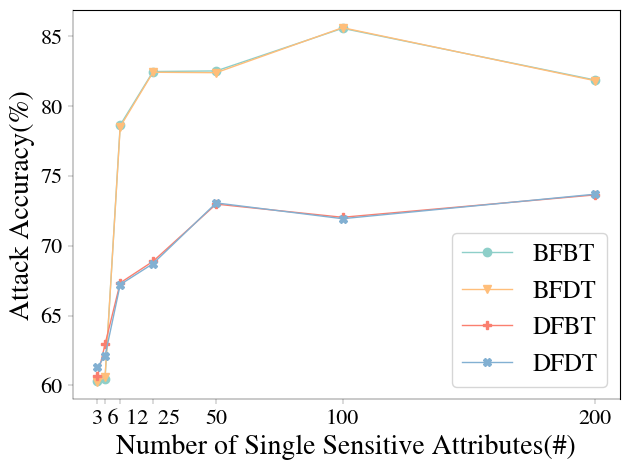

In [95]:
# acc_table_g = pd.concat([bfea_btop_g_pd["Acc"],bfea_dtop_g_pd["Acc"],dfea_btop_g_pd["Acc"],dfea_dtop_g_pd["Acc"]],axis=1)
# acc_table_g["Size"] = [8,15,31,62,125,250,500]
# acc_table_g.columns = ["BiasedF&BiasedT","BiasedF&DebiasedT","DebiasedF&BiasedT","DebiasedF&DebiasedT","Size"]
# acc_table_g
font = {"family": 'Nimbus Roman',
       "size": 20}
font1 = {"family": 'Nimbus Roman',
       "size": 18}
fig, ax = plt.subplots()
plt.grid(None)
ax.grid(None)
ax.spines['left'].set_color('#000000')
ax.spines['left'].set_linewidth(0.3)
ax.spines['bottom'].set_color('#000000')
ax.spines['bottom'].set_linewidth(0.3)
# ax.axes.xaxis.set_visible(True)
# ax.axes.yaxis.set_visible(True)
ax.plot(acc_table_g_sin["Size"], acc_table_g_sin["BFBT"]*100, label="BFBT", lw=1, color="#8ECFC9", marker="o")
ax.plot(acc_table_g_sin["Size"], acc_table_g_sin["BFDT"]*100, label="BFDT", lw=1, color="#FFBE7A", marker="v")
ax.plot(acc_table_g_sin["Size"], acc_table_g_sin["DFBT"]*100, label="DFBT", lw=1, color="#FA7F6F", marker="P")
ax.plot(acc_table_g_sin["Size"], acc_table_g_sin["DFDT"]*100, label="DFDT", lw=1, color="#82B0D2", marker="X")
# ax.set_title('Sensitive Attribute Inference Attack')
ax.legend()
plt.xlabel("Number of Single Sensitive Attributes(#)",fontdict=font)
plt.ylabel("Attack Accuracy(%)",fontdict=font)

ax.set_xticks([3,6,12,25,50,100,200])
ax.set_xticklabels(['3','   6','      12','      25','50','100','200'])
plt.legend(prop=font1)
# plt.xlim((0,500))
# plt.ylim((59,100))
plt.rcParams['axes.facecolor']='#FFFFFF'
plt.tick_params(left=True,bottom=True,width=0.2,labelsize=16)
labels=ax.get_xticklabels()+ax.get_yticklabels()
[label.set_fontname('Nimbus Roman') for label in labels]
# plt.xticks(fontsize=8)
plt.tight_layout()
plt.savefig("acc_g_re_sin.png",dpi=1000)
plt.show()

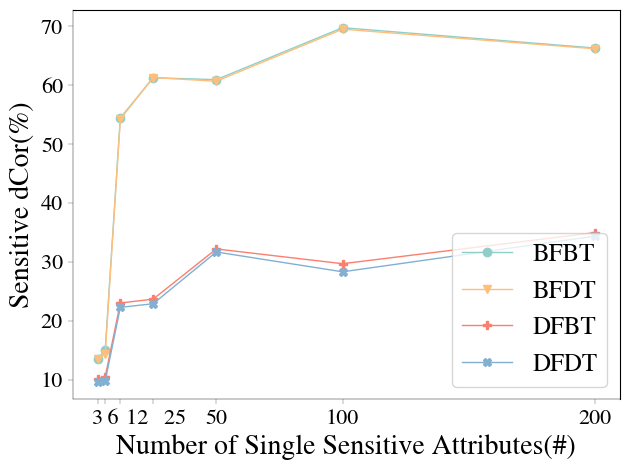

In [94]:
diff_table_g_sin = pd.DataFrame()
diff_table_g_sin["BFBT"] = np.array(att_acc_g_table_sin["Diff"][:7])
diff_table_g_sin["BFDT"] = np.array(att_acc_g_table_sin["Diff"][7:14])
diff_table_g_sin["DFBT"] = np.array(att_acc_g_table_sin["Diff"][14:21])
diff_table_g_sin["DFDT"] = np.array(att_acc_g_table_sin["Diff"][21:])
#concat([att_acc_g_table["Acc"][:7],att_acc_g_table["Acc"][7:14],att_acc_g_table["Acc"][14:21],att_acc_g_table["Acc"][21:]],axis=1)
diff_table_g_sin["Size"] = [3,6,12,25,50,100,200]
#diff_table_g.columns = ["BFBT","BFDT","DFBT","DFDT","Size"]
# diff_table_g
# diff_table_g = pd.concat([bfea_btop_g_pd["Diff"],bfea_dtop_g_pd["Diff"],dfea_btop_g_pd["Diff"],dfea_dtop_g_pd["Diff"]],axis=1)
# diff_table_g["Size"] = [8,15,31,62,125,250,500]
# diff_table_g.columns = ["BiasedF&BiasedT","BiasedF&DebiasedT","DebiasedF&BiasedT","DebiasedF&DebiasedT","Size"]
# diff_table_g
font = {"family": 'Nimbus Roman',
       "size": 20}
font1 = {"family": 'Nimbus Roman',
       "size": 18}
fig, ax = plt.subplots()
plt.grid(None)
ax.grid(None)
ax.spines['left'].set_color('#000000')
ax.spines['left'].set_linewidth(0.3)
ax.spines['bottom'].set_color('#000000')
ax.spines['bottom'].set_linewidth(0.3)
# ax.axes.xaxis.set_visible(True)
# ax.axes.yaxis.set_visible(True)
ax.plot(diff_table_g_sin["Size"], diff_table_g_sin["BFBT"]*100, label="BFBT", lw=1, color="#8ECFC9", marker="o")
ax.plot(diff_table_g_sin["Size"], diff_table_g_sin["BFDT"]*100, label="BFDT", lw=1, color="#FFBE7A", marker="v")
ax.plot(diff_table_g_sin["Size"], diff_table_g_sin["DFBT"]*100, label="DFBT", lw=1, color="#FA7F6F", marker="P")
ax.plot(diff_table_g_sin["Size"], diff_table_g_sin["DFDT"]*100, label="DFDT", lw=1, color="#82B0D2", marker="X")
# ax.set_title('Sensitive Attribute Inference Attack')
ax.legend()
plt.xlabel("Number of Single Sensitive Attributes(#)",fontdict=font)
plt.ylabel("Sensitive dCor(%)",fontdict=font)

ax.set_xticks([3,6,12,25,50,100,200])
ax.set_xticklabels(['3','   6','      12','        25','50','100','200'])
plt.legend(prop=font1)
# plt.xlim((0,500))
# plt.ylim((59,100))
plt.rcParams['axes.facecolor']='#FFFFFF'
plt.tick_params(left=True,bottom=True,width=0.2,labelsize=16)
labels=ax.get_xticklabels()+ax.get_yticklabels()
[label.set_fontname('Nimbus Roman') for label in labels]
# plt.xticks(fontsize=8)
plt.tight_layout()
plt.savefig("sensitive_dcor_g_re_sin.png",dpi=1000)
plt.show()

In [90]:
att_acc_g_table_major = pd.read_csv("att_acc_g_table_major.csv")
att_acc_g_table_major = att_acc_g_table_major.iloc[:,1:]
att_acc_g_table_major

,Acc,F1,AUCROC,Att,Diff,Size
0,0.630592,0.233829,0.587315,0.580837,0.169683,8
1,0.652012,0.293716,0.619123,0.570276,0.205458,15
2,0.770547,0.638892,0.826378,0.166112,0.516929,31
3,0.812410,0.677756,0.863893,0.248722,0.571611,62
4,0.814316,0.666613,0.867714,0.307903,0.592430,125
5,0.836889,0.698900,0.911625,0.297086,0.638601,250
6,0.817375,0.645418,0.904987,0.392558,0.645877,500
7,0.634002,0.244054,0.587555,0.586717,0.163677,8
8,0.642857,0.295913,0.615089,0.541015,0.200317,15
9,0.762854,0.615259,0.804667,0.216987,0.479533,31


In [91]:
acc_table_g_major = pd.DataFrame()
acc_table_g_major["BFBT"] = np.array(att_acc_g_table_major["Acc"][:7])
acc_table_g_major["BFDT"] = np.array(att_acc_g_table_major["Acc"][7:14])
acc_table_g_major["DFBT"] = np.array(att_acc_g_table_major["Acc"][14:21])
acc_table_g_major["DFDT"] = np.array(att_acc_g_table_major["Acc"][21:])
#concat([att_acc_g_table["Acc"][:7],att_acc_g_table["Acc"][7:14],att_acc_g_table["Acc"][14:21],att_acc_g_table["Acc"][21:]],axis=1)
acc_table_g_major["Size"] = [3,6,12,25,50,100,200]
#acc_table_g.columns = ["BFBT","BFDT","DFBT","DFDT","Size"]
acc_table_g_major

,BFBT,BFDT,DFBT,DFDT,Size
0,0.630592,0.634002,0.647041,0.642227,3
1,0.652012,0.642857,0.636217,0.641650,6
2,0.770547,0.762854,0.737652,0.729555,12
3,0.812410,0.811487,0.775487,0.775897,25
4,0.814316,0.811579,0.790632,0.788842,50
5,0.836889,0.837333,0.794889,0.792000,100
6,0.817375,0.816625,0.796750,0.794250,200


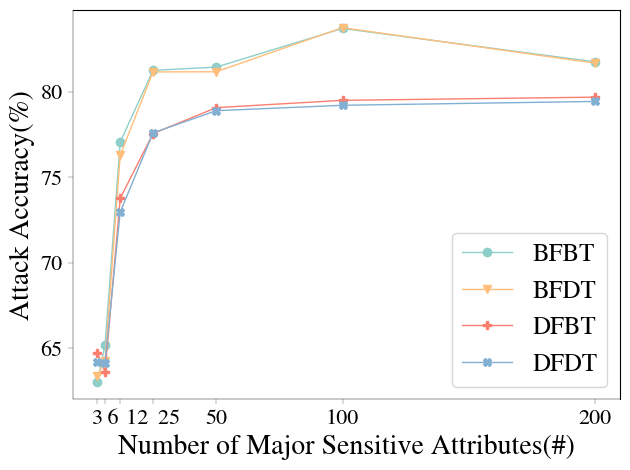

In [96]:
# acc_table_g = pd.concat([bfea_btop_g_pd["Acc"],bfea_dtop_g_pd["Acc"],dfea_btop_g_pd["Acc"],dfea_dtop_g_pd["Acc"]],axis=1)
# acc_table_g["Size"] = [8,15,31,62,125,250,500]
# acc_table_g.columns = ["BiasedF&BiasedT","BiasedF&DebiasedT","DebiasedF&BiasedT","DebiasedF&DebiasedT","Size"]
# acc_table_g
font = {"family": 'Nimbus Roman',
       "size": 20}
font1 = {"family": 'Nimbus Roman',
       "size": 18}
fig, ax = plt.subplots()
plt.grid(None)
ax.grid(None)
ax.spines['left'].set_color('#000000')
ax.spines['left'].set_linewidth(0.3)
ax.spines['bottom'].set_color('#000000')
ax.spines['bottom'].set_linewidth(0.3)
# ax.axes.xaxis.set_visible(True)
# ax.axes.yaxis.set_visible(True)
ax.plot(acc_table_g_major["Size"], acc_table_g_major["BFBT"]*100, label="BFBT", lw=1, color="#8ECFC9", marker="o")
ax.plot(acc_table_g_major["Size"], acc_table_g_major["BFDT"]*100, label="BFDT", lw=1, color="#FFBE7A", marker="v")
ax.plot(acc_table_g_major["Size"], acc_table_g_major["DFBT"]*100, label="DFBT", lw=1, color="#FA7F6F", marker="P")
ax.plot(acc_table_g_major["Size"], acc_table_g_major["DFDT"]*100, label="DFDT", lw=1, color="#82B0D2", marker="X")
# ax.set_title('Sensitive Attribute Inference Attack')
ax.legend()
plt.xlabel("Number of Major Sensitive Attributes(#)",fontdict=font)
plt.ylabel("Attack Accuracy(%)",fontdict=font)

ax.set_xticks([3,6,12,25,50,100,200])
ax.set_xticklabels(['3','   6','      12','      25','50','100','200'])
plt.legend(prop=font1)
# plt.xlim((0,500))
# plt.ylim((59,100))
plt.rcParams['axes.facecolor']='#FFFFFF'
plt.tick_params(left=True,bottom=True,width=0.2,labelsize=16)
labels=ax.get_xticklabels()+ax.get_yticklabels()
[label.set_fontname('Nimbus Roman') for label in labels]
# plt.xticks(fontsize=8)
plt.tight_layout()
plt.savefig("acc_g_re_major.png",dpi=1000)
plt.show()

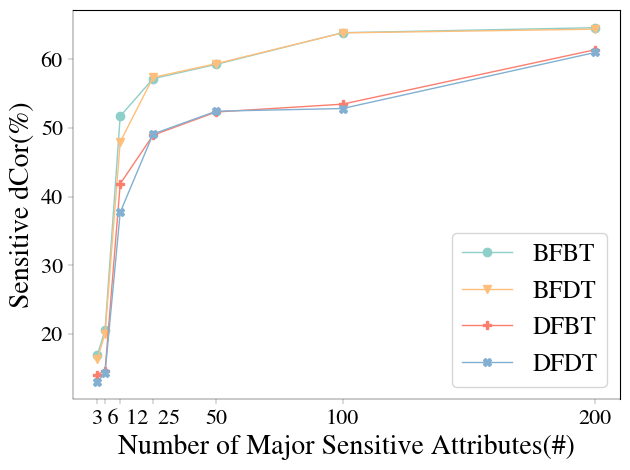

In [97]:
diff_table_g_major = pd.DataFrame()
diff_table_g_major["BFBT"] = np.array(att_acc_g_table_major["Diff"][:7])
diff_table_g_major["BFDT"] = np.array(att_acc_g_table_major["Diff"][7:14])
diff_table_g_major["DFBT"] = np.array(att_acc_g_table_major["Diff"][14:21])
diff_table_g_major["DFDT"] = np.array(att_acc_g_table_major["Diff"][21:])
#concat([att_acc_g_table["Acc"][:7],att_acc_g_table["Acc"][7:14],att_acc_g_table["Acc"][14:21],att_acc_g_table["Acc"][21:]],axis=1)
diff_table_g_major["Size"] = [3,6,12,25,50,100,200]
#diff_table_g.columns = ["BFBT","BFDT","DFBT","DFDT","Size"]
# diff_table_g
# diff_table_g = pd.concat([bfea_btop_g_pd["Diff"],bfea_dtop_g_pd["Diff"],dfea_btop_g_pd["Diff"],dfea_dtop_g_pd["Diff"]],axis=1)
# diff_table_g["Size"] = [8,15,31,62,125,250,500]
# diff_table_g.columns = ["BiasedF&BiasedT","BiasedF&DebiasedT","DebiasedF&BiasedT","DebiasedF&DebiasedT","Size"]
# diff_table_g
font = {"family": 'Nimbus Roman',
       "size": 20}
font1 = {"family": 'Nimbus Roman',
       "size": 18}
fig, ax = plt.subplots()
plt.grid(None)
ax.grid(None)
ax.spines['left'].set_color('#000000')
ax.spines['left'].set_linewidth(0.3)
ax.spines['bottom'].set_color('#000000')
ax.spines['bottom'].set_linewidth(0.3)
# ax.axes.xaxis.set_visible(True)
# ax.axes.yaxis.set_visible(True)
ax.plot(diff_table_g_major["Size"], diff_table_g_major["BFBT"]*100, label="BFBT", lw=1, color="#8ECFC9", marker="o")
ax.plot(diff_table_g_major["Size"], diff_table_g_major["BFDT"]*100, label="BFDT", lw=1, color="#FFBE7A", marker="v")
ax.plot(diff_table_g_major["Size"], diff_table_g_major["DFBT"]*100, label="DFBT", lw=1, color="#FA7F6F", marker="P")
ax.plot(diff_table_g_major["Size"], diff_table_g_major["DFDT"]*100, label="DFDT", lw=1, color="#82B0D2", marker="X")
# ax.set_title('Sensitive Attribute Inference Attack')
ax.legend()
plt.xlabel("Number of Major Sensitive Attributes(#)",fontdict=font)
plt.ylabel("Sensitive dCor(%)",fontdict=font)

ax.set_xticks([3,6,12,25,50,100,200])
ax.set_xticklabels(['3','   6','      12','      25','50','100','200'])
plt.legend(prop=font1)
# plt.xlim((0,500))
# plt.ylim((59,100))
plt.rcParams['axes.facecolor']='#FFFFFF'
plt.tick_params(left=True,bottom=True,width=0.2,labelsize=16)
labels=ax.get_xticklabels()+ax.get_yticklabels()
[label.set_fontname('Nimbus Roman') for label in labels]
# plt.xticks(fontsize=8)
plt.tight_layout()
plt.savefig("sensitive_dcor_g_re_major.png",dpi=1000)
plt.show()

In [98]:
att_acc_g_table_minor = pd.read_csv("att_acc_g_table_minor.csv")
att_acc_g_table_minor = att_acc_g_table_minor.iloc[:,1:]
att_acc_g_table_minor

,Acc,F1,AUCROC,Att,Diff,Size
0,0.809428,0.894678,0.566304,1.000000,0.162297,8
1,0.771831,0.868173,0.524305,0.876605,0.112222,15
2,0.787247,0.878152,0.666462,0.844392,0.225473,31
3,0.797436,0.886865,0.589387,0.970808,0.168401,62
4,0.802737,0.889816,0.686000,0.956468,0.307498,125
5,0.795778,0.884172,0.680635,0.892135,0.299202,250
6,0.835750,0.906641,0.769599,0.759649,0.517800,500
7,0.809428,0.894678,0.566149,1.000000,0.156918,8
8,0.771630,0.867986,0.524119,0.874396,0.110653,15
9,0.785223,0.876713,0.671105,0.834640,0.227892,31


In [99]:
acc_table_g_minor = pd.DataFrame()
acc_table_g_minor["BFBT"] = np.array(att_acc_g_table_minor["Acc"][:7])
acc_table_g_minor["BFDT"] = np.array(att_acc_g_table_minor["Acc"][7:14])
acc_table_g_minor["DFBT"] = np.array(att_acc_g_table_minor["Acc"][14:21])
acc_table_g_minor["DFDT"] = np.array(att_acc_g_table_minor["Acc"][21:])
#concat([att_acc_g_table["Acc"][:7],att_acc_g_table["Acc"][7:14],att_acc_g_table["Acc"][14:21],att_acc_g_table["Acc"][21:]],axis=1)
acc_table_g_minor["Size"] = [3,6,12,25,50,100,200]
#acc_table_g.columns = ["BFBT","BFDT","DFBT","DFDT","Size"]
acc_table_g_minor

,BFBT,BFDT,DFBT,DFDT,Size
0,0.809428,0.809428,0.782548,0.782748,3
1,0.771831,0.771630,0.787626,0.787223,6
2,0.787247,0.785223,0.795243,0.791599,12
3,0.797436,0.798564,0.804205,0.803897,25
4,0.802737,0.802632,0.804632,0.804421,50
5,0.795778,0.796667,0.799667,0.803000,100
6,0.835750,0.834875,0.840875,0.840750,200


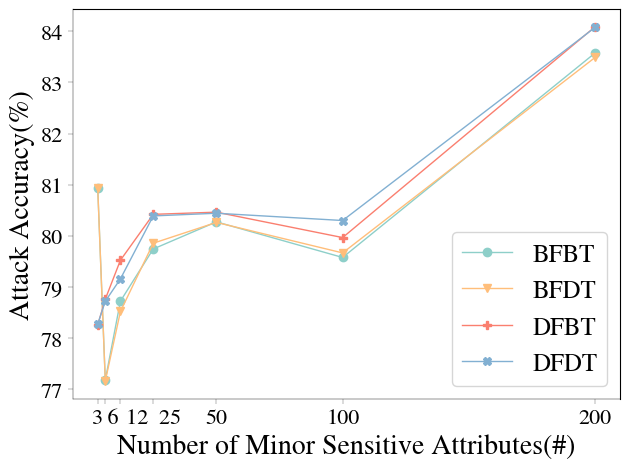

In [100]:
# acc_table_g = pd.concat([bfea_btop_g_pd["Acc"],bfea_dtop_g_pd["Acc"],dfea_btop_g_pd["Acc"],dfea_dtop_g_pd["Acc"]],axis=1)
# acc_table_g["Size"] = [8,15,31,62,125,250,500]
# acc_table_g.columns = ["BiasedF&BiasedT","BiasedF&DebiasedT","DebiasedF&BiasedT","DebiasedF&DebiasedT","Size"]
# acc_table_g
font = {"family": 'Nimbus Roman',
       "size": 20}
font1 = {"family": 'Nimbus Roman',
       "size": 18}
fig, ax = plt.subplots()
plt.grid(None)
ax.grid(None)
ax.spines['left'].set_color('#000000')
ax.spines['left'].set_linewidth(0.3)
ax.spines['bottom'].set_color('#000000')
ax.spines['bottom'].set_linewidth(0.3)
# ax.axes.xaxis.set_visible(True)
# ax.axes.yaxis.set_visible(True)
ax.plot(acc_table_g_minor["Size"], acc_table_g_minor["BFBT"]*100, label="BFBT", lw=1, color="#8ECFC9", marker="o")
ax.plot(acc_table_g_minor["Size"], acc_table_g_minor["BFDT"]*100, label="BFDT", lw=1, color="#FFBE7A", marker="v")
ax.plot(acc_table_g_minor["Size"], acc_table_g_minor["DFBT"]*100, label="DFBT", lw=1, color="#FA7F6F", marker="P")
ax.plot(acc_table_g_minor["Size"], acc_table_g_minor["DFDT"]*100, label="DFDT", lw=1, color="#82B0D2", marker="X")
# ax.set_title('Sensitive Attribute Inference Attack')
ax.legend()
plt.xlabel("Number of Minor Sensitive Attributes(#)",fontdict=font)
plt.ylabel("Attack Accuracy(%)",fontdict=font)

ax.set_xticks([3,6,12,25,50,100,200])
ax.set_xticklabels(['3','   6','      12','      25','50','100','200'])
plt.legend(prop=font1, loc="lower right")
# plt.xlim((0,500))
# plt.ylim((59,100))
plt.rcParams['axes.facecolor']='#FFFFFF'
plt.tick_params(left=True,bottom=True,width=0.2,labelsize=16)
labels=ax.get_xticklabels()+ax.get_yticklabels()
[label.set_fontname('Nimbus Roman') for label in labels]
# plt.xticks(fontsize=8)
plt.tight_layout()
plt.savefig("acc_g_re_minor.png",dpi=1000)
plt.show()

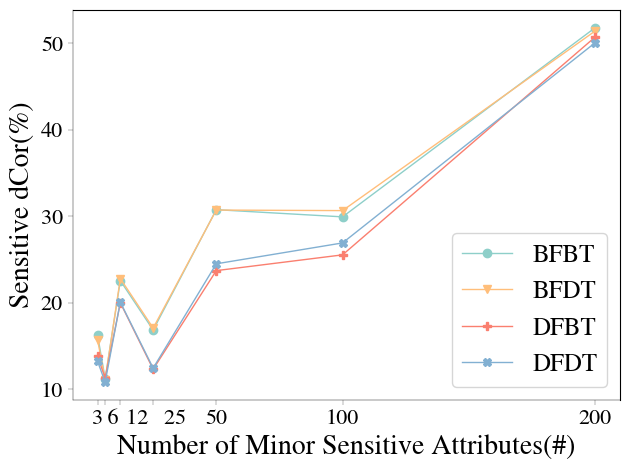

In [101]:
diff_table_g_minor = pd.DataFrame()
diff_table_g_minor["BFBT"] = np.array(att_acc_g_table_minor["Diff"][:7])
diff_table_g_minor["BFDT"] = np.array(att_acc_g_table_minor["Diff"][7:14])
diff_table_g_minor["DFBT"] = np.array(att_acc_g_table_minor["Diff"][14:21])
diff_table_g_minor["DFDT"] = np.array(att_acc_g_table_minor["Diff"][21:])
#concat([att_acc_g_table["Acc"][:7],att_acc_g_table["Acc"][7:14],att_acc_g_table["Acc"][14:21],att_acc_g_table["Acc"][21:]],axis=1)
diff_table_g_minor["Size"] = [3,6,12,25,50,100,200]
#diff_table_g.columns = ["BFBT","BFDT","DFBT","DFDT","Size"]
# diff_table_g
# diff_table_g = pd.concat([bfea_btop_g_pd["Diff"],bfea_dtop_g_pd["Diff"],dfea_btop_g_pd["Diff"],dfea_dtop_g_pd["Diff"]],axis=1)
# diff_table_g["Size"] = [8,15,31,62,125,250,500]
# diff_table_g.columns = ["BiasedF&BiasedT","BiasedF&DebiasedT","DebiasedF&BiasedT","DebiasedF&DebiasedT","Size"]
# diff_table_g
font = {"family": 'Nimbus Roman',
       "size": 20}
font1 = {"family": 'Nimbus Roman',
       "size": 18}
fig, ax = plt.subplots()
plt.grid(None)
ax.grid(None)
ax.spines['left'].set_color('#000000')
ax.spines['left'].set_linewidth(0.3)
ax.spines['bottom'].set_color('#000000')
ax.spines['bottom'].set_linewidth(0.3)
# ax.axes.xaxis.set_visible(True)
# ax.axes.yaxis.set_visible(True)
ax.plot(diff_table_g_minor["Size"], diff_table_g_minor["BFBT"]*100, label="BFBT", lw=1, color="#8ECFC9", marker="o")
ax.plot(diff_table_g_minor["Size"], diff_table_g_minor["BFDT"]*100, label="BFDT", lw=1, color="#FFBE7A", marker="v")
ax.plot(diff_table_g_minor["Size"], diff_table_g_minor["DFBT"]*100, label="DFBT", lw=1, color="#FA7F6F", marker="P")
ax.plot(diff_table_g_minor["Size"], diff_table_g_minor["DFDT"]*100, label="DFDT", lw=1, color="#82B0D2", marker="X")
# ax.set_title('Sensitive Attribute Inference Attack')
ax.legend()
plt.xlabel("Number of Minor Sensitive Attributes(#)",fontdict=font)
plt.ylabel("Sensitive dCor(%)",fontdict=font)

ax.set_xticks([3,6,12,25,50,100,200])
ax.set_xticklabels(['3','   6','      12','        25','50','100','200'])
plt.legend(prop=font1, loc="lower right")
# plt.xlim((0,500))
# plt.ylim((59,100))
plt.rcParams['axes.facecolor']='#FFFFFF'
plt.tick_params(left=True,bottom=True,width=0.2,labelsize=16)
labels=ax.get_xticklabels()+ax.get_yticklabels()
[label.set_fontname('Nimbus Roman') for label in labels]
# plt.xticks(fontsize=8)
plt.tight_layout()
plt.savefig("sensitive_dcor_g_re_minor.png",dpi=1000)
plt.show()

In [102]:
acc_table_syn_m1 = pd.DataFrame()
acc_table_syn_m1["BFBT"] = np.array(att_acc_syn_table_m1["Acc"][:7])
acc_table_syn_m1["BFDT"] = np.array(att_acc_syn_table_m1["Acc"][7:14])
acc_table_syn_m1["DFBT"] = np.array(att_acc_syn_table_m1["Acc"][14:21])
acc_table_syn_m1["DFDT"] = np.array(att_acc_syn_table_m1["Acc"][21:])
#concat([att_acc_syn_table["Acc"][:7],att_acc_syn_table["Acc"][7:14],att_acc_syn_table["Acc"][14:21],att_acc_syn_table["Acc"][21:]],axis=1)
acc_table_syn_m1["Size"] = [8,15,31,62,125,250,500]
#acc_table_syn.columns = ["BFBT","BFDT","DFBT","DFDT","Size"]
acc_table_syn_m1

,BFBT,BFDT,DFBT,DFDT,Size
0,0.939045,0.848395,0.862841,0.849799,8
1,0.949980,0.942777,0.871751,0.874366,15
2,0.974281,0.925881,0.874038,0.877886,31
3,0.979820,0.944422,0.881829,0.879327,62
4,0.978821,0.965011,0.884126,0.881221,125
5,0.983467,0.968800,0.876711,0.879689,250
6,0.980900,0.977750,0.876250,0.886300,500


In [103]:
acc_table_syn_m2 = pd.DataFrame()
acc_table_syn_m2["BFBT"] = np.array(att_acc_syn_table_m2["Acc"][:7])
acc_table_syn_m2["BFDT"] = np.array(att_acc_syn_table_m2["Acc"][7:14])
acc_table_syn_m2["DFBT"] = np.array(att_acc_syn_table_m2["Acc"][14:21])
acc_table_syn_m2["DFDT"] = np.array(att_acc_syn_table_m2["Acc"][21:])
#concat([att_acc_syn_table["Acc"][:7],att_acc_syn_table["Acc"][7:14],att_acc_syn_table["Acc"][14:21],att_acc_syn_table["Acc"][21:]],axis=1)
acc_table_syn_m2["Size"] = [8,15,31,62,125,250,500]
#acc_table_syn.columns = ["BFBT","BFDT","DFBT","DFDT","Size"]
acc_table_syn_m2

,BFBT,BFDT,DFBT,DFDT,Size
0,0.805016,0.785554,0.765329,0.763443,8
1,0.874205,0.833239,0.778833,0.784467,15
2,0.884285,0.806683,0.788133,0.789631,31
3,0.885070,0.842248,0.795529,0.789787,62
4,0.887032,0.833937,0.806232,0.792800,125
5,0.894311,0.860533,0.805111,0.795067,250
6,0.893300,0.871400,0.812550,0.800050,500


In [23]:
import matplotlib.pyplot as plt

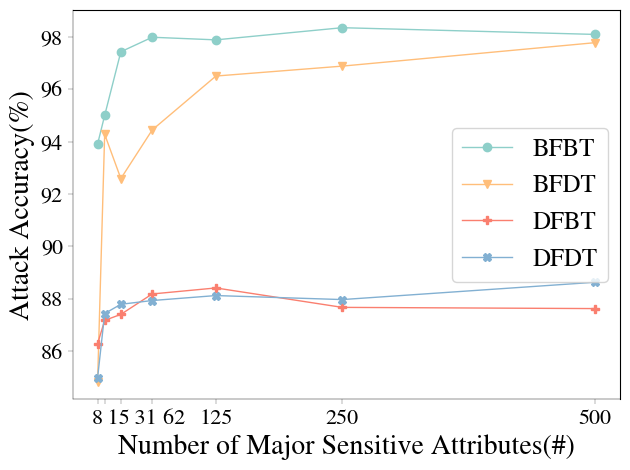

In [104]:
# acc_table_syn = pd.concat([bfea_btop_syn_pd["Acc"],bfea_dtop_syn_pd["Acc"],dfea_btop_syn_pd["Acc"],dfea_dtop_syn_pd["Acc"]],axis=1)
# acc_table_syn["Size"] = [8,15,31,62,125,250,500]
# acc_table_syn.columns = ["BiasedF&BiasedT","BiasedF&DebiasedT","DebiasedF&BiasedT","DebiasedF&DebiasedT","Size"]
# acc_table_syn
font = {"family": 'Nimbus Roman',
       "size": 20}
font1 = {"family": 'Nimbus Roman',
       "size": 18}
fig, ax = plt.subplots()
plt.grid(None)
ax.grid(None)
ax.spines['left'].set_color('#000000')
ax.spines['left'].set_linewidth(0.3)
ax.spines['bottom'].set_color('#000000')
ax.spines['bottom'].set_linewidth(0.3)
# ax.axes.xaxis.set_visible(True)
# ax.axes.yaxis.set_visible(True)
ax.plot(acc_table_syn_m1["Size"], acc_table_syn_m1["BFBT"]*100, label="BFBT", lw=1, color="#8ECFC9", marker="o")
ax.plot(acc_table_syn_m1["Size"], acc_table_syn_m1["BFDT"]*100, label="BFDT", lw=1, color="#FFBE7A", marker="v")
ax.plot(acc_table_syn_m1["Size"], acc_table_syn_m1["DFBT"]*100, label="DFBT", lw=1, color="#FA7F6F", marker="P")
ax.plot(acc_table_syn_m1["Size"], acc_table_syn_m1["DFDT"]*100, label="DFDT", lw=1, color="#82B0D2", marker="X")
# ax.set_title('Sensitive Attribute Inference Attack')
ax.legend()
plt.xlabel("Number of Major Sensitive Attributes(#)",fontdict=font)
plt.ylabel("Attack Accuracy(%)",fontdict=font)

ax.set_xticks([8,15,31,62,125,250,500])
ax.set_xticklabels(['8','     15','         31','        62','125','250','500'])
plt.legend(prop=font1)
# plt.xlim((0,500))
# plt.ylim((59,100))
plt.rcParams['axes.facecolor']='#FFFFFF'
plt.tick_params(left=True,bottom=True,width=0.2,labelsize=16)
labels=ax.get_xticklabels()+ax.get_yticklabels()
[label.set_fontname('Nimbus Roman') for label in labels]
# plt.xticks(fontsize=8)
plt.tight_layout()
plt.savefig("acc_syn_re_m1.png",dpi=1000)
plt.show()

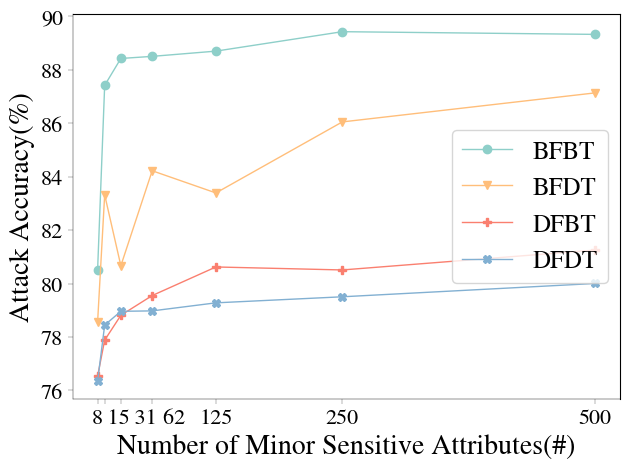

In [105]:
# acc_table_syn = pd.concat([bfea_btop_syn_pd["Acc"],bfea_dtop_syn_pd["Acc"],dfea_btop_syn_pd["Acc"],dfea_dtop_syn_pd["Acc"]],axis=1)
# acc_table_syn["Size"] = [8,15,31,62,125,250,500]
# acc_table_syn.columns = ["BiasedF&BiasedT","BiasedF&DebiasedT","DebiasedF&BiasedT","DebiasedF&DebiasedT","Size"]
# acc_table_syn
font = {"family": 'Nimbus Roman',
       "size": 20}
font1 = {"family": 'Nimbus Roman',
       "size": 18}
fig, ax = plt.subplots()
plt.grid(None)
ax.grid(None)
ax.spines['left'].set_color('#000000')
ax.spines['left'].set_linewidth(0.3)
ax.spines['bottom'].set_color('#000000')
ax.spines['bottom'].set_linewidth(0.3)
# ax.axes.xaxis.set_visible(True)
# ax.axes.yaxis.set_visible(True)
ax.plot(acc_table_syn_m2["Size"], acc_table_syn_m2["BFBT"]*100, label="BFBT", lw=1, color="#8ECFC9", marker="o")
ax.plot(acc_table_syn_m2["Size"], acc_table_syn_m2["BFDT"]*100, label="BFDT", lw=1, color="#FFBE7A", marker="v")
ax.plot(acc_table_syn_m2["Size"], acc_table_syn_m2["DFBT"]*100, label="DFBT", lw=1, color="#FA7F6F", marker="P")
ax.plot(acc_table_syn_m2["Size"], acc_table_syn_m2["DFDT"]*100, label="DFDT", lw=1, color="#82B0D2", marker="X")
# ax.set_title('Sensitive Attribute Inference Attack')
ax.legend()
plt.xlabel("Number of Minor Sensitive Attributes(#)",fontdict=font)
plt.ylabel("Attack Accuracy(%)",fontdict=font)

ax.set_xticks([8,15,31,62,125,250,500])
ax.set_xticklabels(['8','     15','         31','        62','125','250','500'])
plt.legend(prop=font1)
# plt.xlim((0,500))
# plt.ylim((59,100))
plt.rcParams['axes.facecolor']='#FFFFFF'
plt.tick_params(left=True,bottom=True,width=0.2,labelsize=16)
labels=ax.get_xticklabels()+ax.get_yticklabels()
[label.set_fontname('Nimbus Roman') for label in labels]
# plt.xticks(fontsize=8)
plt.tight_layout()
plt.savefig("acc_syn_re_m2.png",dpi=1000)
plt.show()

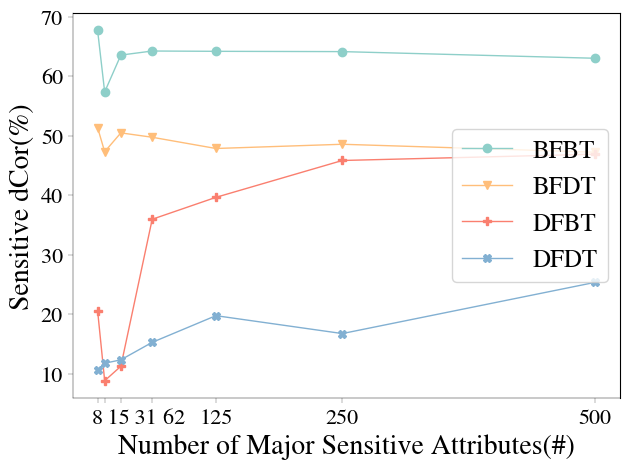

In [106]:
diff_table_syn_m1 = pd.DataFrame()
diff_table_syn_m1["BFBT"] = np.array(att_acc_syn_table_m1["Diff"][:7])
diff_table_syn_m1["BFDT"] = np.array(att_acc_syn_table_m1["Diff"][7:14])
diff_table_syn_m1["DFBT"] = np.array(att_acc_syn_table_m1["Diff"][14:21])
diff_table_syn_m1["DFDT"] = np.array(att_acc_syn_table_m1["Diff"][21:])
#concat([att_acc_syn_table["Acc"][:7],att_acc_syn_table["Acc"][7:14],att_acc_syn_table["Acc"][14:21],att_acc_syn_table["Acc"][21:]],axis=1)
diff_table_syn_m1["Size"] = [8,15,31,62,125,250,500]
#diff_table_syn.columns = ["BFBT","BFDT","DFBT","DFDT","Size"]
# diff_table_syn
# diff_table_syn = pd.concat([bfea_btop_syn_pd["Diff"],bfea_dtop_syn_pd["Diff"],dfea_btop_syn_pd["Diff"],dfea_dtop_syn_pd["Diff"]],axis=1)
# diff_table_syn["Size"] = [8,15,31,62,125,250,500]
# diff_table_syn.columns = ["BiasedF&BiasedT","BiasedF&DebiasedT","DebiasedF&BiasedT","DebiasedF&DebiasedT","Size"]
# diff_table_syn
font = {"family": 'Nimbus Roman',
       "size": 20}
font1 = {"family": 'Nimbus Roman',
       "size": 18}
fig, ax = plt.subplots()
plt.grid(None)
ax.grid(None)
ax.spines['left'].set_color('#000000')
ax.spines['left'].set_linewidth(0.3)
ax.spines['bottom'].set_color('#000000')
ax.spines['bottom'].set_linewidth(0.3)
# ax.axes.xaxis.set_visible(True)
# ax.axes.yaxis.set_visible(True)
ax.plot(diff_table_syn_m1["Size"], diff_table_syn_m1["BFBT"]*100, label="BFBT", lw=1, color="#8ECFC9", marker="o")
ax.plot(diff_table_syn_m1["Size"], diff_table_syn_m1["BFDT"]*100, label="BFDT", lw=1, color="#FFBE7A", marker="v")
ax.plot(diff_table_syn_m1["Size"], diff_table_syn_m1["DFBT"]*100, label="DFBT", lw=1, color="#FA7F6F", marker="P")
ax.plot(diff_table_syn_m1["Size"], diff_table_syn_m1["DFDT"]*100, label="DFDT", lw=1, color="#82B0D2", marker="X")
# ax.set_title('Sensitive Attribute Inference Attack')
ax.legend()
plt.xlabel("Number of Major Sensitive Attributes(#)",fontdict=font)
plt.ylabel("Sensitive dCor(%)",fontdict=font)

ax.set_xticks([8,15,31,62,125,250,500])
ax.set_xticklabels(['8','     15','         31','        62','125','250','500'])
plt.legend(prop=font1, loc="center right")
# plt.xlim((0,500))
# plt.ylim((59,100))
plt.rcParams['axes.facecolor']='#FFFFFF'
plt.tick_params(left=True,bottom=True,width=0.2,labelsize=16)
labels=ax.get_xticklabels()+ax.get_yticklabels()
[label.set_fontname('Nimbus Roman') for label in labels]
# plt.xticks(fontsize=8)
plt.tight_layout()
plt.savefig("sensitive_dcor_syn_re_m1.png",dpi=1000)
plt.show()

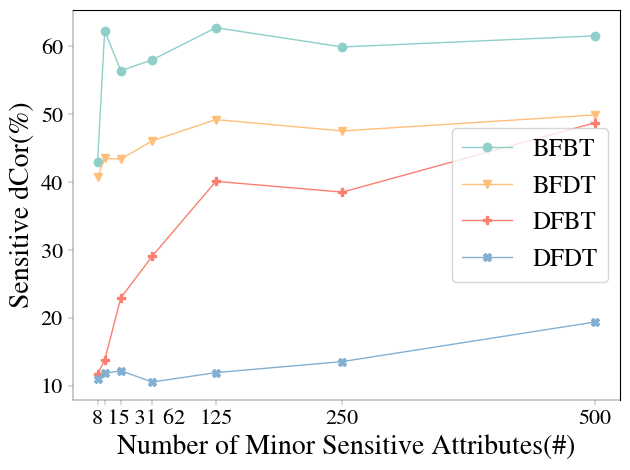

In [107]:
diff_table_syn_m2 = pd.DataFrame()
diff_table_syn_m2["BFBT"] = np.array(att_acc_syn_table_m2["Diff"][:7])
diff_table_syn_m2["BFDT"] = np.array(att_acc_syn_table_m2["Diff"][7:14])
diff_table_syn_m2["DFBT"] = np.array(att_acc_syn_table_m2["Diff"][14:21])
diff_table_syn_m2["DFDT"] = np.array(att_acc_syn_table_m2["Diff"][21:])
#concat([att_acc_syn_table["Acc"][:7],att_acc_syn_table["Acc"][7:14],att_acc_syn_table["Acc"][14:21],att_acc_syn_table["Acc"][21:]],axis=1)
diff_table_syn_m2["Size"] = [8,15,31,62,125,250,500]
#diff_table_syn.columns = ["BFBT","BFDT","DFBT","DFDT","Size"]
# diff_table_syn
# diff_table_syn = pd.concat([bfea_btop_syn_pd["Diff"],bfea_dtop_syn_pd["Diff"],dfea_btop_syn_pd["Diff"],dfea_dtop_syn_pd["Diff"]],axis=1)
# diff_table_syn["Size"] = [8,15,31,62,125,250,500]
# diff_table_syn.columns = ["BiasedF&BiasedT","BiasedF&DebiasedT","DebiasedF&BiasedT","DebiasedF&DebiasedT","Size"]
# diff_table_syn
font = {"family": 'Nimbus Roman',
       "size": 20}
font1 = {"family": 'Nimbus Roman',
       "size": 18}
fig, ax = plt.subplots()
plt.grid(None)
ax.grid(None)
ax.spines['left'].set_color('#000000')
ax.spines['left'].set_linewidth(0.3)
ax.spines['bottom'].set_color('#000000')
ax.spines['bottom'].set_linewidth(0.3)
# ax.axes.xaxis.set_visible(True)
# ax.axes.yaxis.set_visible(True)
ax.plot(diff_table_syn_m2["Size"], diff_table_syn_m2["BFBT"]*100, label="BFBT", lw=1, color="#8ECFC9", marker="o")
ax.plot(diff_table_syn_m2["Size"], diff_table_syn_m2["BFDT"]*100, label="BFDT", lw=1, color="#FFBE7A", marker="v")
ax.plot(diff_table_syn_m2["Size"], diff_table_syn_m2["DFBT"]*100, label="DFBT", lw=1, color="#FA7F6F", marker="P")
ax.plot(diff_table_syn_m2["Size"], diff_table_syn_m2["DFDT"]*100, label="DFDT", lw=1, color="#82B0D2", marker="X")
# ax.set_title('Sensitive Attribute Inference Attack')
ax.legend()
plt.xlabel("Number of Minor Sensitive Attributes(#)",fontdict=font)
plt.ylabel("Sensitive dCor(%)",fontdict=font)

ax.set_xticks([8,15,31,62,125,250,500])
ax.set_xticklabels(['8','     15','         31','        62','125','250','500'])
plt.legend(prop=font1)
# plt.xlim((0,500))
# plt.ylim((59,100))
plt.rcParams['axes.facecolor']='#FFFFFF'
plt.tick_params(left=True,bottom=True,width=0.2,labelsize=16)
labels=ax.get_xticklabels()+ax.get_yticklabels()
[label.set_fontname('Nimbus Roman') for label in labels]
# plt.xticks(fontsize=8)
plt.tight_layout()
plt.savefig("sensitive_dcor_syn_re_m2.png",dpi=1000)
plt.show()

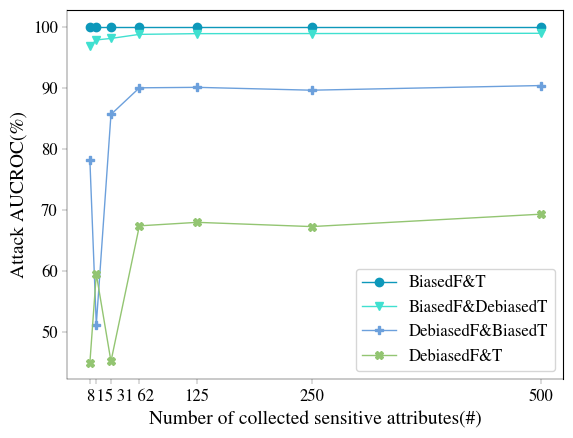

In [450]:
auc_table_syn = pd.concat([bfea_btop_syn_pd["AUCROC"],bfea_dtop_syn_pd["AUCROC"],dfea_btop_syn_pd["AUCROC"],dfea_dtop_syn_pd["AUCROC"]],axis=1)
auc_table_syn["Size"] = [8,15,31,62,125,250,500]
auc_table_syn.columns = ["BiasedF&BiasedT","BiasedF&DebiasedT","DebiasedF&BiasedT","DebiasedF&DebiasedT","Size"]
auc_table_syn
font = {"family": 'Nimbus Roman',
       "size": 14}
font1 = {"family": 'Nimbus Roman',
       "size": 12}
fig, ax = plt.subplots()
plt.grid(None)
ax.grid(None)
ax.spines['left'].set_color('#000000')
ax.spines['left'].set_linewidth(0.3)
ax.spines['bottom'].set_color('#000000')
ax.spines['bottom'].set_linewidth(0.3)
# ax.axes.xaxis.set_visible(True)
# ax.axes.yaxis.set_visible(True)
ax.plot(auc_table_syn["Size"], auc_table_syn["BiasedF&BiasedT"]*100, label="BiasedF&T", lw=1, color="#0D98BA", marker="o")
ax.plot(auc_table_syn["Size"], auc_table_syn["BiasedF&DebiasedT"]*100, label="BiasedF&DebiasedT", lw=1, color="#40E0D0", marker="v")
ax.plot(auc_table_syn["Size"], auc_table_syn["DebiasedF&BiasedT"]*100, label="DebiasedF&BiasedT", lw=1, color="#6CA0DC", marker="P")
ax.plot(auc_table_syn["Size"], auc_table_syn["DebiasedF&DebiasedT"]*100, label="DebiasedF&T", lw=1, color="#93C572", marker="X")
# ax.set_title('Sensitive Attribute Inference Attack')
ax.legend()
plt.xlabel("Number of collected sensitive attributes(#)",fontdict=font)
plt.ylabel("Attack AUCROC(%)",fontdict=font)

ax.set_xticks([8,15,31,62,125,250,500])
ax.set_xticklabels(['8','    15','       31','   62','125','250','500'])
plt.legend(prop=font1)
# plt.xlim((0,500))
# plt.ylim((59,100))
plt.rcParams['axes.facecolor']='#FFFFFF'
plt.tick_params(left=True,bottom=True,width=0.2,labelsize=12)
labels=ax.get_xticklabels()+ax.get_yticklabels()
[label.set_fontname('Nimbus Roman') for label in labels]
# plt.xticks(fontsize=8)
plt.savefig("auc_syn.png", dpi=1000)
plt.show()

In [350]:
bfea_btop_pd = pd.DataFrame(bfea_btop)

In [351]:
bfea_btop_pd.columns = ["Acc", "F1", "AUCROC", "Att", "Diff"]

In [352]:
bfea_btop_pd["Size"] = [3,6,12,25,50,100,200]

In [353]:
bfea_dtop_pd = pd.DataFrame(bfea_dtop)
bfea_dtop_pd.columns = ["Acc", "F1", "AUCROC", "Att", "Diff"]
bfea_dtop_pd["Size"] = [3,6,12,25,50,100,200]
dfea_btop_pd = pd.DataFrame(dfea_btop)
dfea_btop_pd.columns = ["Acc", "F1", "AUCROC", "Att", "Diff"]
dfea_btop_pd["Size"] = [3,6,12,25,50,100,200]
dfea_dtop_pd = pd.DataFrame(dfea_dtop)
dfea_dtop_pd.columns = ["Acc", "F1", "AUCROC", "Att", "Diff"]
dfea_dtop_pd["Size"] = [3,6,12,25,50,100,200]

In [354]:
att_acc_table = pd.concat([bfea_btop_pd,bfea_dtop_pd,dfea_btop_pd,dfea_dtop_pd])

In [441]:
att_acc_table.to_csv("att_acc_table.csv")

In [12]:
att_acc_table = pd.read_csv("att_acc_table.csv")

In [13]:
att_acc_table = att_acc_table.iloc[:,1:]

In [14]:
att_acc_table

,Acc,F1,AUCROC,Att,Diff,Size
0,0.603912,0.384513,0.581087,0.276735,0.132898,3
1,0.618410,0.373002,0.591976,0.348463,0.150124,6
2,0.758300,0.629451,0.813874,0.140795,0.499570,12
3,0.816615,0.690951,0.873876,0.217876,0.593382,25
4,0.825158,0.697030,0.880311,0.252673,0.607248,50
5,0.850222,0.743340,0.922103,0.195896,0.686704,100
6,0.816000,0.640104,0.908277,0.400552,0.657201,200
7,0.593079,0.397234,0.576139,0.216016,0.123385,3
8,0.611771,0.374541,0.588454,0.324258,0.141257,6
9,0.755870,0.628049,0.809936,0.133962,0.494175,12


In [15]:
acc_table_german = pd.DataFrame()
acc_table_german["BFBT"] = np.array(att_acc_table["Acc"][:7])
acc_table_german["BFDT"] = np.array(att_acc_table["Acc"][7:14])
acc_table_german["DFBT"] = np.array(att_acc_table["Acc"][14:21])
acc_table_german["DFDT"] = np.array(att_acc_table["Acc"][21:])
#concat([att_acc_german_table["Acc"][:7],att_acc_german_table["Acc"][7:14],att_acc_german_table["Acc"][14:21],att_acc_german_table["Acc"][21:]],axis=1)
acc_table_german["Size"] = [3,6,12,25,50,100,200]

In [16]:
acc_table_german

,BFBT,BFDT,DFBT,DFDT,Size
0,0.603912,0.593079,0.606520,0.613240,3
1,0.618410,0.611771,0.629577,0.621127,6
2,0.758300,0.755870,0.673482,0.672267,12
3,0.816615,0.815282,0.688923,0.687282,25
4,0.825158,0.825368,0.729895,0.730737,50
5,0.850222,0.853444,0.720444,0.719444,100
6,0.816000,0.819000,0.736500,0.737000,200


In [22]:
acc_table_german = pd.concat([bfea_btop_pd["Acc"],bfea_dtop_pd["Acc"],dfea_btop_pd["Acc"],dfea_dtop_pd["Acc"]],axis=1)

NameError: name 'bfea_btop_pd' is not defined

In [357]:
acc_table_german["Size"] = [3,6,12,25,50,100,200]

In [17]:
acc_table_german.columns = ["BiasedF&BiasedT","BiasedF&DebiasedT","DebiasedF&BiasedT","DebiasedF&DebiasedT","Size"]

In [18]:
acc_table_german

,BiasedF&BiasedT,BiasedF&DebiasedT,DebiasedF&BiasedT,DebiasedF&DebiasedT,Size
0,0.603912,0.593079,0.606520,0.613240,3
1,0.618410,0.611771,0.629577,0.621127,6
2,0.758300,0.755870,0.673482,0.672267,12
3,0.816615,0.815282,0.688923,0.687282,25
4,0.825158,0.825368,0.729895,0.730737,50
5,0.850222,0.853444,0.720444,0.719444,100
6,0.816000,0.819000,0.736500,0.737000,200


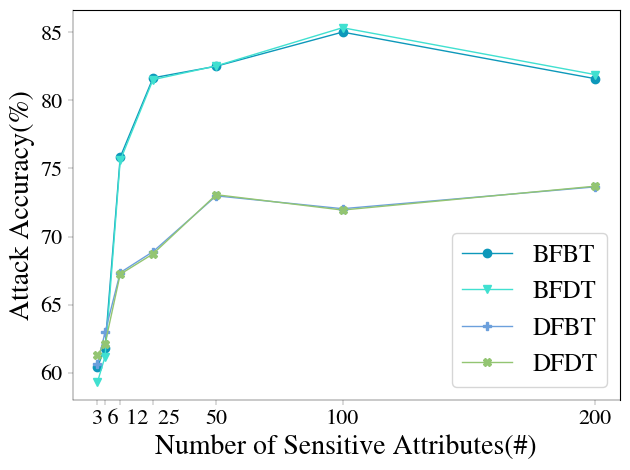

In [28]:
font = {"family": 'Nimbus Roman',
       "size": 20}
font1 = {"family": 'Nimbus Roman',
       "size": 18}
fig, ax = plt.subplots()
plt.grid(None)
ax.grid(None)
ax.spines['left'].set_color('#000000')
ax.spines['left'].set_linewidth(0.3)
ax.spines['bottom'].set_color('#000000')
ax.spines['bottom'].set_linewidth(0.3)
# ax.axes.xaxis.set_visible(True)
# ax.axes.yaxis.set_visible(True)
ax.plot(acc_table_german["Size"], acc_table_german["BiasedF&BiasedT"]*100, label="BFBT", lw=1, color="#0D98BA", marker="o")
ax.plot(acc_table_german["Size"], acc_table_german["BiasedF&DebiasedT"]*100, label="BFDT", lw=1, color="#40E0D0", marker="v")
ax.plot(acc_table_german["Size"], acc_table_german["DebiasedF&BiasedT"]*100, label="DFBT", lw=1, color="#6CA0DC", marker="P")
ax.plot(acc_table_german["Size"], acc_table_german["DebiasedF&DebiasedT"]*100, label="DFDT", lw=1, color="#93C572", marker="X")
# ax.set_title('Sensitive Attribute Inference Attack')
ax.legend()
plt.xlabel("Number of Sensitive Attributes(#)",fontdict=font)
plt.ylabel("Attack Accuracy(%)",fontdict=font)

ax.set_xticks([3,6,12,25,50,100,200])
ax.set_xticklabels(['3','   6','      12','      25','50','100','200'])
plt.legend(prop=font1)
# plt.xlim((0,500))
# plt.ylim((59,100))
plt.rcParams['axes.facecolor']='#FFFFFF'
plt.tick_params(left=True,bottom=True,width=0.2,labelsize=16)
labels=ax.get_xticklabels()+ax.get_yticklabels()
[label.set_fontname('Nimbus Roman') for label in labels]
plt.tight_layout()
# plt.xticks(fontsize=8)
plt.savefig("sensitive_attack_accuracy_german_16.png",dpi=1000)
plt.show()

In [20]:
att_table_german = pd.concat([bfea_btop_pd["Att"],bfea_dtop_pd["Att"],dfea_btop_pd["Att"],dfea_dtop_pd["Att"]],axis=1)
att_table_german["Size"] = [3,6,12,25,50,100,200]
att_table_german.columns = ["BiasedF&BiasedT","BiasedF&DebiasedT","DebiasedF&BiasedT","DebiasedF&DebiasedT","Size"]
att_table_german

NameError: name 'bfea_btop_pd' is not defined

In [371]:
diff_table_german = pd.concat([bfea_btop_pd["Diff"],bfea_dtop_pd["Diff"],dfea_btop_pd["Diff"],dfea_dtop_pd["Diff"]],axis=1)
diff_table_german["Size"] = [3,6,12,25,50,100,200]
diff_table_german.columns = ["BiasedF&BiasedT","BiasedF&DebiasedT","DebiasedF&BiasedT","DebiasedF&DebiasedT","Size"]
diff_table_german

,BiasedF&BiasedT,BiasedF&DebiasedT,DebiasedF&BiasedT,DebiasedF&DebiasedT,Size
0,0.132898,0.123385,0.102193,0.097245,3
1,0.150124,0.141257,0.104987,0.097900,6
2,0.499570,0.494175,0.230473,0.223117,12
3,0.593382,0.589466,0.237063,0.229244,25
4,0.607248,0.604212,0.322188,0.317032,50
5,0.686704,0.685531,0.297138,0.283386,100
6,0.657201,0.656450,0.349863,0.343998,200


In [21]:
diff_table_german = pd.DataFrame()
diff_table_german["BFBT"] = np.array(att_acc_table["Diff"][:7])
diff_table_german["BFDT"] = np.array(att_acc_table["Diff"][7:14])
diff_table_german["DFBT"] = np.array(att_acc_table["Diff"][14:21])
diff_table_german["DFDT"] = np.array(att_acc_table["Diff"][21:])
#concat([att_diff_german_table["diff"][:7],att_diff_german_table["diff"][7:14],att_diff_german_table["diff"][14:21],att_diff_german_table["diff"][21:]],axis=1)
diff_table_german["Size"] = [3,6,12,25,50,100,200]

In [22]:
diff_table_german.columns = ["BiasedF&BiasedT","BiasedF&DebiasedT","DebiasedF&BiasedT","DebiasedF&DebiasedT","Size"]

In [23]:
diff_table_german

,BiasedF&BiasedT,BiasedF&DebiasedT,DebiasedF&BiasedT,DebiasedF&DebiasedT,Size
0,0.132898,0.123385,0.102193,0.097245,3
1,0.150124,0.141257,0.104987,0.097900,6
2,0.499570,0.494175,0.230473,0.223117,12
3,0.593382,0.589466,0.237063,0.229244,25
4,0.607248,0.604212,0.322188,0.317032,50
5,0.686704,0.685531,0.297138,0.283386,100
6,0.657201,0.656450,0.349863,0.343998,200


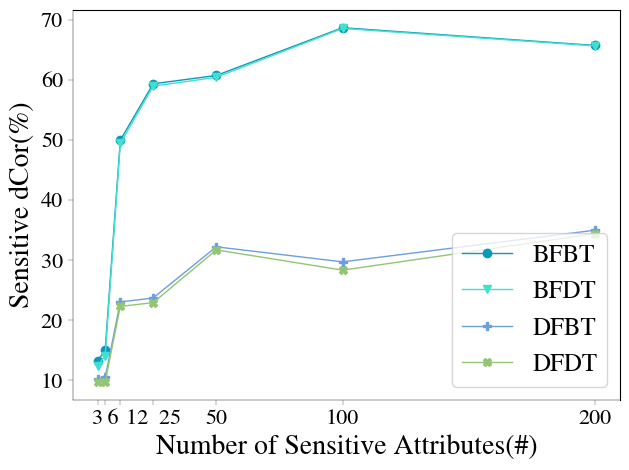

In [29]:
font = {"family": 'Nimbus Roman',
       "size": 20}
font1 = {"family": 'Nimbus Roman',
       "size": 18}
fig, ax = plt.subplots()
plt.grid(None)
ax.grid(None)
ax.spines['left'].set_color('#000000')
ax.spines['left'].set_linewidth(0.3)
ax.spines['bottom'].set_color('#000000')
ax.spines['bottom'].set_linewidth(0.3)
# ax.axes.xaxis.set_visible(True)
# ax.axes.yaxis.set_visible(True)
ax.plot(diff_table_german["Size"], diff_table_german["BiasedF&BiasedT"]*100, label="BFBT", lw=1, color="#0D98BA", marker="o")
ax.plot(diff_table_german["Size"], diff_table_german["BiasedF&DebiasedT"]*100, label="BFDT", lw=1, color="#40E0D0", marker="v")
ax.plot(diff_table_german["Size"], diff_table_german["DebiasedF&BiasedT"]*100, label="DFBT", lw=1, color="#6CA0DC", marker="P")
ax.plot(diff_table_german["Size"], diff_table_german["DebiasedF&DebiasedT"]*100, label="DFDT", lw=1, color="#93C572", marker="X")
# ax.set_title('Sensitive Attribute Inference Attack')
#ax.legend()
plt.xlabel("Number of Sensitive Attributes(#)",fontdict=font)
plt.ylabel("Sensitive dCor(%)",fontdict=font)

ax.set_xticks([3,6,12,25,50,100,200])
ax.set_xticklabels(['3','   6','      12','      25','50','100','200'])
plt.legend(prop=font1, loc="lower right")
# plt.xlim((0,500))
# plt.ylim((59,100))
plt.rcParams['axes.facecolor']='#FFFFFF'
plt.tick_params(left=True,bottom=True,width=0.2,labelsize=16)
#sns.move_legend(ax, "bottom right")
labels=ax.get_xticklabels()+ax.get_yticklabels()
[label.set_fontname('Nimbus Roman') for label in labels]
plt.tight_layout()
# plt.xticks(fontsize=8)
plt.savefig("sensitive_dcor_german_re_16.png",dpi=1000)
plt.show()

In [46]:
def evaluate_gnn(y, mask, sens, pred, output):
    pred = pred[mask].cpu().numpy()
    accs = metrics.accuracy_score(y[mask].cpu().numpy(), pred)
    F1s = metrics.f1_score(y[mask].cpu().numpy(), pred)
    auc_rocs = metrics.roc_auc_score(y[mask].cpu().numpy(), output[mask].cpu().numpy()) # if mps, detach.().cpu().numpy(),
    # sps, eos = fair_metric(pred, y[mask].cpu().numpy(), sens[mask].cpu().numpy()),
    dcors = dcor.distance_correlation(pred, sens[mask].cpu().numpy())
    return accs, F1s, auc_rocs, dcors

In [53]:
def run_gnn(device, seed, model_name, data_name, data, x, edge_index, hid_dim_g,  
           LR, WD, dropout, epochs): # lambda_5, 
    x = x.to(device)
    edge_index = edge_index.to(device)
    # edge_weights = edge_weights.to(device),
    y = data.y.to(device)
    sens = data.sens.to(device)
    train_mask = data.idx_train.to(device)
    val_mask = data.idx_val.to(device)
    test_mask = data.idx_test.to(device)
 
    # Choose Model: MLP or other types of GNNs
    if model_name == "MLP":
        model = MLP(x.shape[1], hid_dim_g, 1, dropout).to(device)
    elif model_name == "GCN":
        model = GCN(x.shape[1], hid_dim_g, 1, dropout).to(device)
    # elif model_name == \"GIN\":
    #     model = GIN(x.shape[1], hid_dim_g, out_dim_g, dropout).to(device)
    # elif model_name == \"APPNP\":
    #     model = APPNP(x.shape[1], hid_dim_g, out_dim_g, dropout).to(device)
    elif model_name == "GraphSAGE":
        model = GraphSAGE(x.shape[1], hid_dim_g, 1, dropout).to(device)
    elif model_name == "SGC":
        model = SGC(x.shape[1], hid_dim_g, 1, dropout).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=WD, lr=LR)
    
    seed_run(seed)
    best_val_loss = 1e10
    val_loss_history = []
 
   
    for epoch in tqdm(range(1, epochs+1)):
        t = time.time()
        # train the model
        model.train()
        optimizer.zero_grad()
     
        output = model(x, edge_index)
        loss = F.binary_cross_entropy_with_logits(output[train_mask], y[train_mask].unsqueeze(1))
        # sens_loss = distance_correlation(output[train_mask].detach().cpu().numpy(), sens[train_mask].float().detach().cpu().numpy())
        # loss = cls_loss + lambda_1*sens_loss
        loss.backward()
        optimizer.step()
        # print('#'*100)
        # print(f'Epoch: {epoch:04d}, Loss: {loss:.4f}')
    
        model.eval()
        with torch.no_grad():
            output = model(x, edge_index)
            pred = (output.squeeze() > 0).type_as(y)
            loss_val = F.binary_cross_entropy_with_logits(output[val_mask], y[val_mask].unsqueeze(1))
            # cls_loss_val = F.binary_cross_entropy_with_logits(output[val_mask], y[val_mask].unsqueeze(1))
            # sens_loss_val = distance_correlation(output[val_mask].float().detach().cpu().numpy(), sens[val_mask].float().detach().cpu().numpy())
            # loss_val = cls_loss_val + lambda_1*sens_loss_val
            accs_val, F1s_val, auc_rocs_val, dcors_val = evaluate_gnn(y, val_mask, sens, pred, output)
            # cls_loss_val = F.binary_cross_entropy_with_logits(output[val_mask], y[val_mask].unsqueeze(1))
            # sens_loss_val = distance_corr(output[val_mask].unsqueeze(1), sens[val_mask].unsqueeze(1), control_term=control_term)
            # loss_val = cls_loss_val # + lambda_1*sens_loss_val
            if loss_val < best_val_loss:
                best_val_loss = loss_val.data
  
                accs_test, F1s_test, auc_rocs_test, dcors_test = evaluate_gnn(y, test_mask, sens, pred, output)
                # print('#'*100)
                # print(f'Epoch: {epoch:03d}, AUC: {auc_rocs_test:.4f}, Accuracy: {accs_test:.4f}, F1: {F1s_test:.4f}, Statistical Parity: {sps_test:.4f}, Equal Opportunity: {eos_test:.4f}')
   
    # print('======' + data_name + '======')
    # print('auc_roc:', auc_rocs_test * 100)
    # print('Acc:', accs_test * 100)
    # print('f1:', F1s_test * 100)
    # print('dcor:', dcors_test * 100)
  
    return accs_test, F1s_test, auc_rocs_test, dcors_test

In [55]:
def run_experiment(device, seed, model_name, data_name, data, x, edge_index, hid_dim_g,  
             LR, WD, dropout, epochs):
    acc_run, f1_run, auc_roc_run, dcor_run = [], [], [], []
    for sd in seed:
        acc, f1, auc_roc, dcor = run_gnn(device, sd, model_name, data_name, data, x, edge_index, hid_dim_g,  
             LR, WD, dropout, epochs)
        acc_run.append(acc)
        f1_run.append(f1)
        auc_roc_run.append(auc_roc)
        dcor_run.append(dcor)
    print('======' + "This is the original result for " + data_name + '======')
    print('Accuracy:', np.mean(acc_run) * 100, np.std(acc_run) * 100)
    print('F1:', np.mean(f1_run) * 100, np.std(f1_run) * 100)
    print('AUROC:', np.mean(auc_roc_run) * 100, np.std(auc_roc_run) * 100)
    print('dcor:', np.mean(dcor_run) * 100, np.std(dcor_run) * 100)
    return acc_run, f1_run, auc_roc_run, dcor_run

In [38]:
%%capture
%run "./Comparison.ipynb"

In [40]:
import time

In [58]:
acc_gcn_d, f1_gcn_d, auc_roc_gcn_d, dcor_gcn_d =run_experiment(device=torch.device("cuda"), seed=list(range(2,12)), model_name="GCN", data_name="German", data=german_data, x=german_x_emb, edge_index=german_edge_index_debias, 
                                                                   hid_dim_g=16, LR=0.01, WD=1e-5, dropout=0.2, epochs=1000)

100%|██████████| 1000/1000 [00:09<00:00, 102.06it/s]

======This is the original result for German======
Accuracy: 69.28 1.899894733926065
F1: 80.68055419905 1.5187554405266657
AUROC: 65.39504761904762 6.651963061490088
dcor: 9.583658992919853 4.555971706929696


In [60]:
acc_gcn_d, f1_gcn_d, auc_roc_gcn_d, dcor_gcn_d =run_experiment(device=torch.device("cuda"), seed=list(range(2,12)), model_name="GCN", data_name="German", data=german_data, x=german_x_emb, edge_index=german_edge_index_debias, 
                                                                   hid_dim_g=16, LR=0.03, WD=1e-5, dropout=0.2, epochs=1000)

100%|██████████| 1000/1000 [00:09<00:00, 102.05it/s]

======This is the original result for German======
Accuracy: 70.6 2.009975124224177
F1: 80.47568021346899 2.0394015366485845
AUROC: 72.56761904761906 2.0582663598677575
dcor: 12.049250474052702 3.679850823738937


In [59]:
acc_gcn_d, f1_gcn_d, auc_roc_gcn_d, dcor_gcn_d =run_experiment(device=torch.device("cuda"), seed=list(range(2,12)), model_name="GCN", data_name="German", data=german_data, x=german_data.x, edge_index=german_data.edge_index, 
                                                                   hid_dim_g=16, LR=0.01, WD=1e-5, dropout=0.2, epochs=1000)

100%|██████████| 1000/1000 [00:09<00:00, 101.51it/s]

======This is the original result for German======
Accuracy: 70.32000000000001 2.254240448576858
F1: 79.89884460905594 1.4586668006291208
AUROC: 67.96723809523809 6.753697651192184
dcor: 32.8790713683148 14.565843826301617


In [61]:
acc_gcn_d, f1_gcn_d, auc_roc_gcn_d, dcor_gcn_d =run_experiment(device=torch.device("cuda"), seed=list(range(2,12)), model_name="GCN", data_name="German", data=german_data, x=german_data.x, edge_index=german_data.edge_index, 
                                                                   hid_dim_g=16, LR=0.03, WD=1e-5, dropout=0.2, epochs=1000)

100%|██████████| 1000/1000 [00:09<00:00, 102.41it/s]

======This is the original result for German======
Accuracy: 69.03999999999999 5.104351085103766
F1: 78.41216620391937 3.813846401449498
AUROC: 68.97866666666667 7.1776270082380105
dcor: 31.241624117126914 12.637089184766594
